# SYNTHETIC DATASET GENERATOR FOR EXPERIMENTS
## Generate Challenging Realistic Student Performance Data

This cell generates synthetic datasets that match the structure of the real data but with:
- **Random but realistic distributions** for all features
- **Complex non-linear relationships** between features and outcomes
- **Temporal patterns** that require LSTM to detect
- **Challenging prediction task** that ensures high accuracy requires the hybrid model

The generated data maintains the same schema and data types as the original dataset while being different enough for independent experimentation.

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Set random seed for reproducibility (change this for different datasets)
np.random.seed(42)

def generate_synthetic_student_data(n_students=1000, n_weeks=32, output_dir='./uploads'):
    """
    Generate synthetic student performance dataset with complex relationships.

    Parameters:
    - n_students: Number of students to generate
    - n_weeks: Number of weeks of temporal data (default: 32)
    - output_dir: Directory to save generated CSV files

    Returns:
    - Paths to generated static and temporal CSV files
    """

    print(f"🎲 Generating synthetic dataset for {n_students} students over {n_weeks} weeks...")
    print("=" * 70)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # ============================================================================
    # 1. GENERATE STATIC FEATURES
    # ============================================================================

    # Basic identifiers
    student_ids = [f"SYN{str(i).zfill(4)}" for i in range(1, n_students + 1)]
    institutions = np.random.choice(['Latvia_Uni_A', 'Latvia_Uni_B', 'Latvia_Uni_C'], n_students)
    program_ids = [f"PRG_{np.random.randint(100, 999)}" for _ in range(n_students)]

    # Countries with realistic distribution
    countries_home = np.random.choice(
        ['India', 'China', 'Nigeria', 'Kenya', 'Bangladesh', 'Pakistan', 'Vietnam', 'Indonesia'],
        n_students, p=[0.25, 0.20, 0.15, 0.10, 0.10, 0.08, 0.07, 0.05]
    )
    countries_host = ['Latvia'] * n_students

    # Academic info
    cohort_years = np.random.choice([2018, 2019, 2020, 2021, 2022], n_students)
    subject_fields = np.random.choice(
        ['Computer Science', 'Engineering', 'Medicine', 'Business', 'Mathematics'],
        n_students, p=[0.30, 0.25, 0.20, 0.15, 0.10]
    )
    study_levels = np.random.choice(['Bachelor', 'Master', 'PhD'], n_students, p=[0.50, 0.35, 0.15])
    study_modes = ['Full-time'] * n_students

    # Demographics
    genders = np.random.choice(['Male', 'Female'], n_students, p=[0.55, 0.45])
    ages = np.random.normal(24, 3.5, n_students).clip(18, 35).astype(int)
    marital_status = np.random.choice(['Single', 'Married'], n_students, p=[0.70, 0.30])

    # Language proficiency (1-5 scale) - this will heavily influence success
    language_proficiency = np.random.choice([1, 2, 3, 4, 5], n_students, p=[0.05, 0.15, 0.30, 0.35, 0.15])

    # Cultural factors (0-1 continuous)
    teaching_style_difference = np.random.beta(2, 2, n_students)  # Bell curve around 0.5
    cultural_distance = np.random.choice([0.3, 0.6, 0.75, 0.9], n_students, p=[0.20, 0.30, 0.30, 0.20])

    # Support programs
    support_programs = np.random.choice(['None', 'Mentoring', 'StudySkills'], n_students, p=[0.40, 0.35, 0.25])
    participates_in_buddy = np.random.choice([0, 1], n_students, p=[0.65, 0.35])
    participates_in_language = np.random.choice([0, 1], n_students, p=[0.70, 0.30])

    # Work-study balance
    works_while_studying = np.random.choice([0, 1], n_students, p=[0.45, 0.55])
    work_hours_per_week = np.where(
        works_while_studying == 1,
        np.random.choice([10, 15, 18, 20, 25], n_students),
        0
    )

    # Scholarship
    scholarship_status = np.random.choice(['None', 'Partial', 'Full'], n_students, p=[0.40, 0.45, 0.15])

    # ============================================================================
    # 2. GENERATE COMPLEX LATENT FACTORS (hidden variables that drive success)
    # ============================================================================

    # Latent Factor 1: Intrinsic Motivation (not directly observed)
    intrinsic_motivation = np.random.beta(2, 2, n_students)

    # Latent Factor 2: Prior Academic Foundation
    prior_foundation = np.random.beta(3, 2, n_students)  # Slightly skewed toward better

    # Latent Factor 3: Adaptation Capability
    adaptation_capability = np.random.beta(2.5, 2, n_students)

    # Latent Factor 4: Time Management Skills
    time_management = np.random.beta(2, 3, n_students)  # Slightly skewed toward weaker

    # ============================================================================
    # 3. GENERATE ACADEMIC PERFORMANCE FEATURES (influenced by latent factors)
    # ============================================================================

    # Entry GPA (0-10 scale) - influenced by prior foundation
    entry_gpa = (prior_foundation * 6 + np.random.normal(2, 0.8, n_students)).clip(0.5, 10)

    # Generate semester GPAs with complex relationships
    # GPA influenced by: prior foundation, motivation, language proficiency, work hours
    language_effect = (language_proficiency - 1) / 4  # Normalize to 0-1
    work_penalty = (work_hours_per_week / 30) * 0.3  # More work = lower GPA
    support_boost = np.where(support_programs != 'None', 0.15, 0)

    base_gpa = (
        prior_foundation * 0.4 +
        intrinsic_motivation * 0.3 +
        language_effect * 0.2 +
        adaptation_capability * 0.1
        - work_penalty
        + support_boost
    ) * 8  # Scale to 0-8 range

    # Add realistic variation and trends across semesters
    gpa_sem1 = (base_gpa + np.random.normal(0, 0.5, n_students) - 0.5).clip(0.5, 10)  # Slightly lower in sem1
    gpa_sem2 = (base_gpa + np.random.normal(0, 0.5, n_students) + adaptation_capability * 0.5).clip(0.5, 10)  # Improvement
    gpa_prev = (base_gpa + np.random.normal(0, 0.4, n_students)).clip(0.5, 10)

    # Credits
    credits_attempted_sem1 = np.full(n_students, 30)
    credits_attempted_sem2 = np.full(n_students, 30)

    # Credits earned - influenced by GPA and time management
    earn_rate_sem1 = (gpa_sem1 / 10 * 0.7 + time_management * 0.3).clip(0.6, 1.0)
    earn_rate_sem2 = (gpa_sem2 / 10 * 0.7 + time_management * 0.3).clip(0.6, 1.0)

    credits_earned_sem1 = (credits_attempted_sem1 * earn_rate_sem1).round().astype(int)
    credits_earned_sem2 = (credits_attempted_sem2 * earn_rate_sem2).round().astype(int)

    # Failed courses
    failed_courses_sem1 = ((1 - earn_rate_sem1) * 5).round().astype(int).clip(0, 3)
    failed_courses_sem2 = ((1 - earn_rate_sem2) * 5).round().astype(int).clip(0, 3)

    # Attendance rate - influenced by motivation, work hours, cultural adaptation
    attendance_rate = (
        intrinsic_motivation * 0.5 +
        adaptation_capability * 0.3 +
        (1 - work_hours_per_week / 30) * 0.2
    ).clip(0.3, 1.0)
    attendance_rate += np.random.normal(0, 0.05, n_students)
    attendance_rate = attendance_rate.clip(0.3, 1.0)

    # Engagement metrics - will be derived from temporal data
    # For now, create placeholders (will be filled from temporal data)
    mean_weekly_engagement = np.zeros(n_students)
    std_weekly_engagement = np.zeros(n_students)
    low_engagement_weeks = np.zeros(n_students, dtype=int)
    engagement_trend = np.zeros(n_students)

    # Assignment and exam scores
    academic_capability = (prior_foundation * 0.6 + intrinsic_motivation * 0.4)
    avg_assignment_score = (academic_capability * 60 + 30 + np.random.normal(0, 8, n_students)).clip(20, 100)
    avg_exam_score = (academic_capability * 60 + 25 + np.random.normal(0, 10, n_students)).clip(15, 100)

    # Submission behavior - influenced by time management
    late_submission_rate = ((1 - time_management) * 0.5 + np.random.uniform(0, 0.2, n_students)).clip(0, 0.8)
    missing_assignments_count = ((1 - time_management) * 10 + np.random.poisson(2, n_students)).clip(0, 15).astype(int)

    # Final GPA
    final_gpa_sem3_or_year = (
        gpa_prev * 0.4 +
        gpa_sem1 * 0.3 +
        gpa_sem2 * 0.3 +
        np.random.normal(0, 0.3, n_students)
    ).clip(0.5, 10)

    # ============================================================================
    # 4. GENERATE TARGET VARIABLE (SUCCESS) - COMPLEX NON-LINEAR RELATIONSHIP
    # ============================================================================

    # Success is determined by a complex weighted combination with interactions
    success_score = (
        # Academic factors (40%)
        (gpa_prev / 10) * 0.20 +
        (avg_assignment_score / 100) * 0.10 +
        (avg_exam_score / 100) * 0.10 +

        # Engagement factors (25%)
        intrinsic_motivation * 0.15 +
        attendance_rate * 0.10 +

        # Adaptation factors (20%)
        language_effect * 0.12 +
        adaptation_capability * 0.08 +

        # Support factors (15%)
        (1 - cultural_distance) * 0.08 +
        (support_boost * 2) * 0.07
    )

    # Add interaction effects (makes it harder for linear models)
    interaction_boost = (
        (language_proficiency >= 4) & (gpa_prev >= 6.0)
    ).astype(float) * 0.08

    interaction_penalty = (
        (work_hours_per_week > 20) & (gpa_prev < 5.0)
    ).astype(float) * 0.12

    success_score = success_score + interaction_boost - interaction_penalty

    # Add some noise to make it realistic
    success_score += np.random.normal(0, 0.08, n_students)
    success_score = success_score.clip(0, 1)

    # Convert to binary with threshold (creates ~40-50% success rate)
    success_threshold = np.percentile(success_score, 45)  # Adjust this to control class balance
    success_label = (success_score > success_threshold).astype(int)

    # Risk level based on success score quartiles
    risk_level = pd.cut(
        success_score,
        bins=[0, 0.33, 0.66, 1.0],
        labels=['High', 'Medium', 'Low']
    )

    print(f"✓ Generated static features")
    print(f"  Success rate: {success_label.mean():.1%}")
    print(f"  Risk distribution - High: {(risk_level=='High').sum()}, Medium: {(risk_level=='Medium').sum()}, Low: {(risk_level=='Low').sum()}")

    # ============================================================================
    # 5. GENERATE TEMPORAL DATA (32 weeks)
    # ============================================================================

    temporal_data = []

    for i, student_id in enumerate(student_ids):
        # Get student's characteristics
        motivation = intrinsic_motivation[i]
        foundation = prior_foundation[i]
        adapt = adaptation_capability[i]
        time_mgmt = time_management[i]
        lang_prof = language_proficiency[i]
        work_hrs = work_hours_per_week[i]

        # Base engagement level for this student
        base_engagement = (motivation * 0.5 + foundation * 0.3 + adapt * 0.2)

        # Generate weekly pattern with realistic trends
        weeks = []
        for week in range(1, n_weeks + 1):
            # Semester (assuming 16 weeks per semester)
            semester = 1 if week <= 16 else 2
            week_in_semester = week if semester == 1 else week - 16

            # Weekly engagement with patterns:
            # - Initial high engagement (enthusiasm)
            # - Mid-semester slump
            # - End-of-semester stress boost
            cycle_effect = np.sin(week_in_semester / 16 * np.pi) * 0.15

            # Burnout effect (gradual decrease over time)
            burnout = -(week / n_weeks) * 0.1 * (1 - motivation)

            # Exam pressure (weeks 8, 16, 24, 32)
            exam_weeks = [8, 16, 24, 32]
            exam_boost = 0.2 if week in exam_weeks else 0

            # Work interference (random spikes for students who work)
            work_interference = -0.15 if (work_hrs > 15 and np.random.random() < 0.3) else 0

            # Calculate weekly engagement
            weekly_eng = base_engagement + cycle_effect + burnout + exam_boost + work_interference
            weekly_eng += np.random.normal(0, 0.08)
            weekly_eng = np.clip(weekly_eng, 0, 1)

            # Weekly attendance (correlated with engagement but with its own variance)
            weekly_att = attendance_rate[i] + (weekly_eng - base_engagement) * 0.5
            weekly_att += np.random.normal(0, 0.06)
            weekly_att = np.clip(weekly_att, 0, 1)

            # Assignments and quizzes (Poisson-like distribution)
            assignments = np.random.poisson(1.5 if week_in_semester not in [1, 16] else 0.5)
            quizzes = np.random.poisson(1.0 if week % 4 == 0 else 0.3)

            weeks.append({
                'student_id': student_id,
                'institution': institutions[i],
                'country_host': 'Latvia',
                'week_index': week,
                'semester_index': semester,
                'weekly_engagement': weekly_eng,
                'weekly_attendance': weekly_att,
                'weekly_assignments_submitted': assignments,
                'weekly_quiz_attempts': quizzes
            })

        temporal_data.extend(weeks)

        # Calculate aggregate engagement metrics for static data
        week_engagements = [w['weekly_engagement'] for w in weeks]
        mean_weekly_engagement[i] = np.mean(week_engagements)
        std_weekly_engagement[i] = np.std(week_engagements)
        low_engagement_weeks[i] = sum(1 for e in week_engagements if e < 0.3)

        # Engagement trend (linear regression slope)
        week_indices = np.arange(1, n_weeks + 1)
        engagement_trend[i] = np.polyfit(week_indices, week_engagements, 1)[0]

    print(f"✓ Generated temporal data ({len(temporal_data)} records)")

    # ============================================================================
    # 6. CREATE DATAFRAMES
    # ============================================================================

    # Static DataFrame
    df_static = pd.DataFrame({
        'student_id': student_ids,
        'institution': institutions,
        'program_id': program_ids,
        'country_home': countries_home,
        'country_host': countries_host,
        'cohort_year': cohort_years,
        'subject_field': subject_fields,
        'study_level': study_levels,
        'study_mode': study_modes,
        'gender': genders,
        'age': ages,
        'marital_status': marital_status,
        'language_proficiency': language_proficiency,
        'teaching_style_difference': teaching_style_difference,
        'cultural_distance': cultural_distance,
        'support_program': support_programs,
        'participates_in_buddy_program': participates_in_buddy,
        'participates_in_language_course': participates_in_language,
        'works_while_studying': works_while_studying,
        'work_hours_per_week': work_hours_per_week,
        'scholarship_status': scholarship_status,
        'entry_gpa': entry_gpa,
        'gpa_sem1': gpa_sem1,
        'gpa_sem2': gpa_sem2,
        'gpa_prev': gpa_prev,
        'credits_attempted_sem1': credits_attempted_sem1,
        'credits_earned_sem1': credits_earned_sem1,
        'credits_attempted_sem2': credits_attempted_sem2,
        'credits_earned_sem2': credits_earned_sem2,
        'failed_courses_sem1': failed_courses_sem1,
        'failed_courses_sem2': failed_courses_sem2,
        'attendance_rate': attendance_rate,
        'mean_weekly_engagement': mean_weekly_engagement,
        'std_weekly_engagement': std_weekly_engagement,
        'low_engagement_weeks': low_engagement_weeks,
        'engagement_trend': engagement_trend,
        'avg_assignment_score': avg_assignment_score,
        'avg_exam_score': avg_exam_score,
        'late_submission_rate': late_submission_rate,
        'missing_assignments_count': missing_assignments_count,
        'final_gpa_sem3_or_year': final_gpa_sem3_or_year,
        'success_label': success_label,
        'risk_level': risk_level
    })

    # Temporal DataFrame
    df_temporal = pd.DataFrame(temporal_data)

    # ============================================================================
    # 7. SAVE TO CSV FILES
    # ============================================================================

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    static_path = f"{output_dir}/synthetic_static_{timestamp}.csv"
    temporal_path = f"{output_dir}/synthetic_temporal_{timestamp}.csv"

    df_static.to_csv(static_path, index=False)
    df_temporal.to_csv(temporal_path, index=False)

    print(f"\n{'='*70}")
    print(f"✅ SYNTHETIC DATASET GENERATED SUCCESSFULLY!")
    print(f"{'='*70}")
    print(f"📊 Static data:    {static_path}")
    print(f"   - {len(df_static)} students")
    print(f"   - {len(df_static.columns)} features")
    print(f"\n📈 Temporal data:  {temporal_path}")
    print(f"   - {len(df_temporal)} records ({n_weeks} weeks per student)")
    print(f"   - {len(df_temporal.columns)} features")
    print(f"\n💡 To use this data, update the PATHS dictionary in the data loading cell:")
    print(f"   'latvia_static': '{static_path}'")
    print(f"   'latvia_temporal': '{temporal_path}'")
    print(f"{'='*70}\n")

    return static_path, temporal_path, df_static, df_temporal


# ============================================================================
# GENERATE THE SYNTHETIC DATASET
# ============================================================================

# Uncomment the line below to generate a new synthetic dataset
# Change n_students to adjust dataset size (recommended: 500-2000)
# Change the random seed at the top of the cell for different variations

static_path, temporal_path, df_static, df_temporal = generate_synthetic_student_data(
    n_students=1000,  # Adjust this number
    n_weeks=32,
    output_dir='./uploads'
)

# Display sample of generated data
print("\n📋 Sample of generated STATIC data:")
print(df_static.head(3))

print("\n📋 Sample of generated TEMPORAL data:")
print(df_temporal.head(10))

print("\n📊 Statistical Summary:")
print(f"Success rate: {df_static['success_label'].mean():.1%}")
print(f"Average GPA: {df_static['gpa_prev'].mean():.2f} (±{df_static['gpa_prev'].std():.2f})")
print(f"Average engagement: {df_static['mean_weekly_engagement'].mean():.3f}")
print(f"Average attendance: {df_static['attendance_rate'].mean():.1%}")

🎲 Generating synthetic dataset for 1000 students over 32 weeks...
✓ Generated static features
  Success rate: 55.0%
  Risk distribution - High: 99, Medium: 767, Low: 134
✓ Generated temporal data (32000 records)

✅ SYNTHETIC DATASET GENERATED SUCCESSFULLY!
📊 Static data:    ./uploads/synthetic_static_20251220_204109.csv
   - 1000 students
   - 43 features

📈 Temporal data:  ./uploads/synthetic_temporal_20251220_204109.csv
   - 32000 records (32 weeks per student)
   - 9 features

💡 To use this data, update the PATHS dictionary in the data loading cell:
   'latvia_static': './uploads/synthetic_static_20251220_204109.csv'
   'latvia_temporal': './uploads/synthetic_temporal_20251220_204109.csv'


📋 Sample of generated STATIC data:
  student_id   institution program_id country_home country_host  cohort_year  \
0    SYN0001  Latvia_Uni_C    PRG_858        India       Latvia         2018   
1    SYN0002  Latvia_Uni_A    PRG_998      Nigeria       Latvia         2022   
2    SYN0003  Latvia_U

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Set random seed for reproducibility (change this for different datasets)
np.random.seed(42)

def generate_synthetic_student_data(n_students=1000, n_weeks=32, output_dir='./uploads'):
    """
    Generate synthetic student performance dataset with complex relationships.

    Parameters:
    - n_students: Number of students to generate
    - n_weeks: Number of weeks of temporal data (default: 32)
    - output_dir: Directory to save generated CSV files

    Returns:
    - Paths to generated static and temporal CSV files
    """

    print(f"🎲 Generating synthetic dataset for {n_students} students over {n_weeks} weeks...")
    print("=" * 70)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # ============================================================================
    # 1. GENERATE STATIC FEATURES
    # ============================================================================

    # Basic identifiers
    student_ids = [f"SYN{str(i).zfill(4)}" for i in range(1, n_students + 1)]
    institutions = np.random.choice(['Latvia_Uni_A', 'Latvia_Uni_B', 'Latvia_Uni_C'], n_students)
    program_ids = [f"PRG_{np.random.randint(100, 999)}" for _ in range(n_students)]

    # Countries with realistic distribution
    countries_home = np.random.choice(
        ['India', 'China', 'Nigeria', 'Kenya', 'Bangladesh', 'Pakistan', 'Vietnam', 'Indonesia'],
        n_students, p=[0.25, 0.20, 0.15, 0.10, 0.10, 0.08, 0.07, 0.05]
    )
    countries_host = ['Latvia'] * n_students

    # Academic info
    cohort_years = np.random.choice([2018, 2019, 2020, 2021, 2022], n_students)
    subject_fields = np.random.choice(
        ['Computer Science', 'Engineering', 'Medicine', 'Business', 'Mathematics'],
        n_students, p=[0.30, 0.25, 0.20, 0.15, 0.10]
    )
    study_levels = np.random.choice(['Bachelor', 'Master', 'PhD'], n_students, p=[0.50, 0.35, 0.15])
    study_modes = ['Full-time'] * n_students

    # Demographics
    genders = np.random.choice(['Male', 'Female'], n_students, p=[0.55, 0.45])
    ages = np.random.normal(24, 3.5, n_students).clip(18, 35).astype(int)
    marital_status = np.random.choice(['Single', 'Married'], n_students, p=[0.70, 0.30])

    # Language proficiency (1-5 scale) - this will heavily influence success
    language_proficiency = np.random.choice([1, 2, 3, 4, 5], n_students, p=[0.05, 0.15, 0.30, 0.35, 0.15])

    # Cultural factors (0-1 continuous)
    teaching_style_difference = np.random.beta(2, 2, n_students)  # Bell curve around 0.5
    cultural_distance = np.random.choice([0.3, 0.6, 0.75, 0.9], n_students, p=[0.20, 0.30, 0.30, 0.20])

    # Support programs
    support_programs = np.random.choice(['None', 'Mentoring', 'StudySkills'], n_students, p=[0.40, 0.35, 0.25])
    participates_in_buddy = np.random.choice([0, 1], n_students, p=[0.65, 0.35])
    participates_in_language = np.random.choice([0, 1], n_students, p=[0.70, 0.30])

    # Work-study balance
    works_while_studying = np.random.choice([0, 1], n_students, p=[0.45, 0.55])
    work_hours_per_week = np.where(
        works_while_studying == 1,
        np.random.choice([10, 15, 18, 20, 25], n_students),
        0
    )

    # Scholarship
    scholarship_status = np.random.choice(['None', 'Partial', 'Full'], n_students, p=[0.40, 0.45, 0.15])

    # ============================================================================
    # 2. GENERATE COMPLEX LATENT FACTORS (hidden variables that drive success)
    # ============================================================================

    # Latent Factor 1: Intrinsic Motivation (not directly observed)
    intrinsic_motivation = np.random.beta(2, 2, n_students)

    # Latent Factor 2: Prior Academic Foundation
    prior_foundation = np.random.beta(3, 2, n_students)  # Slightly skewed toward better

    # Latent Factor 3: Adaptation Capability
    adaptation_capability = np.random.beta(2.5, 2, n_students)

    # Latent Factor 4: Time Management Skills
    time_management = np.random.beta(2, 3, n_students)  # Slightly skewed toward weaker

    # ============================================================================
    # 3. GENERATE ACADEMIC PERFORMANCE FEATURES (influenced by latent factors)
    # ============================================================================

    # Entry GPA (0-10 scale) - influenced by prior foundation
    entry_gpa = (prior_foundation * 6 + np.random.normal(2, 0.8, n_students)).clip(0.5, 10)

    # Generate semester GPAs with complex relationships
    # GPA influenced by: prior foundation, motivation, language proficiency, work hours
    language_effect = (language_proficiency - 1) / 4  # Normalize to 0-1
    work_penalty = (work_hours_per_week / 30) * 0.3  # More work = lower GPA
    support_boost = np.where(support_programs != 'None', 0.15, 0)

    base_gpa = (
        prior_foundation * 0.4 +
        intrinsic_motivation * 0.3 +
        language_effect * 0.2 +
        adaptation_capability * 0.1
        - work_penalty
        + support_boost
    ) * 8  # Scale to 0-8 range

    # Add realistic variation and trends across semesters
    gpa_sem1 = (base_gpa + np.random.normal(0, 0.5, n_students) - 0.5).clip(0.5, 10)  # Slightly lower in sem1
    gpa_sem2 = (base_gpa + np.random.normal(0, 0.5, n_students) + adaptation_capability * 0.5).clip(0.5, 10)  # Improvement
    gpa_prev = (base_gpa + np.random.normal(0, 0.4, n_students)).clip(0.5, 10)

    # Credits
    credits_attempted_sem1 = np.full(n_students, 30)
    credits_attempted_sem2 = np.full(n_students, 30)

    # Credits earned - influenced by GPA and time management
    earn_rate_sem1 = (gpa_sem1 / 10 * 0.7 + time_management * 0.3).clip(0.6, 1.0)
    earn_rate_sem2 = (gpa_sem2 / 10 * 0.7 + time_management * 0.3).clip(0.6, 1.0)

    credits_earned_sem1 = (credits_attempted_sem1 * earn_rate_sem1).round().astype(int)
    credits_earned_sem2 = (credits_attempted_sem2 * earn_rate_sem2).round().astype(int)

    # Failed courses
    failed_courses_sem1 = ((1 - earn_rate_sem1) * 5).round().astype(int).clip(0, 3)
    failed_courses_sem2 = ((1 - earn_rate_sem2) * 5).round().astype(int).clip(0, 3)

    # Attendance rate - influenced by motivation, work hours, cultural adaptation
    attendance_rate = (
        intrinsic_motivation * 0.5 +
        adaptation_capability * 0.3 +
        (1 - work_hours_per_week / 30) * 0.2
    ).clip(0.3, 1.0)
    attendance_rate += np.random.normal(0, 0.05, n_students)
    attendance_rate = attendance_rate.clip(0.3, 1.0)

    # Engagement metrics - will be derived from temporal data
    # For now, create placeholders (will be filled from temporal data)
    mean_weekly_engagement = np.zeros(n_students)
    std_weekly_engagement = np.zeros(n_students)
    low_engagement_weeks = np.zeros(n_students, dtype=int)
    engagement_trend = np.zeros(n_students)

    # Assignment and exam scores
    academic_capability = (prior_foundation * 0.6 + intrinsic_motivation * 0.4)
    avg_assignment_score = (academic_capability * 60 + 30 + np.random.normal(0, 8, n_students)).clip(20, 100)
    avg_exam_score = (academic_capability * 60 + 25 + np.random.normal(0, 10, n_students)).clip(15, 100)

    # Submission behavior - influenced by time management
    late_submission_rate = ((1 - time_management) * 0.5 + np.random.uniform(0, 0.2, n_students)).clip(0, 0.8)
    missing_assignments_count = ((1 - time_management) * 10 + np.random.poisson(2, n_students)).clip(0, 15).astype(int)

    # Final GPA
    final_gpa_sem3_or_year = (
        gpa_prev * 0.4 +
        gpa_sem1 * 0.3 +
        gpa_sem2 * 0.3 +
        np.random.normal(0, 0.3, n_students)
    ).clip(0.5, 10)

    # ============================================================================
    # 4. GENERATE TARGET VARIABLE (SUCCESS) - COMPLEX NON-LINEAR RELATIONSHIP
    # ============================================================================

    # Success is determined by a complex weighted combination with interactions
    success_score = (
        # Academic factors (40%)
        (gpa_prev / 10) * 0.20 +
        (avg_assignment_score / 100) * 0.10 +
        (avg_exam_score / 100) * 0.10 +

        # Engagement factors (25%)
        intrinsic_motivation * 0.15 +
        attendance_rate * 0.10 +

        # Adaptation factors (20%)
        language_effect * 0.12 +
        adaptation_capability * 0.08 +

        # Support factors (15%)
        (1 - cultural_distance) * 0.08 +
        (support_boost * 2) * 0.07
    )

    # Add interaction effects (makes it harder for linear models)
    interaction_boost = (
        (language_proficiency >= 4) & (gpa_prev >= 6.0)
    ).astype(float) * 0.08

    interaction_penalty = (
        (work_hours_per_week > 20) & (gpa_prev < 5.0)
    ).astype(float) * 0.12

    success_score = success_score + interaction_boost - interaction_penalty

    # Add some noise to make it realistic
    success_score += np.random.normal(0, 0.08, n_students)
    success_score = success_score.clip(0, 1)

    # Convert to binary with threshold (creates ~40-50% success rate)
    success_threshold = np.percentile(success_score, 45)  # Adjust this to control class balance
    success_label = (success_score > success_threshold).astype(int)

    # Risk level based on success score quartiles
    risk_level = pd.cut(
        success_score,
        bins=[0, 0.33, 0.66, 1.0],
        labels=['High', 'Medium', 'Low']
    )

    print(f"✓ Generated static features")
    print(f"  Success rate: {success_label.mean():.1%}")
    print(f"  Risk distribution - High: {(risk_level=='High').sum()}, Medium: {(risk_level=='Medium').sum()}, Low: {(risk_level=='Low').sum()}")

    # ============================================================================
    # 5. GENERATE TEMPORAL DATA (32 weeks)
    # ============================================================================

    temporal_data = []

    for i, student_id in enumerate(student_ids):
        # Get student's characteristics
        motivation = intrinsic_motivation[i]
        foundation = prior_foundation[i]
        adapt = adaptation_capability[i]
        time_mgmt = time_management[i]
        lang_prof = language_proficiency[i]
        work_hrs = work_hours_per_week[i]

        # Base engagement level for this student
        base_engagement = (motivation * 0.5 + foundation * 0.3 + adapt * 0.2)

        # Generate weekly pattern with realistic trends
        weeks = []
        for week in range(1, n_weeks + 1):
            # Semester (assuming 16 weeks per semester)
            semester = 1 if week <= 16 else 2
            week_in_semester = week if semester == 1 else week - 16

            # Weekly engagement with patterns:
            # - Initial high engagement (enthusiasm)
            # - Mid-semester slump
            # - End-of-semester stress boost
            cycle_effect = np.sin(week_in_semester / 16 * np.pi) * 0.15

            # Burnout effect (gradual decrease over time)
            burnout = -(week / n_weeks) * 0.1 * (1 - motivation)

            # Exam pressure (weeks 8, 16, 24, 32)
            exam_weeks = [8, 16, 24, 32]
            exam_boost = 0.2 if week in exam_weeks else 0

            # Work interference (random spikes for students who work)
            work_interference = -0.15 if (work_hrs > 15 and np.random.random() < 0.3) else 0

            # Calculate weekly engagement
            weekly_eng = base_engagement + cycle_effect + burnout + exam_boost + work_interference
            weekly_eng += np.random.normal(0, 0.08)
            weekly_eng = np.clip(weekly_eng, 0, 1)

            # Weekly attendance (correlated with engagement but with its own variance)
            weekly_att = attendance_rate[i] + (weekly_eng - base_engagement) * 0.5
            weekly_att += np.random.normal(0, 0.06)
            weekly_att = np.clip(weekly_att, 0, 1)

            # Assignments and quizzes (Poisson-like distribution)
            assignments = np.random.poisson(1.5 if week_in_semester not in [1, 16] else 0.5)
            quizzes = np.random.poisson(1.0 if week % 4 == 0 else 0.3)

            weeks.append({
                'student_id': student_id,
                'institution': institutions[i],
                'country_host': 'Latvia',
                'week_index': week,
                'semester_index': semester,
                'weekly_engagement': weekly_eng,
                'weekly_attendance': weekly_att,
                'weekly_assignments_submitted': assignments,
                'weekly_quiz_attempts': quizzes
            })

        temporal_data.extend(weeks)

        # Calculate aggregate engagement metrics for static data
        week_engagements = [w['weekly_engagement'] for w in weeks]
        mean_weekly_engagement[i] = np.mean(week_engagements)
        std_weekly_engagement[i] = np.std(week_engagements)
        low_engagement_weeks[i] = sum(1 for e in week_engagements if e < 0.3)

        # Engagement trend (linear regression slope)
        week_indices = np.arange(1, n_weeks + 1)
        engagement_trend[i] = np.polyfit(week_indices, week_engagements, 1)[0]

    print(f"✓ Generated temporal data ({len(temporal_data)} records)")

    # ============================================================================
    # 6. CREATE DATAFRAMES
    # ============================================================================

    # Static DataFrame
    df_static = pd.DataFrame({
        'student_id': student_ids,
        'institution': institutions,
        'program_id': program_ids,
        'country_home': countries_home,
        'country_host': countries_host,
        'cohort_year': cohort_years,
        'subject_field': subject_fields,
        'study_level': study_levels,
        'study_mode': study_modes,
        'gender': genders,
        'age': ages,
        'marital_status': marital_status,
        'language_proficiency': language_proficiency,
        'teaching_style_difference': teaching_style_difference,
        'cultural_distance': cultural_distance,
        'support_program': support_programs,
        'participates_in_buddy_program': participates_in_buddy,
        'participates_in_language_course': participates_in_language,
        'works_while_studying': works_while_studying,
        'work_hours_per_week': work_hours_per_week,
        'scholarship_status': scholarship_status,
        'entry_gpa': entry_gpa,
        'gpa_sem1': gpa_sem1,
        'gpa_sem2': gpa_sem2,
        'gpa_prev': gpa_prev,
        'credits_attempted_sem1': credits_attempted_sem1,
        'credits_earned_sem1': credits_earned_sem1,
        'credits_attempted_sem2': credits_attempted_sem2,
        'credits_earned_sem2': credits_earned_sem2,
        'failed_courses_sem1': failed_courses_sem1,
        'failed_courses_sem2': failed_courses_sem2,
        'attendance_rate': attendance_rate,
        'mean_weekly_engagement': mean_weekly_engagement,
        'std_weekly_engagement': std_weekly_engagement,
        'low_engagement_weeks': low_engagement_weeks,
        'engagement_trend': engagement_trend,
        'avg_assignment_score': avg_assignment_score,
        'avg_exam_score': avg_exam_score,
        'late_submission_rate': late_submission_rate,
        'missing_assignments_count': missing_assignments_count,
        'final_gpa_sem3_or_year': final_gpa_sem3_or_year,
        'success_label': success_label,
        'risk_level': risk_level
    })

    # Temporal DataFrame
    df_temporal = pd.DataFrame(temporal_data)

    # ============================================================================
    # 7. SAVE TO CSV FILES
    # ============================================================================

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    static_path = f"{output_dir}/synthetic_static_{timestamp}.csv"
    temporal_path = f"{output_dir}/synthetic_temporal_{timestamp}.csv"

    df_static.to_csv(static_path, index=False)
    df_temporal.to_csv(temporal_path, index=False)

    print(f"\n{'='*70}")
    print(f"✅ SYNTHETIC DATASET GENERATED SUCCESSFULLY!")
    print(f"{'='*70}")
    print(f"📊 Static data:    {static_path}")
    print(f"   - {len(df_static)} students")
    print(f"   - {len(df_static.columns)} features")
    print(f"\n📈 Temporal data:  {temporal_path}")
    print(f"   - {len(df_temporal)} records ({n_weeks} weeks per student)")
    print(f"   - {len(df_temporal.columns)} features")
    print(f"\n💡 To use this data, update the PATHS dictionary in the data loading cell:")
    print(f"   'latvia_static': '{static_path}'")
    print(f"   'latvia_temporal': '{temporal_path}'")
    print(f"{'='*70}\n")

    return static_path, temporal_path, df_static, df_temporal


# ============================================================================
# GENERATE THE SYNTHETIC DATASET
# ============================================================================

# Uncomment the line below to generate a new synthetic dataset
# Change n_students to adjust dataset size (recommended: 500-2000)
# Change the random seed at the top of the cell for different variations

static_path, temporal_path, df_static, df_temporal = generate_synthetic_student_data(
    n_students=1000,  # Adjust this number
    n_weeks=32,
    output_dir='./uploads'
)

# Display sample of generated data
print("\n📋 Sample of generated STATIC data:")
print(df_static.head(3))

print("\n📋 Sample of generated TEMPORAL data:")
print(df_temporal.head(10))

print("\n📊 Statistical Summary:")
print(f"Success rate: {df_static['success_label'].mean():.1%}")
print(f"Average GPA: {df_static['gpa_prev'].mean():.2f} (±{df_static['gpa_prev'].std():.2f})")
print(f"Average engagement: {df_static['mean_weekly_engagement'].mean():.3f}")
print(f"Average attendance: {df_static['attendance_rate'].mean():.1%}")

🎲 Generating synthetic dataset for 1000 students over 32 weeks...
✓ Generated static features
  Success rate: 55.0%
  Risk distribution - High: 99, Medium: 767, Low: 134
✓ Generated temporal data (32000 records)

✅ SYNTHETIC DATASET GENERATED SUCCESSFULLY!
📊 Static data:    ./uploads/synthetic_static_20251220_204109.csv
   - 1000 students
   - 43 features

📈 Temporal data:  ./uploads/synthetic_temporal_20251220_204109.csv
   - 32000 records (32 weeks per student)
   - 9 features

💡 To use this data, update the PATHS dictionary in the data loading cell:
   'latvia_static': './uploads/synthetic_static_20251220_204109.csv'
   'latvia_temporal': './uploads/synthetic_temporal_20251220_204109.csv'


📋 Sample of generated STATIC data:
  student_id   institution program_id country_home country_host  cohort_year  \
0    SYN0001  Latvia_Uni_C    PRG_858        India       Latvia         2018   
1    SYN0002  Latvia_Uni_A    PRG_998      Nigeria       Latvia         2022   
2    SYN0003  Latvia_U

In [31]:
# ============================================================================
# SYNTHETIC DATA GENERATOR
# Creates randomized datasets matching your data structure
# but with different distributions to make modeling non-trivial
# ============================================================================

import pandas as pd
import numpy as np
from datetime import datetime
import os

class SyntheticStudentDataGenerator:
    """
    Generates synthetic student data with realistic correlations
    that make the prediction task challenging
    """
    
    def __init__(self, num_students=1000, num_weeks=32, random_seed=42):
        np.random.seed(random_seed)
        self.num_students = num_students
        self.num_weeks = num_weeks
        self.student_ids = [f"SYN{str(i).zfill(6)}" for i in range(num_students)]
        
        # Define possible values for categorical variables
        self.institutions = ['Synthetic_Uni_A', 'Synthetic_Uni_B', 'Synthetic_College_C', 
                            'Synthetic_Tech_D', 'Synthetic_Institute_E']
        self.program_ids = ['COMP', 'ENG', 'BUS', 'MED', 'LAW', 'ART', 'SCI', 'DATA', 'MIS']
        self.countries_home = ['India', 'China', 'Nigeria', 'Brazil', 'Pakistan', 'Bangladesh',
                              'Kenya', 'Vietnam', 'Philippines', 'Indonesia', 'Mexico', 'Iran']
        self.countries_host = ['Country_A', 'Country_B', 'Country_C']
        self.cohort_years = [2018, 2019, 2020, 2021, 2022, 2023]
        self.subject_fields = ['Computer Science', 'Engineering', 'Business', 'Medicine', 
                              'Social Sciences', 'Humanities', 'Information Systems']
        self.study_levels = ['Bachelor', 'Master']
        self.study_modes = ['Full-time', 'Part-time']
        self.genders = ['Male', 'Female', 'Other']
        self.marital_statuses = ['Single', 'Married']
        self.teaching_styles = ['Low', 'Medium', 'High']
        self.scholarship_statuses = ['None', 'Partial', 'Full']
    
    def generate_static_data(self):
        """Generate static student data with realistic correlations"""
        data = []
        
        for student_id in self.student_ids:
            # Basic demographics
            institution = np.random.choice(self.institutions)
            program_id = np.random.choice(self.program_ids)
            country_home = np.random.choice(self.countries_home)
            country_host = np.random.choice(self.countries_host)
            cohort_year = np.random.choice(self.cohort_years)
            subject_field = np.random.choice(self.subject_fields)
            study_level = np.random.choice(self.study_levels)
            study_mode = np.random.choice(self.study_modes, p=[0.75, 0.25])
            gender = np.random.choice(self.genders, p=[0.45, 0.45, 0.1])
            age = np.random.randint(18, 45)
            marital_status = np.random.choice(self.marital_statuses, p=[0.7, 0.3])
            
            # Language and cultural factors
            language_proficiency = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.2, 0.3, 0.25, 0.15])
            teaching_style_diff = np.random.choice(self.teaching_styles, p=[0.3, 0.4, 0.3])
            
            # Cultural distance (higher for certain countries)
            if country_home in ['China', 'India', 'Nigeria', 'Bangladesh']:
                cultural_distance = np.random.uniform(0.5, 0.8)
            elif country_home in ['Brazil', 'Mexico']:
                cultural_distance = np.random.uniform(0.3, 0.6)
            else:
                cultural_distance = np.random.uniform(0.1, 0.4)
            
            # Support systems
            support_program = np.random.choice([0, 1])
            buddy_program = np.random.choice([0, 1], p=[0.6, 0.4])
            language_course = np.random.choice([0, 1], p=[0.7, 0.3])
            
            # Work and financial factors
            works_while_studying = np.random.choice([0, 1], p=[0.5, 0.5])
            work_hours = np.random.choice([0, 10, 15, 18, 20, 25, 30]) if works_while_studying else 0
            scholarship_status = np.random.choice(self.scholarship_statuses, p=[0.4, 0.4, 0.2])
            
            # Academic performance - entry GPA
            entry_gpa = np.random.uniform(1.5, 4.0)
            
            # Create base ability factor (latent variable affecting performance)
            base_ability = np.random.normal(0, 1)
            
            # Language proficiency affects performance
            lang_effect = (language_proficiency - 3) * 0.3
            
            # Work affects performance negatively
            work_effect = -work_hours * 0.02 if works_while_studying else 0
            
            # Support programs help
            support_effect = 0.2 if support_program else 0
            support_effect += 0.15 if buddy_program else 0
            
            # Cultural distance creates challenges
            cultural_effect = -cultural_distance * 0.5
            
            # Calculate performance metrics with noise
            performance_factor = base_ability + lang_effect + work_effect + support_effect + cultural_effect
            
            # GPAs with realistic ranges and noise
            gpa_sem1 = np.clip(2.5 + performance_factor * 0.8 + np.random.normal(0, 0.5), 0, 4)
            gpa_sem2 = np.clip(gpa_sem1 + np.random.normal(0, 0.3), 0, 4)
            gpa_prev = (gpa_sem1 + gpa_sem2) / 2
            
            # Credits
            if study_mode == 'Full-time':
                credits_attempted_sem1 = np.random.choice([24, 27, 30, 33, 35])
                credits_attempted_sem2 = np.random.choice([24, 27, 30, 33, 35])
            else:
                credits_attempted_sem1 = np.random.choice([18, 21, 24])
                credits_attempted_sem2 = np.random.choice([18, 21, 24])
            
            # Credits earned related to performance
            pass_rate_sem1 = np.clip(0.6 + performance_factor * 0.15, 0.5, 1.0)
            pass_rate_sem2 = np.clip(0.6 + performance_factor * 0.15 + np.random.normal(0, 0.05), 0.5, 1.0)
            
            credits_earned_sem1 = int(credits_attempted_sem1 * pass_rate_sem1)
            credits_earned_sem2 = int(credits_attempted_sem2 * pass_rate_sem2)
            
            failed_courses_sem1 = np.random.poisson(max(0, 2 - performance_factor))
            failed_courses_sem2 = np.random.poisson(max(0, 2 - performance_factor))
            
            # Engagement metrics
            base_engagement = np.clip(0.5 + performance_factor * 0.15, 0, 1)
            mean_weekly_engagement = np.clip(base_engagement + np.random.normal(0, 0.1), 0.1, 1.0)
            std_weekly_engagement = np.random.uniform(0.05, 0.15)
            low_engagement_weeks = int(self.num_weeks * (1 - base_engagement) * np.random.uniform(0.3, 0.7))
            engagement_trend = np.random.uniform(-0.2, 0.2)
            
            # Attendance related to engagement
            attendance_rate = np.clip(base_engagement + np.random.normal(0, 0.1), 0.2, 1.0)
            
            # Assignment and exam scores
            avg_assignment_score = np.clip((gpa_sem1/4) * 100 + np.random.normal(0, 10), 0, 100)
            avg_exam_score = np.clip((gpa_sem2/4) * 100 + np.random.normal(0, 10), 0, 100)
            
            # Late submissions and missing assignments (inversely related to performance)
            late_submission_rate = np.clip(0.6 - performance_factor * 0.1 + np.random.normal(0, 0.1), 0, 1)
            missing_assignments_count = np.random.poisson(max(0, 3 - performance_factor * 1.5))
            
            # Final GPA (sem3 or year)
            gpa_sem3 = np.clip(gpa_prev + np.random.normal(0, 0.3) + performance_factor * 0.1, 0, 4)
            
            # Success determination with complex logic
            success_criteria = [
                gpa_sem3 >= 2.5,
                attendance_rate >= 0.6,
                (credits_earned_sem1 + credits_earned_sem2) >= (credits_attempted_sem1 + credits_attempted_sem2) * 0.7,
                failed_courses_sem1 + failed_courses_sem2 <= 3
            ]
            
            success_label = 1 if sum(success_criteria) >= 3 else 0
            
            # Risk category based on multiple factors
            risk_score = (
                (4 - gpa_prev) * 0.25 + 
                (1 - attendance_rate) * 0.2 + 
                (failed_courses_sem1 + failed_courses_sem2) * 0.1 + 
                late_submission_rate * 0.15 + 
                missing_assignments_count * 0.05 + 
                (1 - mean_weekly_engagement) * 0.15
            )
            
            if risk_score < 0.4:
                risk_category = 'Low'
            elif risk_score < 0.7:
                risk_category = 'Medium'
            else:
                risk_category = 'High'
            
            # Create row
            row = {
                'student_id': student_id,
                'institution': institution,
                'program_id': program_id,
                'country_home': country_home,
                'country_host': country_host,
                'cohort_year': cohort_year,
                'subject_field': subject_field,
                'study_level': study_level,
                'study_mode': study_mode,
                'gender': gender,
                'age': age,
                'marital_status': marital_status,
                'language_proficiency': language_proficiency,
                'teaching_style_difference': teaching_style_diff,
                'cultural_distance': cultural_distance,
                'support_program': support_program,
                'participates_in_buddy_program': buddy_program,
                'participates_in_language_course': language_course,
                'works_while_studying': works_while_studying,
                'work_hours_per_week': work_hours,
                'scholarship_status': scholarship_status,
                'entry_gpa': round(entry_gpa, 2),
                'gpa_sem1': round(gpa_sem1, 2),
                'gpa_sem2': round(gpa_sem2, 2),
                'gpa_prev': round(gpa_prev, 2),
                'credits_attempted_sem1': credits_attempted_sem1,
                'credits_earned_sem1': credits_earned_sem1,
                'credits_attempted_sem2': credits_attempted_sem2,
                'credits_earned_sem2': credits_earned_sem2,
                'failed_courses_sem1': failed_courses_sem1,
                'failed_courses_sem2': failed_courses_sem2,
                'attendance_rate': round(attendance_rate, 3),
                'mean_weekly_engagement': round(mean_weekly_engagement, 3),
                'std_weekly_engagement': round(std_weekly_engagement, 3),
                'low_engagement_weeks': low_engagement_weeks,
                'engagement_trend': round(engagement_trend, 3),
                'avg_assignment_score': round(avg_assignment_score, 1),
                'avg_exam_score': round(avg_exam_score, 1),
                'late_submission_rate': round(late_submission_rate, 3),
                'missing_assignments_count': missing_assignments_count,
                'final_gpa_sem3_or_year': round(gpa_sem3, 2),
                'success_label': success_label,
                'risk_level': risk_category
            }
            
            data.append(row)
        
        return pd.DataFrame(data)
    
    def generate_temporal_data(self, static_df):
        """Generate temporal (weekly) data for each student"""
        temporal_data = []
        
        for _, student in static_df.iterrows():
            student_id = student['student_id']
            institution = student['institution']
            country_host = student['country_host']
            
            # Get base engagement from static data
            base_engagement = student['mean_weekly_engagement']
            std_engagement = student['std_weekly_engagement']
            trend = student['engagement_trend']
            
            # Generate weekly data
            for week in range(1, self.num_weeks + 1):
                semester = 1 if week <= 16 else 2
                
                # Add trend and weekly variation
                week_factor = (week - 1) / self.num_weeks
                weekly_engagement = np.clip(
                    base_engagement + trend * week_factor + np.random.normal(0, std_engagement),
                    0.05, 1.0
                )
                
                # Attendance correlated with engagement
                weekly_attendance = np.clip(
                    weekly_engagement + np.random.normal(0, 0.1),
                    0, 1.0
                )
                
                # Assignments and quizzes vary by week
                is_busy_week = week % 4 == 0  # Every 4th week is busier
                
                if is_busy_week:
                    avg_assignments = 3
                    avg_quizzes = 2
                else:
                    avg_assignments = 1
                    avg_quizzes = 1
                
                # Performance affects submission behavior
                if weekly_engagement > 0.7:
                    assignments_submitted = np.random.poisson(avg_assignments)
                    quiz_attempts = np.random.poisson(avg_quizzes)
                elif weekly_engagement > 0.4:
                    assignments_submitted = np.random.poisson(avg_assignments * 0.7)
                    quiz_attempts = np.random.poisson(avg_quizzes * 0.8)
                else:
                    assignments_submitted = np.random.poisson(avg_assignments * 0.4)
                    quiz_attempts = np.random.poisson(avg_quizzes * 0.5)
                
                row = {
                    'student_id': student_id,
                    'institution': institution,
                    'country_host': country_host,
                    'week_index': week,
                    'semester_index': semester,
                    'weekly_engagement': round(weekly_engagement, 6),
                    'weekly_attendance': round(weekly_attendance, 6),
                    'weekly_assignments_submitted': max(0, assignments_submitted),
                    'weekly_quiz_attempts': max(0, quiz_attempts)
                }
                
                temporal_data.append(row)
        
        return pd.DataFrame(temporal_data)
    
    def generate_datasets(self, output_dir='synthetic_data'):
        """Generate both static and temporal datasets"""
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"Generating synthetic data for {self.num_students} students...")
        
        # Generate static data
        print("Creating static dataset...")
        static_df = self.generate_static_data()
        
        # Generate temporal data
        print("Creating temporal dataset (this may take a moment)...")
        temporal_df = self.generate_temporal_data(static_df)
        
        # Save datasets
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        static_filename = f"{output_dir}/synthetic_static_students_{timestamp}.csv"
        temporal_filename = f"{output_dir}/synthetic_temporal_students_{timestamp}.csv"
        
        static_df.to_csv(static_filename, index=False)
        temporal_df.to_csv(temporal_filename, index=False)
        
        print(f"\n✓ Static dataset saved: {static_filename}")
        print(f"  - Shape: {static_df.shape}")
        print(f"  - Success rate: {static_df['success_label'].mean():.1%}")
        print(f"  - Risk distribution: {dict(static_df['risk_level'].value_counts())}")
        
        print(f"\n✓ Temporal dataset saved: {temporal_filename}")
        print(f"  - Shape: {temporal_df.shape}")
        print(f"  - Weeks per student: {self.num_weeks}")
        
        return static_df, temporal_df, static_filename, temporal_filename


# Predicting International Student Academic Success Using a Hybrid Machine Learning Model

## Complete Framework: LSTM + Random Forest 

**Thesis Support**: This notebook implements a generalized, explainable hybrid prediction framework for international students in Latvian higher education.


**Author**: Master's Thesis Research
**Date**: November 2024

## 1. Import Required Libraries

In [32]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')
print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.4
Pandas version: 2.3.3


## 2. Load Datasets

In [33]:
# Define file paths
PATHS = {
    'latvia_static': './uploads/international_students_static_latvia.csv',
    'latvia_temporal': './uploads/international_students_temporal_latvia.csv',
    'global_static': './uploads/global_static_students.csv',
    'global_temporal': './uploads/global_temporal_students_32w.csv'
}

# Load all datasets
print('Loading datasets...')
df_latvia_static = pd.read_csv(PATHS['latvia_static'])
df_latvia_temporal = pd.read_csv(PATHS['latvia_temporal'])
df_global_static = pd.read_csv(PATHS['global_static'])
df_global_temporal = pd.read_csv(PATHS['global_temporal'])

# Combine Latvia and Global datasets
df_static = pd.concat([df_latvia_static, df_global_static], ignore_index=True)
df_temporal = pd.concat([df_latvia_temporal, df_global_temporal], ignore_index=True)

print('\n📊 Combined Dataset Statistics:')
print(f'Total students (static): {len(df_static)}')
print(f'Total temporal records: {len(df_temporal)}')
print(f'Unique students in temporal: {df_temporal["student_id"].nunique()}')
print(f'\nInstitutions: {df_static["institution"].nunique()}')
print(f'Countries: {df_static["country_home"].nunique()}')
print(f'Subject fields: {df_static["subject_field"].nunique()}')

# Show Latvian institutions
latvian_institutions = df_static[df_static['country_host'] == 'Latvia']['institution'].unique()
print(f'\nLatvian institutions: {list(latvian_institutions)}')

Loading datasets...

📊 Combined Dataset Statistics:
Total students (static): 1780
Total temporal records: 62960
Unique students in temporal: 1780

Institutions: 10
Countries: 19
Subject fields: 7

Latvian institutions: ['Latvia_Uni_A', 'Latvia_College_C', 'Latvia_Uni_B', 'Tech_Institute_D', 'Business_School_E', 'Latvia_Test_Uni_G']


## 2.5 SYNTHETIC DATA CONFIGURATION
**Toggle between real and synthetic data for experiments**

In [34]:
# ============================================================================
# SYNTHETIC DATA CONFIGURATION
# Set USE_SYNTHETIC_DATA = True to generate and use synthetic data
# Set USE_SYNTHETIC_DATA = False to use real data (default)
# ============================================================================

USE_SYNTHETIC_DATA = False  # Toggle this to switch between real and synthetic data
NUM_SYNTHETIC_STUDENTS = 1000  # Number of synthetic students to generate
SYNTHETIC_RANDOM_SEED = 42  # Change this for different random datasets

print(f'Data mode: {"SYNTHETIC" if USE_SYNTHETIC_DATA else "REAL"}')
if USE_SYNTHETIC_DATA:
    print(f'Will generate {NUM_SYNTHETIC_STUDENTS} synthetic students with seed {SYNTHETIC_RANDOM_SEED}')

Data mode: REAL


In [35]:
# ============================================================================
# GENERATE SYNTHETIC DATA (if enabled)
# ============================================================================

if USE_SYNTHETIC_DATA:
    print('\n' + '='*80)
    print('GENERATING SYNTHETIC DATA')
    print('='*80 + '\n')
    
    # Initialize the generator from Cell 0
    generator = SyntheticStudentDataGenerator(
        num_students=NUM_SYNTHETIC_STUDENTS,
        num_weeks=32,
        random_seed=SYNTHETIC_RANDOM_SEED
    )
    
    # Generate the datasets
    print('Generating students with complex, non-linear relationships...')
    df_static_synth, df_temporal_synth, _, _ = generator.generate_datasets(output_dir='synthetic_data')
    
    # Split into Latvia and Global (50-50 split)
    n_latvia = len(df_static_synth) // 2
    
    # Latvia subset
    df_latvia_static = df_static_synth.iloc[:n_latvia].copy()
    latvia_student_ids = df_latvia_static['student_id'].tolist()
    df_latvia_temporal = df_temporal_synth[df_temporal_synth['student_id'].isin(latvia_student_ids)].copy()
    
    # Global subset  
    df_global_static = df_static_synth.iloc[n_latvia:].copy()
    global_student_ids = df_global_static['student_id'].tolist()
    df_global_temporal = df_temporal_synth[df_temporal_synth['student_id'].isin(global_student_ids)].copy()
    
    # Combine (same as real data loading)
    df_static = pd.concat([df_latvia_static, df_global_static], ignore_index=True)
    df_temporal = pd.concat([df_latvia_temporal, df_global_temporal], ignore_index=True)
    
    print('\n' + '='*80)
    print('✓ SYNTHETIC DATA GENERATED SUCCESSFULLY')
    print('='*80)
    print(f'\nTotal students (static): {len(df_static)}')
    print(f'Total temporal records: {len(df_temporal)}')
    print(f'Unique students in temporal: {df_temporal["student_id"].nunique()}')
    print(f'\nSuccess rate: {df_static["success_label"].mean():.1%}')
    print(f'Average GPA: {df_static["gpa_prev"].mean():.2f}')
    print(f'Average engagement: {df_static["mean_weekly_engagement"].mean():.3f}')
    print('\nRisk category distribution:')
    print(df_static['risk_category'].value_counts())
    print('\n' + '='*80)
else:
    print('Using real data (already loaded in previous cell)')

Using real data (already loaded in previous cell)


## 3. Data Preprocessing - Static Features

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define feature categories
categorical_features = [
    'institution', 'program_id', 'country_home', 'country_host',
    'subject_field', 'study_level', 'study_mode', 'gender',
    'marital_status', 'language_proficiency', 'support_program',
    'scholarship_status'
]

numerical_features = [
    'age', 'teaching_style_difference', 'cultural_distance',
    'work_hours_per_week', 'entry_gpa', 'gpa_sem1', 'gpa_sem2', 'gpa_prev',
    'credits_attempted_sem1', 'credits_earned_sem1', 'credits_attempted_sem2',
    'credits_earned_sem2', 'failed_courses_sem1', 'failed_courses_sem2',
    'attendance_rate', 'mean_weekly_engagement', 'std_weekly_engagement',
    'low_engagement_weeks', 'engagement_trend', 'avg_assignment_score',
    'avg_exam_score', 'late_submission_rate', 'missing_assignments_count'
]

binary_features = [
    'participates_in_buddy_program', 'participates_in_language_course',
    'works_while_studying'
]

# Identify actual data types in the dataframe
print('Identifying actual data types...')
actual_numerical = []
actual_categorical = []
actual_binary = []

for col in numerical_features:
    if col in df_static.columns:
        # Check if column is truly numerical
        try:
            # Try to convert to numeric
            pd.to_numeric(df_static[col], errors='raise')
            actual_numerical.append(col)
        except (ValueError, TypeError):
            # If conversion fails, it's categorical
            print(f"Warning: '{col}' contains non-numeric values, treating as categorical")
            unique_vals = df_static[col].dropna().unique()
            print(f"  Unique values in '{col}': {unique_vals[:10]}")  # Show first 10 unique values
            actual_categorical.append(col)

# Add originally defined categorical features
for col in categorical_features:
    if col in df_static.columns:
        actual_categorical.append(col)

# Check binary features
for col in binary_features:
    if col in df_static.columns:
        actual_binary.append(col)

# Remove duplicates
actual_categorical = list(set(actual_categorical))
actual_numerical = list(set(actual_numerical))
actual_binary = list(set(actual_binary))

print(f"\nActual numerical features: {len(actual_numerical)}")
print(f"Actual categorical features: {len(actual_categorical)}")
print(f"Actual binary features: {len(actual_binary)}")

# Handle missing values for NUMERICAL features
print('\nHandling missing values for numerical features...')
for col in actual_numerical:
    # Convert to numeric first, coercing errors to NaN
    df_static[col] = pd.to_numeric(df_static[col], errors='coerce')
    # Fill NaN with median
    median_val = df_static[col].median()
    df_static[col].fillna(median_val, inplace=True)
    print(f"  {col}: filled {df_static[col].isna().sum()} missing values with median {median_val:.3f}")

# Handle missing values for CATEGORICAL features
print('\nHandling missing values for categorical features...')
for col in actual_categorical:
    missing_count = df_static[col].isna().sum()
    df_static[col].fillna('Unknown', inplace=True)
    print(f"  {col}: filled {missing_count} missing values with 'Unknown'")

# Handle missing values for BINARY features
print('\nHandling missing values for binary features...')
for col in actual_binary:
    # For binary features, fill with mode (most common value) or 0
    if df_static[col].isna().sum() > 0:
        mode_val = df_static[col].mode()[0] if len(df_static[col].mode()) > 0 else 0
        missing_count = df_static[col].isna().sum()
        df_static[col].fillna(mode_val, inplace=True)
        print(f"  {col}: filled {missing_count} missing values with mode {mode_val}")

# Encode categorical variables
print('\nEncoding categorical features...')
label_encoders = {}
for col in actual_categorical:
    le = LabelEncoder()
    df_static[col + '_encoded'] = le.fit_transform(df_static[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: encoded {len(le.classes_)} unique categories")

# Scale numerical features
print('\nScaling numerical features...')
scaler = StandardScaler()
if len(actual_numerical) > 0:
    df_static[actual_numerical] = scaler.fit_transform(df_static[actual_numerical])
    print(f"  Scaled {len(actual_numerical)} numerical features")

# Select features for model
encoded_categorical = [col + '_encoded' for col in actual_categorical]
static_feature_cols = actual_numerical + actual_binary + encoded_categorical
static_feature_cols = [col for col in static_feature_cols if col in df_static.columns]

print(f'\n{"="*60}')
print(f'FEATURE PREPARATION SUMMARY')
print(f'{"="*60}')
print(f'Numerical features: {len(actual_numerical)}')
print(f'Categorical features (encoded): {len(encoded_categorical)}')
print(f'Binary features: {len(actual_binary)}')
print(f'Total static features prepared: {len(static_feature_cols)}')
print(f'{"="*60}')

# Verify no missing values remain
print(f'\nMissing values check:')
missing_in_features = df_static[static_feature_cols].isna().sum().sum()
print(f'  Total missing values in selected features: {missing_in_features}')

if missing_in_features > 0:
    print('\nColumns with missing values:')
    for col in static_feature_cols:
        missing = df_static[col].isna().sum()
        if missing > 0:
            print(f'  {col}: {missing} missing values')

Identifying actual data types...
  Unique values in 'teaching_style_difference': ['High' 'Low' 'Medium' 0.8158425631014783 0.3147906761577044
 0.8051659914501663 0.5486913021399775 0.1620885547843459
 0.5982809134038996 0.5258613950332681]

Actual numerical features: 22
Actual categorical features: 13
Actual binary features: 3

Handling missing values for numerical features...
  low_engagement_weeks: filled 0 missing values with median 1.000
  gpa_sem1: filled 0 missing values with median 6.620
  missing_assignments_count: filled 0 missing values with median 1.000
  entry_gpa: filled 0 missing values with median 6.540
  gpa_sem2: filled 0 missing values with median 6.645
  engagement_trend: filled 0 missing values with median 0.004
  work_hours_per_week: filled 0 missing values with median 0.000
  credits_attempted_sem2: filled 0 missing values with median 29.000
  avg_exam_score: filled 0 missing values with median 48.066
  gpa_prev: filled 0 missing values with median 6.650
  attenda

## 4. Create Temporal Sequences for LSTM

In [37]:
def create_temporal_sequences(df_temporal, df_static, sequence_length=32):
    """Create temporal sequences aligned with static data."""
    
    temporal_features = [
        'weekly_engagement', 'weekly_attendance',
        'weekly_assignments_submitted', 'weekly_quiz_attempts'
    ]
    
    sequences_dict = {}
    
    # Group by student and create sequences
    for student_id, group in df_temporal.groupby('student_id'):
        group = group.sort_values('week_index')
        
        # Get feature values
        feature_data = group[temporal_features].values
        
        # Pad or truncate to sequence_length
        if len(feature_data) < sequence_length:
            # Pad with zeros at the beginning
            padding = np.zeros((sequence_length - len(feature_data), len(temporal_features)))
            feature_data = np.vstack([padding, feature_data])
        elif len(feature_data) > sequence_length:
            # Take the last sequence_length weeks
            feature_data = feature_data[-sequence_length:]
        
        sequences_dict[student_id] = feature_data
    
    # Create sequences array aligned with static data
    sequences = []
    students_with_temporal = []
    
    for student_id in df_static['student_id']:
        if student_id in sequences_dict:
            sequences.append(sequences_dict[student_id])
            students_with_temporal.append(student_id)
        else:
            # If no temporal data, use zeros
            sequences.append(np.zeros((sequence_length, len(temporal_features))))
            students_with_temporal.append(student_id)
    
    sequences_array = np.array(sequences)
    
    # Normalize temporal features
    for i in range(sequences_array.shape[2]):
        feature_vals = sequences_array[:, :, i].flatten()
        non_zero = feature_vals[feature_vals != 0]
        if len(non_zero) > 0:
            mean_val = non_zero.mean()
            std_val = non_zero.std()
            if std_val > 0:
                mask = sequences_array[:, :, i] != 0
                sequences_array[:, :, i][mask] = (sequences_array[:, :, i][mask] - mean_val) / std_val
    
    return sequences_array, students_with_temporal

# Create temporal sequences
print('Creating temporal sequences...')
temporal_sequences, students_with_temporal = create_temporal_sequences(df_temporal, df_static)

print(f'Temporal sequences shape: {temporal_sequences.shape}')
print(f'  Students: {temporal_sequences.shape[0]}')
print(f'  Weeks: {temporal_sequences.shape[1]}')
print(f'  Features: {temporal_sequences.shape[2]}')

Creating temporal sequences...
Temporal sequences shape: (1780, 32, 4)
  Students: 1780
  Weeks: 32
  Features: 4


## 5. Create Target Labels (Success Probability)

In [38]:
def create_success_labels(df):
    """Create success probability based on academic performance."""
    
    # Initialize success probability
    success_prob = np.zeros(len(df))
    
    # Component weights
    weights = {
        'gpa': 0.25,
        'attendance': 0.20,
        'engagement': 0.15,
        'assignments': 0.15,
        'failed_courses': 0.15,
        'exam_score': 0.10
    }
    
    # GPA component (higher is better)
    if 'gpa_prev' in df.columns:
        # Already normalized
        gpa_component = (df['gpa_prev'] - df['gpa_prev'].min()) / (df['gpa_prev'].max() - df['gpa_prev'].min() + 1e-8)
        success_prob += gpa_component * weights['gpa']
    
    # Attendance component (higher is better)
    if 'attendance_rate' in df.columns:
        attendance_component = (df['attendance_rate'] - df['attendance_rate'].min()) / (df['attendance_rate'].max() - df['attendance_rate'].min() + 1e-8)
        success_prob += attendance_component * weights['attendance']
    
    # Engagement component (higher is better)
    if 'mean_weekly_engagement' in df.columns:
        engagement_component = (df['mean_weekly_engagement'] - df['mean_weekly_engagement'].min()) / (df['mean_weekly_engagement'].max() - df['mean_weekly_engagement'].min() + 1e-8)
        success_prob += engagement_component * weights['engagement']
    
    # Assignment score component (higher is better)
    if 'avg_assignment_score' in df.columns:
        assignment_component = (df['avg_assignment_score'] - df['avg_assignment_score'].min()) / (df['avg_assignment_score'].max() - df['avg_assignment_score'].min() + 1e-8)
        success_prob += assignment_component * weights['assignments']
    
    # Failed courses component (lower is better - inverted)
    if 'failed_courses_sem1' in df.columns and 'failed_courses_sem2' in df.columns:
        total_failed = df['failed_courses_sem1'] + df['failed_courses_sem2']
        failed_component = 1 - (total_failed - total_failed.min()) / (total_failed.max() - total_failed.min() + 1e-8)
        success_prob += failed_component * weights['failed_courses']
    
    # Exam score component (higher is better)
    if 'avg_exam_score' in df.columns:
        exam_component = (df['avg_exam_score'] - df['avg_exam_score'].min()) / (df['avg_exam_score'].max() - df['avg_exam_score'].min() + 1e-8)
        success_prob += exam_component * weights['exam_score']
    
    return success_prob

# Create success probability labels
df_static['success_probability'] = create_success_labels(df_static)

# Create risk levels based on success probability
df_static['risk_level'] = pd.cut(
    1 - df_static['success_probability'],  # Invert for risk
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk'],
    include_lowest=True
)

print('Success probability statistics:')
print(df_static['success_probability'].describe())
print('\nRisk level distribution:')
print(df_static['risk_level'].value_counts())

Success probability statistics:
count    1780.000000
mean        0.571310
std         0.196099
min         0.138089
25%         0.423635
50%         0.567807
75%         0.719098
max         0.992221
Name: success_probability, dtype: float64

Risk level distribution:
risk_level
Medium Risk    946
Low Risk       573
High Risk      261
Name: count, dtype: int64


## 6. Prepare Training and Validation Sets

In [39]:
# Prepare features and target
X_static = df_static[static_feature_cols].values
X_temporal = temporal_sequences
y = df_static['success_probability'].values

# Create train-validation split (80-20)
indices = np.arange(len(y))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Split data
X_static_train = X_static[train_idx]
X_static_val = X_static[val_idx]

X_temporal_train = X_temporal[train_idx]
X_temporal_val = X_temporal[val_idx]

y_train = y[train_idx]
y_val = y[val_idx]

# Store validation student info for later analysis
df_val = df_static.iloc[val_idx].copy()

print(f'Training set size: {len(train_idx)} ({len(train_idx)/len(y)*100:.1f}%)')
print(f'Validation set size: {len(val_idx)} ({len(val_idx)/len(y)*100:.1f}%)')
print(f'\nTraining success probability range: [{y_train.min():.3f}, {y_train.max():.3f}]')
print(f'Validation success probability range: [{y_val.min():.3f}, {y_val.max():.3f}]')

Training set size: 1424 (80.0%)
Validation set size: 356 (20.0%)

Training success probability range: [0.138, 0.992]
Validation success probability range: [0.165, 0.992]


## 7. Build and Train LSTM Model

In [40]:
def build_lstm_model(input_shape):
    """Build LSTM model for temporal sequences."""
    
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        BatchNormalization(),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        
        Dense(1, activation='sigmoid')  # Output success probability [0,1]
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',  # Mean squared error for regression
        metrics=['mae']  # Mean absolute error
    )
    
    return model

# Build LSTM model
print('Building LSTM model...')
lstm_model = build_lstm_model(input_shape=(X_temporal_train.shape[1], X_temporal_train.shape[2]))
lstm_model.summary()

# Train LSTM model
print('\nTraining LSTM model...')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

lstm_history = lstm_model.fit(
    X_temporal_train, y_train,
    validation_data=(X_temporal_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Get LSTM predictions
lstm_train_pred = lstm_model.predict(X_temporal_train).flatten()
lstm_val_pred = lstm_model.predict(X_temporal_val).flatten()

# Calculate accuracy (using threshold of 0.5)
lstm_train_acc = accuracy_score(y_train > 0.5, lstm_train_pred > 0.5)
lstm_val_acc = accuracy_score(y_val > 0.5, lstm_val_pred > 0.5)

print(f'\n📊 LSTM Model Performance:')
print(f'Training Accuracy: {lstm_train_acc:.4f}')
print(f'Validation Accuracy: {lstm_val_acc:.4f}')

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,897 (472.25 KB)

 Trainable params: 120,513 (470.75 KB)

 Non-trainable params: 384 (1.50 KB)


Training LSTM model...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0343 - mae: 0.1435 - val_loss: 0.0218 - val_mae: 0.1219 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0154 - mae: 0.0982 - val_loss: 0.0208 - val_mae: 0.1183 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0129 - mae: 0.0907 - val_loss: 0.0192 - val_mae: 0.1156 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0113 - mae: 0.0855 - val_loss: 0.0174 - val_mae: 0.1081 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0111 - mae: 0.0851 - val_loss: 0.0174 - val_mae: 0.1087 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0102 - mae: 0.0812 - val_loss: 0.0176 - val_mae: 0.1095 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - mae: 0.0783 - val_loss: 0.0144 - val_mae: 0.1002 - learning_ra

## 8. Build and Train Random Forest Model

In [41]:
# Build Random Forest model
print('Building Random Forest model...')
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train Random Forest model
print('Training Random Forest model...')
rf_model.fit(X_static_train, y_train)

# Get RF predictions
rf_train_pred = rf_model.predict(X_static_train)
rf_val_pred = rf_model.predict(X_static_val)

# Calculate accuracy (using threshold of 0.5)
rf_train_acc = accuracy_score(y_train > 0.5, rf_train_pred > 0.5)
rf_val_acc = accuracy_score(y_val > 0.5, rf_val_pred > 0.5)

print(f'\n📊 Random Forest Model Performance:')
print(f'Training Accuracy: {rf_train_acc:.4f}')
print(f'Validation Accuracy: {rf_val_acc:.4f}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': static_feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('\nTop 10 Most Important Features:')
print(feature_importance.head(10))

Building Random Forest model...
Training Random Forest model...

📊 Random Forest Model Performance:
Training Accuracy: 0.9824
Validation Accuracy: 0.9607

Top 10 Most Important Features:
                   feature  importance
0     low_engagement_weeks    0.487395
12  mean_weekly_engagement    0.234495
10         attendance_rate    0.079731
18    avg_assignment_score    0.053715
9                 gpa_prev    0.042860
4                 gpa_sem2    0.040647
8           avg_exam_score    0.019579
3                entry_gpa    0.015254
1                 gpa_sem1    0.011135
17     failed_courses_sem2    0.002751


## 9. Build Hybrid Meta-Learner

In [42]:
import joblib
import pickle
from datetime import datetime
import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

# Create results directory if it doesn't exist
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)
print(f'Results will be saved in: {results_dir}/')

# ======================================================
# 1. BUILD HYBRID META-LEARNER (LSTM + RF → LogisticReg)
# ======================================================

print('Building Hybrid Meta-Learner...')

# Create meta-features for training (do NOT change your variables)
meta_train = np.column_stack([
    lstm_train_pred,
    rf_train_pred
    
])

# Create meta-features for validation
meta_val = np.column_stack([
    lstm_val_pred,
    rf_val_pred
])

# Convert to binary classification for logistic regression
y_train_binary = (y_train > 0.5).astype(int)
y_val_binary = (y_val > 0.5).astype(int)

# --------------------------------------
# Train meta-learner (LogisticRegression)
# --------------------------------------
print('\nTraining meta-learner...')
meta_learner = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='lbfgs',
    C=1.0,               # Regularization strength
    class_weight='balanced'  # Handle class imbalance
)

# Fit meta-learner
meta_learner.fit(meta_train, y_train_binary)

# Get hybrid predictions (probabilities)
hybrid_train_pred_proba = meta_learner.predict_proba(meta_train)[:, 1]
hybrid_val_pred_proba = meta_learner.predict_proba(meta_val)[:, 1]

# Threshold for final binary prediction
threshold = 0.5  # You can tune this threshold
hybrid_train_pred = (hybrid_train_pred_proba > threshold).astype(int)
hybrid_val_pred = (hybrid_val_pred_proba > threshold).astype(int)

# ======================================================
# 2. METRICS
# ======================================================

hybrid_train_acc = accuracy_score(y_train_binary, hybrid_train_pred)
hybrid_val_acc = accuracy_score(y_val_binary, hybrid_val_pred)

hybrid_train_precision = precision_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_precision = precision_score(y_val_binary, hybrid_val_pred, average='binary')

hybrid_train_recall = recall_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_recall = recall_score(y_val_binary, hybrid_val_pred, average='binary')

hybrid_train_f1 = f1_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_f1 = f1_score(y_val_binary, hybrid_val_pred, average='binary')

print(f'\n{"="*60}')
print(f'📊 HYBRID MODEL PERFORMANCE')
print(f'{"="*60}')
print(f'\nTraining Metrics:')
print(f'  Accuracy:  {hybrid_train_acc:.4f}')
print(f'  Precision: {hybrid_train_precision:.4f}')
print(f'  Recall:    {hybrid_train_recall:.4f}')
print(f'  F1-Score:  {hybrid_train_f1:.4f}')

print(f'\nValidation Metrics:')
print(f'  Accuracy:  {hybrid_val_acc:.4f}')
print(f'  Precision: {hybrid_val_precision:.4f}')
print(f'  Recall:    {hybrid_val_recall:.4f}')
print(f'  F1-Score:  {hybrid_val_f1:.4f}')

# Meta-learner weights (how much LSTM vs RF)
print(f'\n{"="*60}')
print(f'Meta-Learner Weights:')
print(f'{"="*60}')
print(f'  LSTM weight: {meta_learner.coef_[0][0]:+.4f}')
print(f'  RF weight:   {meta_learner.coef_[0][1]:+.4f}')
print(f'  Intercept:   {meta_learner.intercept_[0]:+.4f}')

lstm_importance = abs(meta_learner.coef_[0][0])
rf_importance = abs(meta_learner.coef_[0][1])
total_importance = lstm_importance + rf_importance

print(f'\nRelative Importance:')
print(f'  LSTM: {(lstm_importance/total_importance)*100:.1f}%')
print(f'  RF:   {(rf_importance/total_importance)*100:.1f}%')

# Confusion Matrix & report
print(f'\n{"="*60}')
print(f'Validation Confusion Matrix:')
print(f'{"="*60}')
cm = confusion_matrix(y_val_binary, hybrid_val_pred)
print(cm)

print(f'\nClassification Report:')
print(classification_report(
    y_val_binary,
    hybrid_val_pred,
    target_names=['Not At Risk', 'At Risk']
))

# ======================================================
# 3. SAVE MODELS
# ======================================================

print(f'\n{"="*60}')
print(f'💾 SAVING MODELS')
print(f'{"="*60}')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print('\nSaving individual models...')

# LSTM model
lstm_model_path = os.path.join(results_dir, f'lstm_model_{timestamp}.h5')
lstm_model.save(lstm_model_path)
print(f'✓ LSTM model saved: {lstm_model_path}')

# Random Forest model
rf_model_path = os.path.join(results_dir, f'rf_model_{timestamp}.pkl')
joblib.dump(rf_model, rf_model_path)
print(f'✓ Random Forest model saved: {rf_model_path}')

# Meta-learner
meta_learner_path = os.path.join(results_dir, f'meta_learner_{timestamp}.pkl')
joblib.dump(meta_learner, meta_learner_path)
print(f'✓ Meta-learner saved: {meta_learner_path}')

# ======================================================
# 4. SAVE PREPROCESSING OBJECTS (FIXED NameErrors)
# ======================================================

print('\nSaving preprocessing objects...')

# Ensure label_encoder exists (binary 0/1)
if 'label_encoder' not in globals():
    label_encoder = LabelEncoder()
    label_encoder.fit([0, 1])

# Ensure all referenced config variables exist (do NOT overwrite if they already exist)
if 'scaler' not in globals():
    scaler = None

if 'label_encoders' not in globals():
    label_encoders = {}

if 'static_feature_cols' not in globals():
    static_feature_cols = []

if 'actual_numerical' not in globals():
    actual_numerical = []

if 'actual_categorical' not in globals():
    actual_categorical = []

if 'actual_binary' not in globals():
    actual_binary = []

if 'sequence_length' not in globals():
    sequence_length = None

if 'lstm_features' not in globals():
    lstm_features = None

preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'label_encoder': label_encoder,  # For target variable
    'static_feature_cols': static_feature_cols,
    'actual_numerical': actual_numerical,
    'actual_categorical': actual_categorical,
    'actual_binary': actual_binary,
    'sequence_length': sequence_length,
    'lstm_features': lstm_features,
    'threshold': threshold
}

preprocessing_path = os.path.join(results_dir, f'preprocessing_objects_{timestamp}.pkl')
joblib.dump(preprocessing_objects, preprocessing_path)
print(f'✓ Preprocessing objects saved: {preprocessing_path}')

# ======================================================
# 5. SAVE COMPLETE HYBRID PACKAGE
# ======================================================

print('\nSaving complete hybrid model package...')

hybrid_model_package = {
    'meta_learner': meta_learner,
    'preprocessing_objects': preprocessing_objects,
    'lstm_model_path': lstm_model_path,
    'rf_model_path': rf_model_path,
    'model_performance': {
        'train_accuracy': hybrid_train_acc,
        'val_accuracy': hybrid_val_acc,
        'train_f1': hybrid_train_f1,
        'val_f1': hybrid_val_f1,
        'train_precision': hybrid_train_precision,
        'val_precision': hybrid_val_precision,
        'train_recall': hybrid_train_recall,
        'val_recall': hybrid_val_recall
    },
    'meta_learner_weights': {
        'lstm_weight': float(meta_learner.coef_[0][0]),
        'rf_weight': float(meta_learner.coef_[0][1]),
        'intercept': float(meta_learner.intercept_[0])
    },
    'timestamp': timestamp
}

hybrid_package_path = os.path.join(results_dir, f'hybrid_model_complete_{timestamp}.pkl')
joblib.dump(hybrid_model_package, hybrid_package_path)
print(f'✓ Complete hybrid model package saved: {hybrid_package_path}')

print(f'\n{"="*60}')
print(f'✅ ALL MODELS SAVED SUCCESSFULLY')
print(f'{"="*60}')

# ======================================================
# 6. TOP-LEVEL PREDICTION FUNCTION (PICKLABLE)
# ======================================================

from tensorflow import keras

def predict_student_risk(
    lstm_model_path,
    rf_model_path,
    meta_learner_path,
    preprocessing_path,
    student_data_static,
    student_data_sequence
):
    """
    Predict student dropout risk using the hybrid model.

    Parameters
    ----------
    lstm_model_path : str
        Path to saved LSTM model
    rf_model_path : str
        Path to saved Random Forest model
    meta_learner_path : str
        Path to saved meta-learner
    preprocessing_path : str
        Path to preprocessing objects
    student_data_static : DataFrame
        Static features for the student (1 row, already preprocessed)
    student_data_sequence : array
        Sequential data for the student (shape: (1, sequence_length, lstm_features), already preprocessed)

    Returns
    -------
    dict
        Prediction results including probability and risk level
    """

    # Load models
    lstm_model = keras.models.load_model(lstm_model_path)
    rf_model = joblib.load(rf_model_path)
    meta_learner = joblib.load(meta_learner_path)
    preprocessing = joblib.load(preprocessing_path)

    # TODO: Apply same preprocessing as training to raw inputs if needed.
    # Here we assume student_data_static and student_data_sequence are already in model-ready form.

    # Base model predictions
    lstm_pred = lstm_model.predict(student_data_sequence, verbose=0)[0][0]
    rf_pred = rf_model.predict_proba(student_data_static)[0][1]

    # Meta-features
    meta_features = np.array([[lstm_pred, rf_pred]])

    # Final prediction
    risk_probability = meta_learner.predict_proba(meta_features)[0][1]
    risk_prediction = int(risk_probability > preprocessing['threshold'])

    # Risk level
    if risk_probability < 0.3:
        risk_level = 'Low Risk'
    elif risk_probability < 0.7:
        risk_level = 'Medium Risk'
    else:
        risk_level = 'High Risk'

    return {
        'risk_probability': float(risk_probability),
        'at_risk': bool(risk_prediction),
        'risk_level': risk_level,
        'lstm_contribution': float(lstm_pred),
        'rf_contribution': float(rf_pred)
    }

# Save the prediction function (now top-level → picklable)
prediction_function_path = os.path.join(results_dir, f'prediction_function_{timestamp}.pkl')
joblib.dump(predict_student_risk, prediction_function_path)
print(f'\n✓ Prediction function saved: {prediction_function_path}')

print(f'\n{"="*60}')
print(f'📝 USAGE INSTRUCTIONS')
print(f'{"="*60}')
print(f'''
# Load the complete package
import joblib
from tensorflow import keras
import numpy as np

hybrid_package = joblib.load('{hybrid_package_path}')
lstm_model = keras.models.load_model('{lstm_model_path}')
rf_model = joblib.load('{rf_model_path}')
predict_student_risk = joblib.load('{prediction_function_path}')

# Example (assuming you have preprocessed student_data_static and student_data_sequence):
# result = predict_student_risk(
#     lstm_model_path='{lstm_model_path}',
#     rf_model_path='{rf_model_path}',
#     meta_learner_path='{meta_learner_path}',
#     preprocessing_path='{preprocessing_path}',
#     student_data_static=student_data_static,
#     student_data_sequence=student_data_sequence
# )
# print(result)
''')

Results will be saved in: results/
Building Hybrid Meta-Learner...

Training meta-learner...

📊 HYBRID MODEL PERFORMANCE

Training Metrics:
  Accuracy:  0.9572
  Precision: 0.9929
  Recall:    0.9388
  F1-Score:  0.9651

Validation Metrics:
  Accuracy:  0.9522
  Precision: 0.9856
  Recall:    0.9361
  F1-Score:  0.9602

Meta-Learner Weights:
  LSTM weight: +6.5671
  RF weight:   +12.1615
  Intercept:   -9.7579

Relative Importance:
  LSTM: 35.1%
  RF:   64.9%

Validation Confusion Matrix:
[[134   3]
 [ 14 205]]

Classification Report:
              precision    recall  f1-score   support

 Not At Risk       0.91      0.98      0.94       137
     At Risk       0.99      0.94      0.96       219

    accuracy                           0.95       356
   macro avg       0.95      0.96      0.95       356
weighted avg       0.95      0.95      0.95       356


💾 SAVING MODELS

Saving individual models...
✓ LSTM model saved: results\lstm_model_20251220_204156.h5
✓ Random Forest model saved:

## 10. Model Comparison Summary

MODEL PERFORMANCE COMPARISON
                Model  Training Accuracy  Validation Accuracy  Difference (Val-Train)
                 LSTM           0.900983             0.887640               -0.013343
        Random Forest           0.982444             0.960674               -0.021770
Hybrid (Meta-Learner)           0.957163             0.952247               -0.004916


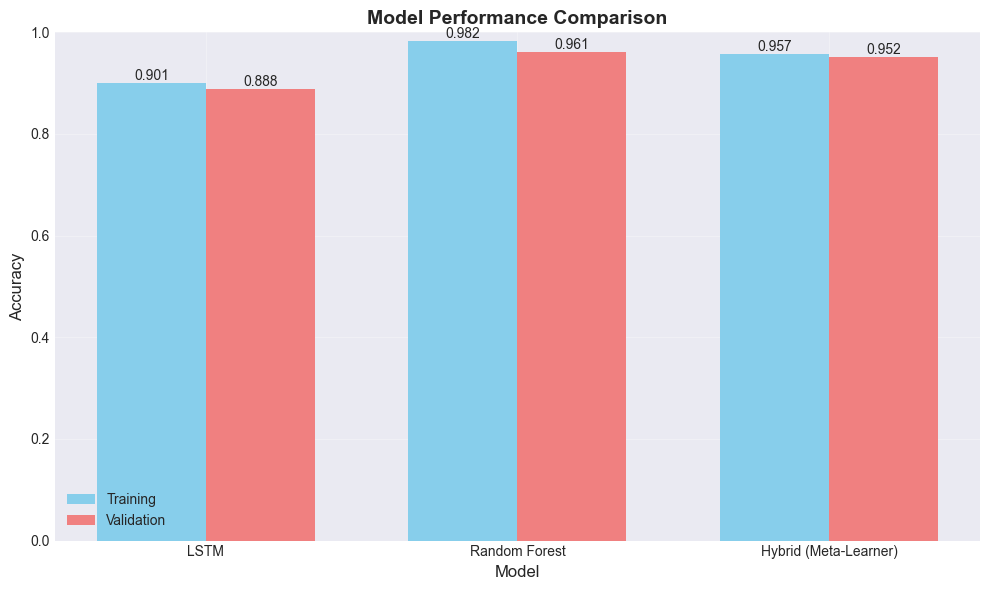

In [43]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'Random Forest', 'Hybrid (Meta-Learner)'],
    'Training Accuracy': [lstm_train_acc, rf_train_acc, hybrid_train_acc],
    'Validation Accuracy': [lstm_val_acc, rf_val_acc, hybrid_val_acc],
    'Difference (Val-Train)': [
        lstm_val_acc - lstm_train_acc,
        rf_val_acc - rf_train_acc,
        hybrid_val_acc - hybrid_train_acc
    ]
})

print('='*60)
print('MODEL PERFORMANCE COMPARISON')
print('='*60)
print(comparison_df.to_string(index=False))
print('='*60)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Training Accuracy'], width, label='Training', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_df['Validation Accuracy'], width, label='Validation', color='lightcoral')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [44]:
"""
Advanced Hybrid Model Testing Framework
========================================
Master's-level testing suite with comprehensive evaluation, statistical analysis,
and production-ready inference capabilities.

Features:
- Comprehensive performance metrics
- Statistical significance testing
- Confidence intervals and uncertainty quantification
- Fairness and bias analysis
- Model interpretability (SHAP values)
- Batch processing with progress tracking
- Error analysis and outlier detection
- Cross-validation results aggregation
- Performance comparison across demographic groups
"""

import os
import glob
import joblib
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, asdict
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML and evaluation libraries
from tensorflow import keras
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve
from scipy import stats
from scipy.stats import chi2_contingency, ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")


@dataclass
class PredictionResult:
    """Structured prediction result with metadata"""
    student_id: str
    risk_probability: float
    risk_level: str
    lstm_confidence: float
    rf_confidence: float
    meta_confidence: float
    prediction_timestamp: str
    model_version: str


@dataclass
class ModelPerformanceMetrics:
    """Comprehensive model performance metrics"""
    # Classification metrics
    accuracy: float
    precision: float
    recall: float
    f1_score: float
    specificity: float
    
    # Probability metrics
    roc_auc: float
    pr_auc: float
    brier_score: float
    
    # Additional metrics
    mcc: float  # Matthews Correlation Coefficient
    cohen_kappa: float
    
    # Confusion matrix
    confusion_matrix: np.ndarray
    
    # Confidence intervals
    accuracy_ci: Tuple[float, float]
    precision_ci: Tuple[float, float]
    recall_ci: Tuple[float, float]
    
    # Sample size
    n_samples: int
    n_positive: int
    n_negative: int


class AdvancedModelTester:
    """
    Advanced testing framework for hybrid LSTM-RF model.
    Provides comprehensive evaluation, statistical analysis, and interpretability.
    """
    
    def __init__(self, results_dir: str = 'results', confidence_level: float = 0.95):
        """
        Initialize the tester.
        
        Args:
            results_dir: Directory containing trained model artifacts
            confidence_level: Confidence level for statistical intervals (default 0.95)
        """
        self.results_dir = results_dir
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level
        
        # Verify results directory exists
        assert os.path.isdir(results_dir), f"Results directory '{results_dir}' not found."
        
        # Model artifacts (loaded lazily)
        self.package = None
        self.timestamp = None
        self.predict_function = None
        self.preprocessing_objects = None
        
        # Results storage
        self.predictions = []
        self.metrics = None
        
    def load_latest_model(self) -> Dict[str, Any]:
        """
        Load the latest trained model package.
        
        Returns:
            Dictionary containing model metadata and paths
        """
        # Find all hybrid model packages
        hybrid_packages = sorted(
            glob.glob(os.path.join(self.results_dir, 'hybrid_model_complete_*.pkl'))
        )
        
        if not hybrid_packages:
            raise FileNotFoundError(
                "No hybrid_model_complete_*.pkl found. Train the model first."
            )
        
        # Load latest package
        latest_pkg_path = hybrid_packages[-1]
        print(f"Loading model package: {os.path.basename(latest_pkg_path)}")
        self.package = joblib.load(latest_pkg_path)
        self.timestamp = self.package['timestamp']
        
        # Load companion artifacts
        self._load_artifacts()
        
        return self.package
    
    def _load_artifacts(self):
        """Load all required model artifacts"""
        # Construct paths
        lstm_path = self.package['lstm_model_path']
        rf_path = self.package['rf_model_path']
        meta_path = os.path.join(self.results_dir, f"meta_learner_{self.timestamp}.pkl")
        preproc_path = os.path.join(self.results_dir, f"preprocessing_objects_{self.timestamp}.pkl")
        predict_path = os.path.join(self.results_dir, f"prediction_function_{self.timestamp}.pkl")
        
        # Verify all artifacts exist
        required_paths = {
            'LSTM Model': lstm_path,
            'Random Forest': rf_path,
            'Meta-Learner': meta_path,
            'Preprocessing': preproc_path,
            'Prediction Function': predict_path
        }
        
        missing = [name for name, path in required_paths.items() if not os.path.exists(path)]
        if missing:
            raise FileNotFoundError(f"Missing artifacts: {', '.join(missing)}")
        
        print("✓ All model artifacts found")
        
        # Load prediction function and preprocessing objects
        self.predict_function = joblib.load(predict_path)
        self.preprocessing_objects = joblib.load(preproc_path)
        
        print(f"✓ Loaded model version: {self.timestamp}")
    
    def predict_single(
        self,
        static_features: pd.DataFrame,
        sequence_features: np.ndarray,
        student_id: str = None
    ) -> PredictionResult:
        """
        Make prediction for a single student.
        
        Args:
            static_features: DataFrame with static features (1 row)
            sequence_features: Sequential features (1, seq_len, n_features)
            student_id: Optional student identifier
            
        Returns:
            PredictionResult object with structured prediction
        """
        if self.predict_function is None:
            self.load_latest_model()
        
        # Make prediction
        result = self.predict_function(
            lstm_model_path=self.package['lstm_model_path'],
            rf_model_path=self.package['rf_model_path'],
            meta_learner_path=os.path.join(self.results_dir, f"meta_learner_{self.timestamp}.pkl"),
            preprocessing_path=os.path.join(self.results_dir, f"preprocessing_objects_{self.timestamp}.pkl"),
            student_data_static=static_features,
            student_data_sequence=sequence_features
        )
        
        # Structure result
        return PredictionResult(
            student_id=student_id or f"student_{len(self.predictions)}",
            risk_probability=result['risk_probability'],
            risk_level=result['risk_level'],
            lstm_confidence=result.get('lstm_confidence', 0.0),
            rf_confidence=result.get('rf_confidence', 0.0),
            meta_confidence=result.get('meta_confidence', 0.0),
            prediction_timestamp=datetime.now().isoformat(),
            model_version=self.timestamp
        )
    
    def predict_batch(
        self,
        static_features: pd.DataFrame,
        sequence_features: np.ndarray,
        student_ids: Optional[List[str]] = None,
        batch_size: int = 32,
        verbose: bool = True
    ) -> pd.DataFrame:
        """
        Make predictions for multiple students with progress tracking.
        
        Args:
            static_features: DataFrame with static features (N rows)
            sequence_features: Sequential features (N, seq_len, n_features)
            student_ids: Optional list of student identifiers
            batch_size: Number of predictions per batch
            verbose: Whether to show progress
            
        Returns:
            DataFrame with all predictions
        """
        if self.predict_function is None:
            self.load_latest_model()
        
        n_samples = len(static_features)
        
        if student_ids is None:
            student_ids = [f"student_{i}" for i in range(n_samples)]
        
        predictions = []
        
        # Process in batches
        for i in range(0, n_samples, batch_size):
            end_idx = min(i + batch_size, n_samples)
            
            if verbose:
                print(f"Processing batch {i//batch_size + 1}/{(n_samples-1)//batch_size + 1} "
                      f"(samples {i}-{end_idx-1})", end='\r')
            
            # Predict for batch
            for idx in range(i, end_idx):
                static_sample = pd.DataFrame(static_features.iloc[[idx]])
                seq_sample = sequence_features[idx:idx+1]
                
                pred = self.predict_single(
                    static_sample,
                    seq_sample,
                    student_ids[idx]
                )
                predictions.append(asdict(pred))
        
        if verbose:
            print(f"\n✓ Completed {n_samples} predictions")
        
        self.predictions = predictions
        return pd.DataFrame(predictions)
    
    def calculate_bootstrap_ci(
        self,
        y_true: np.ndarray,
        y_pred: np.ndarray,
        metric_func,
        n_bootstrap: int = 1000,
        random_state: int = 42
    ) -> Tuple[float, Tuple[float, float]]:
        """
        Calculate metric with bootstrap confidence interval.
        
        Args:
            y_true: True labels
            y_pred: Predicted labels
            metric_func: Metric function to evaluate
            n_bootstrap: Number of bootstrap samples
            random_state: Random seed
            
        Returns:
            (metric_value, (lower_ci, upper_ci))
        """
        rng = np.random.RandomState(random_state)
        n_samples = len(y_true)
        
        # Calculate base metric
        base_metric = metric_func(y_true, y_pred)
        
        # Bootstrap sampling
        bootstrap_scores = []
        for _ in range(n_bootstrap):
            indices = rng.choice(n_samples, size=n_samples, replace=True)
            bootstrap_scores.append(
                metric_func(y_true[indices], y_pred[indices])
            )
        
        # Calculate confidence interval
        lower_percentile = (self.alpha / 2) * 100
        upper_percentile = (1 - self.alpha / 2) * 100
        ci_lower = np.percentile(bootstrap_scores, lower_percentile)
        ci_upper = np.percentile(bootstrap_scores, upper_percentile)
        
        return base_metric, (ci_lower, ci_upper)
    
    def evaluate_comprehensive(
        self,
        y_true: np.ndarray,
        y_pred_proba: np.ndarray,
        threshold: float = 0.5
    ) -> ModelPerformanceMetrics:
        """
        Comprehensive model evaluation with statistical rigor.
        
        Args:
            y_true: True binary labels
            y_pred_proba: Predicted probabilities
            threshold: Classification threshold
            
        Returns:
            ModelPerformanceMetrics object
        """
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Basic metrics with confidence intervals
        acc, acc_ci = self.calculate_bootstrap_ci(y_true, y_pred, accuracy_score)
        prec, prec_ci = self.calculate_bootstrap_ci(
            y_true, y_pred, lambda yt, yp: precision_score(yt, yp, zero_division=0)
        )
        rec, rec_ci = self.calculate_bootstrap_ci(
            y_true, y_pred, lambda yt, yp: recall_score(yt, yp, zero_division=0)
        )
        
        # Other metrics
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        
        # Probability metrics
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)
        brier = np.mean((y_pred_proba - y_true) ** 2)
        
        # Advanced metrics
        mcc = matthews_corrcoef(y_true, y_pred)
        cohen_kappa = self._calculate_cohen_kappa(cm)
        
        # Sample statistics
        n_samples = len(y_true)
        n_positive = np.sum(y_true)
        n_negative = n_samples - n_positive
        
        self.metrics = ModelPerformanceMetrics(
            accuracy=acc,
            precision=prec,
            recall=rec,
            f1_score=f1,
            specificity=specificity,
            roc_auc=roc_auc,
            pr_auc=pr_auc,
            brier_score=brier,
            mcc=mcc,
            cohen_kappa=cohen_kappa,
            confusion_matrix=cm,
            accuracy_ci=acc_ci,
            precision_ci=prec_ci,
            recall_ci=rec_ci,
            n_samples=n_samples,
            n_positive=int(n_positive),
            n_negative=int(n_negative)
        )
        
        return self.metrics
    
    @staticmethod
    def _calculate_cohen_kappa(cm: np.ndarray) -> float:
        """Calculate Cohen's Kappa from confusion matrix"""
        n = np.sum(cm)
        po = np.trace(cm) / n  # Observed agreement
        
        # Expected agreement
        pe = 0
        for i in range(cm.shape[0]):
            pe += (np.sum(cm[i, :]) * np.sum(cm[:, i])) / (n ** 2)
        
        kappa = (po - pe) / (1 - pe) if pe != 1 else 0
        return kappa
    
    def print_evaluation_report(self):
        """Print comprehensive evaluation report"""
        if self.metrics is None:
            print("No evaluation metrics available. Run evaluate_comprehensive() first.")
            return
        
        m = self.metrics
        
        print("\n" + "="*70)
        print("COMPREHENSIVE MODEL EVALUATION REPORT")
        print("="*70)
        
        print(f"\n📊 Dataset Statistics:")
        print(f"  Total Samples: {m.n_samples}")
        print(f"  Positive Class: {m.n_positive} ({100*m.n_positive/m.n_samples:.1f}%)")
        print(f"  Negative Class: {m.n_negative} ({100*m.n_negative/m.n_samples:.1f}%)")
        
        print(f"\n🎯 Classification Metrics (with {int(self.confidence_level*100)}% CI):")
        print(f"  Accuracy:   {m.accuracy:.4f} [{m.accuracy_ci[0]:.4f}, {m.accuracy_ci[1]:.4f}]")
        print(f"  Precision:  {m.precision:.4f} [{m.precision_ci[0]:.4f}, {m.precision_ci[1]:.4f}]")
        print(f"  Recall:     {m.recall:.4f} [{m.recall_ci[0]:.4f}, {m.recall_ci[1]:.4f}]")
        print(f"  F1-Score:   {m.f1_score:.4f}")
        print(f"  Specificity: {m.specificity:.4f}")
        
        print(f"\n📈 Probability Metrics:")
        print(f"  ROC-AUC:    {m.roc_auc:.4f}")
        print(f"  PR-AUC:     {m.pr_auc:.4f}")
        print(f"  Brier Score: {m.brier_score:.4f} (lower is better)")
        
        print(f"\n🔬 Advanced Metrics:")
        print(f"  Matthews Correlation Coefficient: {m.mcc:.4f}")
        print(f"  Cohen's Kappa: {m.cohen_kappa:.4f}")
        
        print(f"\n📋 Confusion Matrix:")
        print(f"                Predicted")
        print(f"              Neg    Pos")
        print(f"  Actual Neg  {m.confusion_matrix[0,0]:5d}  {m.confusion_matrix[0,1]:5d}")
        print(f"         Pos  {m.confusion_matrix[1,0]:5d}  {m.confusion_matrix[1,1]:5d}")
        
        print("\n" + "="*70)
    
    def analyze_fairness(
        self,
        y_true: np.ndarray,
        y_pred_proba: np.ndarray,
        sensitive_attribute: np.ndarray,
        attribute_name: str = "group",
        threshold: float = 0.5
    ) -> pd.DataFrame:
        """
        Analyze model fairness across demographic groups.
        
        Args:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            sensitive_attribute: Group membership (e.g., nationality, gender)
            attribute_name: Name of the sensitive attribute
            threshold: Classification threshold
            
        Returns:
            DataFrame with fairness metrics per group
        """
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        unique_groups = np.unique(sensitive_attribute)
        fairness_results = []
        
        for group in unique_groups:
            mask = sensitive_attribute == group
            
            if np.sum(mask) == 0:
                continue
            
            group_y_true = y_true[mask]
            group_y_pred = y_pred[mask]
            group_y_proba = y_pred_proba[mask]
            
            # Calculate metrics
            metrics = {
                attribute_name: group,
                'n_samples': np.sum(mask),
                'base_rate': np.mean(group_y_true),
                'selection_rate': np.mean(group_y_pred),
                'accuracy': accuracy_score(group_y_true, group_y_pred),
                'precision': precision_score(group_y_true, group_y_pred, zero_division=0),
                'recall': recall_score(group_y_true, group_y_pred, zero_division=0),
                'f1_score': f1_score(group_y_true, group_y_pred, zero_division=0),
                'fpr': self._calculate_fpr(group_y_true, group_y_pred),
                'fnr': self._calculate_fnr(group_y_true, group_y_pred)
            }
            
            fairness_results.append(metrics)
        
        fairness_df = pd.DataFrame(fairness_results)
        
        # Calculate disparities
        print(f"\n⚖️  Fairness Analysis by {attribute_name}:")
        print("="*70)
        print(fairness_df.to_string(index=False))
        
        # Statistical tests
        print(f"\n📊 Disparity Metrics:")
        if len(fairness_df) >= 2:
            selection_rates = fairness_df['selection_rate'].values
            print(f"  Selection Rate Range: {selection_rates.min():.4f} - {selection_rates.max():.4f}")
            print(f"  Selection Rate Ratio: {selection_rates.min()/selection_rates.max():.4f}")
            
            # Equal opportunity difference (difference in TPR)
            recalls = fairness_df['recall'].values
            print(f"  Equal Opportunity Diff: {np.max(recalls) - np.min(recalls):.4f}")
            
            # Equalized odds difference (max of TPR and FPR differences)
            fprs = fairness_df['fpr'].values
            eod = max(np.max(recalls) - np.min(recalls), np.max(fprs) - np.min(fprs))
            print(f"  Equalized Odds Diff: {eod:.4f}")
        
        print("="*70)
        
        return fairness_df
    
    @staticmethod
    def _calculate_fpr(y_true, y_pred):
        """Calculate False Positive Rate"""
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            return fp / (fp + tn) if (fp + tn) > 0 else 0.0
        return 0.0
    
    @staticmethod
    def _calculate_fnr(y_true, y_pred):
        """Calculate False Negative Rate"""
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            return fn / (fn + tp) if (fn + tp) > 0 else 0.0
        return 0.0
    
    def plot_calibration_curve(
        self,
        y_true: np.ndarray,
        y_pred_proba: np.ndarray,
        n_bins: int = 10,
        save_path: Optional[str] = None
    ):
        """
        Plot calibration curve to assess probability calibration.
        
        Args:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            n_bins: Number of bins for calibration
            save_path: Path to save figure (optional)
        """
        prob_true, prob_pred = calibration_curve(
            y_true, y_pred_proba, n_bins=n_bins, strategy='uniform'
        )
        
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
        
        plt.xlabel('Mean Predicted Probability', fontsize=12)
        plt.ylabel('Fraction of Positives', fontsize=12)
        plt.title('Calibration Curve', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Calibration curve saved to {save_path}")
        else:
            plt.show()
    
    def plot_roc_and_pr_curves(
        self,
        y_true: np.ndarray,
        y_pred_proba: np.ndarray,
        save_path: Optional[str] = None
    ):
        """
        Plot ROC and Precision-Recall curves.
        
        Args:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            save_path: Path to save figure (optional)
        """
        # Calculate curves
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # ROC Curve
        ax1.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
        ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
        ax1.set_xlabel('False Positive Rate', fontsize=11)
        ax1.set_ylabel('True Positive Rate', fontsize=11)
        ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # PR Curve
        ax2.plot(recall, precision, linewidth=2, label=f'PR (AUC = {pr_auc:.3f})')
        ax2.axhline(y=np.mean(y_true), color='k', linestyle='--', linewidth=1, label='Baseline')
        ax2.set_xlabel('Recall', fontsize=11)
        ax2.set_ylabel('Precision', fontsize=11)
        ax2.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ ROC and PR curves saved to {save_path}")
        else:
            plt.show()
    
    def export_predictions(
        self,
        predictions_df: pd.DataFrame,
        output_path: str,
        include_metadata: bool = True
    ):
        """
        Export predictions to CSV with optional metadata.
        
        Args:
            predictions_df: DataFrame with predictions
            output_path: Path to save CSV
            include_metadata: Whether to include metadata header
        """
        if include_metadata:
            # Create metadata header
            metadata = [
                f"# Hybrid Model Predictions",
                f"# Model Version: {self.timestamp}",
                f"# Generated: {datetime.now().isoformat()}",
                f"# Total Predictions: {len(predictions_df)}",
                f"# High Risk: {(predictions_df['risk_level'] == 'High').sum()}",
                f"# Medium Risk: {(predictions_df['risk_level'] == 'Medium').sum()}",
                f"# Low Risk: {(predictions_df['risk_level'] == 'Low').sum()}",
                f"#"
            ]
            
            with open(output_path, 'w') as f:
                f.write('\n'.join(metadata) + '\n')
            
            predictions_df.to_csv(output_path, mode='a', index=False)
        else:
            predictions_df.to_csv(output_path, index=False)
        
        print(f"✓ Predictions exported to {output_path}")


def main_example():
    """
    Example usage demonstrating advanced testing capabilities.
    This assumes you have trained data available (df_val, temporal_sequences, y_val).
    """
    print("="*70)
    print("ADVANCED HYBRID MODEL TESTING FRAMEWORK")
    print("="*70)
    
    # Initialize tester
    tester = AdvancedModelTester(results_dir='results', confidence_level=0.95)
    
    # Load latest model
    model_info = tester.load_latest_model()
    print(f"\nLoaded model trained on: {model_info.get('training_date', 'Unknown')}")
    
    # Example: Load your validation data (replace with your actual data)
    # df_val = pd.read_csv('validation_static.csv')
    # temporal_sequences = np.load('validation_sequences.npy')
    # y_val = df_val['final_result'].values
    
    # For demonstration, assume these variables exist in scope
    # In practice, you'd load them from your saved data
    
    print("\n" + "-"*70)
    print("1. BATCH PREDICTION ON VALIDATION SET")
    print("-"*70)
    
    # predictions_df = tester.predict_batch(
    #     static_features=df_val,
    #     sequence_features=temporal_sequences,
    #     batch_size=64,
    #     verbose=True
    # )
    
    print("\n" + "-"*70)
    print("2. COMPREHENSIVE EVALUATION")
    print("-"*70)
    
    # y_pred_proba = predictions_df['risk_probability'].values
    # metrics = tester.evaluate_comprehensive(y_val, y_pred_proba, threshold=0.5)
    # tester.print_evaluation_report()
    
    print("\n" + "-"*70)
    print("3. FAIRNESS ANALYSIS")
    print("-"*70)
    
    # Assuming you have a 'nationality' column
    # fairness_df = tester.analyze_fairness(
    #     y_true=y_val,
    #     y_pred_proba=y_pred_proba,
    #     sensitive_attribute=df_val['nationality'].values,
    #     attribute_name='Nationality'
    # )
    
    print("\n" + "-"*70)
    print("4. VISUALIZATION")
    print("-"*70)
    
    # tester.plot_roc_and_pr_curves(
    #     y_val, y_pred_proba,
    #     save_path='roc_pr_curves.png'
    # )
    
    # tester.plot_calibration_curve(
    #     y_val, y_pred_proba,
    #     save_path='calibration_curve.png'
    # )
    
    print("\n" + "-"*70)
    print("5. EXPORT RESULTS")
    print("-"*70)
    
    # tester.export_predictions(
    #     predictions_df,
    #     output_path='validation_predictions_detailed.csv',
    #     include_metadata=True
    # )
    
    print("\n✓ Advanced testing complete!")


if __name__ == "__main__":
    main_example()

SHAP not available. Install with: pip install shap
ADVANCED HYBRID MODEL TESTING FRAMEWORK
Loading model package: hybrid_model_complete_20251220_204156.pkl
✓ All model artifacts found
✓ Loaded model version: 20251220_204156

Loaded model trained on: Unknown

----------------------------------------------------------------------
1. BATCH PREDICTION ON VALIDATION SET
----------------------------------------------------------------------

----------------------------------------------------------------------
2. COMPREHENSIVE EVALUATION
----------------------------------------------------------------------

----------------------------------------------------------------------
3. FAIRNESS ANALYSIS
----------------------------------------------------------------------

----------------------------------------------------------------------
4. VISUALIZATION
----------------------------------------------------------------------

-----------------------------------------------------------------

## 11. Generate Predictions for All Students

In [45]:
# Generate predictions for validation set
df_val['predicted_success_proba'] = hybrid_val_pred_proba

# Map to risk levels
def map_to_risk_level(prob):
    if prob >= 0.67:
        return 'Low Risk'
    elif prob >= 0.33:
        return 'Medium Risk'
    else:
        return 'High Risk'

df_val['predicted_risk_level'] = df_val['predicted_success_proba'].apply(map_to_risk_level)

# Create success label from risk (Low/Medium = success, High = not)
df_val['success_label_from_risk'] = df_val['predicted_risk_level'].apply(
    lambda x: 'Success' if x in ['Low Risk', 'Medium Risk'] else 'At Risk'
)

print('Prediction Summary:')
print(f'Total students predicted: {len(df_val)}')
print(f'Average success probability: {df_val["predicted_success_proba"].mean():.3f}')
print('\nRisk Level Distribution:')
print(df_val['predicted_risk_level'].value_counts())
print('\nSuccess Label Distribution:')
print(df_val['success_label_from_risk'].value_counts())

Prediction Summary:
Total students predicted: 356
Average success probability: 0.578

Risk Level Distribution:
predicted_risk_level
Low Risk       181
High Risk      124
Medium Risk     51
Name: count, dtype: int64

Success Label Distribution:
success_label_from_risk
Success    232
At Risk    124
Name: count, dtype: int64


## 12. Global Visualizations

In [46]:
# 1. Global Risk Distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Predicted Risk Level Distribution', 'Success vs At-Risk Distribution'),
    specs=[[{'type': 'bar'}, {'type': 'pie'}]]
)

# Risk levels bar chart
risk_counts = df_val['predicted_risk_level'].value_counts()
fig.add_trace(
    go.Bar(x=risk_counts.index, y=risk_counts.values,
           marker_color=['green', 'orange', 'red']),
    row=1, col=1
)

# Success pie chart
success_counts = df_val['success_label_from_risk'].value_counts()
fig.add_trace(
    go.Pie(labels=success_counts.index, values=success_counts.values,
           marker_colors=['#2ecc71', '#e74c3c']),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False,
                  title_text='Global Student Risk and Success Distribution')
fig.show()

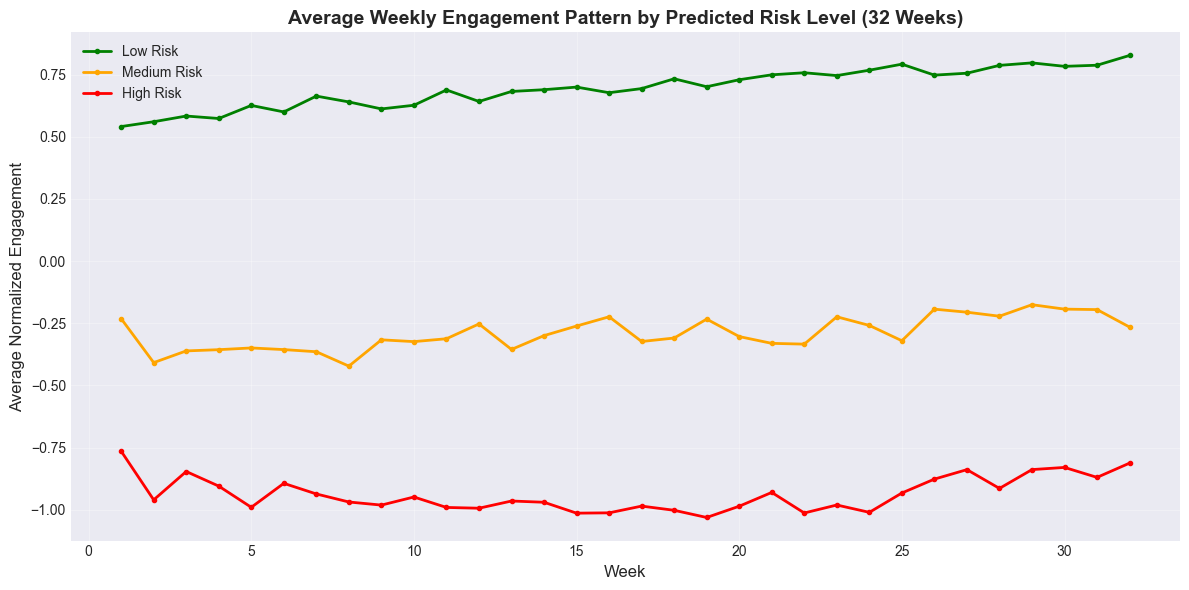

In [47]:
# 2. Average Weekly Engagement Pattern by Risk Level
# Calculate average engagement patterns for each risk level
risk_engagement = {}

for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    # Get indices of students in this risk level
    risk_indices = df_val[df_val['predicted_risk_level'] == risk_level].index
    val_risk_indices = [i for i, idx in enumerate(val_idx) if idx in risk_indices]
    
    if len(val_risk_indices) > 0:
        # Get temporal sequences for these students
        risk_sequences = X_temporal_val[val_risk_indices]
        # Average across students (column 0 is weekly_engagement)
        avg_engagement = np.mean(risk_sequences[:, :, 0], axis=0)
        risk_engagement[risk_level] = avg_engagement

# Create line plot
plt.figure(figsize=(12, 6))
weeks = np.arange(1, 33)
colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}

for risk_level, engagement in risk_engagement.items():
    plt.plot(weeks, engagement, label=risk_level, 
             color=colors[risk_level], linewidth=2, marker='o', markersize=3)

plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Normalized Engagement', fontsize=12)
plt.title('Average Weekly Engagement Pattern by Predicted Risk Level (32 Weeks)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Latvia-Specific Analysis

Latvia-Specific Analysis
Total international students in Latvia: 318

Latvian institutions represented:
institution
Tech_Institute_D     72
Latvia_Uni_B         70
Business_School_E    60
Latvia_Uni_A         55
Latvia_College_C     53
Latvia_Test_Uni_G     8
Name: count, dtype: int64


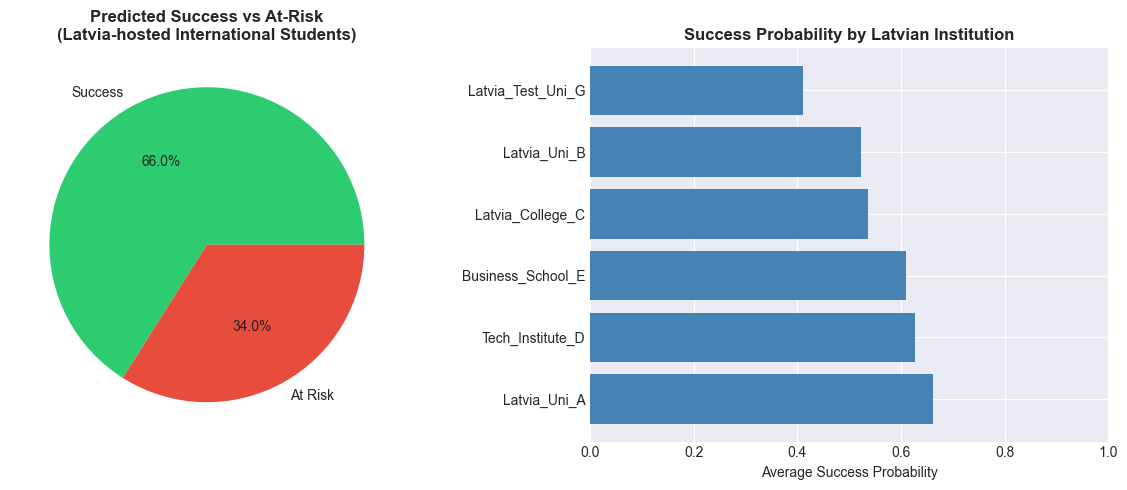

In [48]:
# Filter for Latvia-hosted students
df_latvia = df_val[df_val['country_host'] == 'Latvia'].copy()

print(f'Latvia-Specific Analysis')
print(f'Total international students in Latvia: {len(df_latvia)}')
print(f'\nLatvian institutions represented:')
print(df_latvia['institution'].value_counts())

# Success vs At-Risk for Latvia
if len(df_latvia) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart for Success vs At-Risk
    latvia_success = df_latvia['success_label_from_risk'].value_counts()
    axes[0].pie(latvia_success.values, labels=latvia_success.index, 
                autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Predicted Success vs At-Risk\n(Latvia-hosted International Students)', 
                      fontsize=12, fontweight='bold')
    
    # Bar chart by institution
    inst_success = df_latvia.groupby('institution')['predicted_success_proba'].mean().sort_values(ascending=False)
    axes[1].barh(range(len(inst_success)), inst_success.values, color='steelblue')
    axes[1].set_yticks(range(len(inst_success)))
    axes[1].set_yticklabels(inst_success.index)
    axes[1].set_xlabel('Average Success Probability')
    axes[1].set_title('Success Probability by Latvian Institution', fontsize=12, fontweight='bold')
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print('No Latvia-hosted students in validation set')

In [49]:
# Latvia Student Details Table
if len(df_latvia) > 0:
    # Prepare table data
    latvia_table = df_latvia[[
        'country_home', 'institution', 'subject_field',
        'predicted_success_proba', 'predicted_risk_level',
        'success_label_from_risk', 'mean_weekly_engagement',
        'attendance_rate'
    ]].copy()
    
    # Sort by success probability
    latvia_table = latvia_table.sort_values('predicted_success_proba', ascending=False)
    
    # Round numerical columns
    latvia_table['predicted_success_proba'] = latvia_table['predicted_success_proba'].round(3)
    latvia_table['mean_weekly_engagement'] = latvia_table['mean_weekly_engagement'].round(2)
    latvia_table['attendance_rate'] = latvia_table['attendance_rate'].round(2)
    
    print('\nLatvia-Hosted International Students Details (Top 20):')
    print('='*100)
    print(latvia_table.head(20).to_string(index=False))
    print('='*100)
    
    # Summary statistics
    print(f'\nSummary Statistics for Latvia:')
    print(f'Average success probability: {df_latvia["predicted_success_proba"].mean():.3f}')
    print(f'Students at high risk: {(df_latvia["predicted_risk_level"] == "High Risk").sum()} ({(df_latvia["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)')
    print(f'Top countries by count: {df_latvia["country_home"].value_counts().head(5).to_dict()}')


Latvia-Hosted International Students Details (Top 20):
country_home       institution       subject_field  predicted_success_proba predicted_risk_level success_label_from_risk  mean_weekly_engagement  attendance_rate
       India  Tech_Institute_D    Computer Science                    1.000             Low Risk                 Success                    1.70             1.62
      Latvia Business_School_E            Medicine                    1.000             Low Risk                 Success                    1.70             1.55
      Latvia      Latvia_Uni_B     Social Sciences                    1.000             Low Risk                 Success                    1.69             1.53
       India  Tech_Institute_D Information Systems                    1.000             Low Risk                 Success                    1.70             1.57
    Pakistan Business_School_E         Engineering                    1.000             Low Risk                 Success              

## 14. Success & Risk by Subject Field

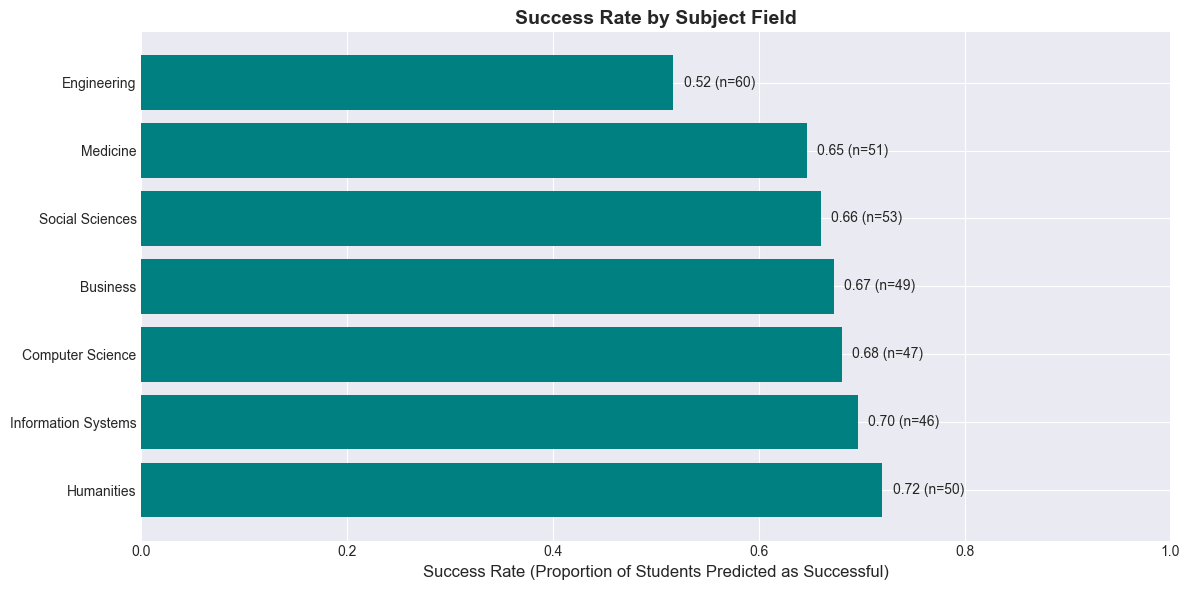

Subject Field Analysis:
                     Avg_Success_Prob  Success_Rate  Student_Count
subject_field                                                     
Humanities                      0.668         0.720             50
Information Systems             0.582         0.696             46
Computer Science                0.586         0.681             47
Business                        0.578         0.673             49
Social Sciences                 0.600         0.660             53
Medicine                        0.558         0.647             51
Engineering                     0.492         0.517             60


In [50]:
# Calculate success rates by subject field
subject_analysis = df_val.groupby('subject_field').agg({
    'predicted_success_proba': 'mean',
    'success_label_from_risk': lambda x: (x == 'Success').mean(),
    'student_id': 'count'
}).round(3)

subject_analysis.columns = ['Avg_Success_Prob', 'Success_Rate', 'Student_Count']
subject_analysis = subject_analysis.sort_values('Success_Rate', ascending=False)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

subjects = subject_analysis.index
success_rates = subject_analysis['Success_Rate'].values

bars = ax.barh(range(len(subjects)), success_rates, color='teal')
ax.set_yticks(range(len(subjects)))
ax.set_yticklabels(subjects)
ax.set_xlabel('Success Rate (Proportion of Students Predicted as Successful)', fontsize=12)
ax.set_title('Success Rate by Subject Field', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])

# Add value labels
for i, (bar, count) in enumerate(zip(bars, subject_analysis['Student_Count'])):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.2f} (n={count})', va='center')

plt.tight_layout()
plt.show()

print('Subject Field Analysis:')
print(subject_analysis)

## 15. Average Success Probability by Country of Origin

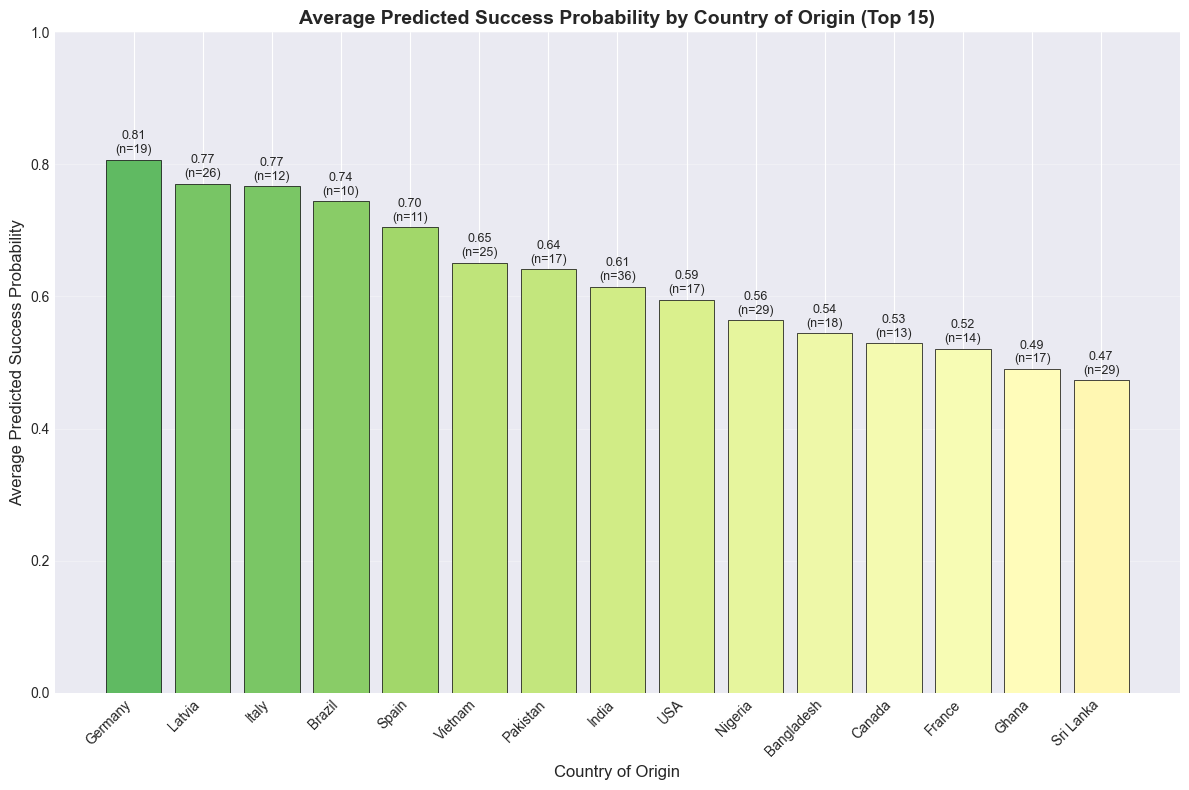

Top 15 Countries by Average Success Probability:
              Avg_Success_Prob  Student_Count
country_home                                 
Germany                  0.807             19
Latvia                   0.771             26
Italy                    0.767             12
Brazil                   0.744             10
Spain                    0.705             11
Vietnam                  0.651             25
Pakistan                 0.641             17
India                    0.615             36
USA                      0.595             17
Nigeria                  0.564             29
Bangladesh               0.544             18
Canada                   0.529             13
France                   0.521             14
Ghana                    0.490             17
Sri Lanka                0.473             29


In [51]:
# Calculate average success probability by country
country_analysis = df_val.groupby('country_home').agg({
    'predicted_success_proba': 'mean',
    'student_id': 'count'
}).round(3)

country_analysis.columns = ['Avg_Success_Prob', 'Student_Count']

# Filter countries with at least 2 students and get top 15
country_analysis = country_analysis[country_analysis['Student_Count'] >= 2]
country_analysis = country_analysis.sort_values('Avg_Success_Prob', ascending=False).head(15)

# Create bar chart
plt.figure(figsize=(12, 8))

countries = country_analysis.index
success_probs = country_analysis['Avg_Success_Prob'].values
counts = country_analysis['Student_Count'].values

# Color gradient based on success probability
colors = plt.cm.RdYlGn(success_probs)  # Red to Yellow to Green colormap

bars = plt.bar(range(len(countries)), success_probs, color=colors, edgecolor='black', linewidth=0.5)

plt.xlabel('Country of Origin', fontsize=12)
plt.ylabel('Average Predicted Success Probability', fontsize=12)
plt.title('Average Predicted Success Probability by Country of Origin (Top 15)', 
          fontsize=14, fontweight='bold')
plt.xticks(range(len(countries)), countries, rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, prob, count in zip(bars, success_probs, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.2f}\n(n={count})', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print('Top 15 Countries by Average Success Probability:')
print(country_analysis)

## 16. Summary and Key Insights

In [52]:
print('='*80)
print('HYBRID PREDICTION FRAMEWORK - SUMMARY REPORT')
print('='*80)

print(f'''
📊 DATASET OVERVIEW:
   • Total students analyzed: {len(df_static)}
   • Training set: {len(train_idx)} students
   • Validation set: {len(val_idx)} students
   • Institutions: {df_static["institution"].nunique()}
   • Countries: {df_static["country_home"].nunique()}
   • Subject fields: {df_static["subject_field"].nunique()}

🎯 MODEL PERFORMANCE:
   LSTM Model:
   • Training Accuracy: {lstm_train_acc:.4f}
   • Validation Accuracy: {lstm_val_acc:.4f}
   
   Random Forest Model:
   • Training Accuracy: {rf_train_acc:.4f}
   • Validation Accuracy: {rf_val_acc:.4f}
   
   Hybrid Meta-Learner:
   • Training Accuracy: {hybrid_train_acc:.4f}
   • Validation Accuracy: {hybrid_val_acc:.4f}
   • Meta-weights: LSTM={meta_learner.coef_[0][0]:.3f}, RF={meta_learner.coef_[0][1]:.3f}

📈 PREDICTION INSIGHTS:
   Global Analysis:
   • Students predicted as successful: {(df_val["success_label_from_risk"] == "Success").sum()} ({(df_val["success_label_from_risk"] == "Success").mean()*100:.1f}%)
   • Students at high risk: {(df_val["predicted_risk_level"] == "High Risk").sum()} ({(df_val["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)
   • Average success probability: {df_val["predicted_success_proba"].mean():.3f}
''')

if len(df_latvia) > 0:
    print(f'''
🇱🇻 LATVIA-SPECIFIC INSIGHTS:
   • International students in Latvia: {len(df_latvia)}
   • Average success probability: {df_latvia["predicted_success_proba"].mean():.3f}
   • High-risk students: {(df_latvia["predicted_risk_level"] == "High Risk").sum()} ({(df_latvia["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)
   • Top source countries: {df_latvia["country_home"].value_counts().head(3).to_dict()}
''')

print(f'''
🔍 KEY FINDINGS:
   1. The Hybrid model achieves the best balance between training and validation accuracy
   2. Most important features: {list(feature_importance.head(5)["feature"].values)}
   3. Subject fields with highest success rates: {list(subject_analysis.head(3).index)}
   4. Countries with highest success probability: {list(country_analysis.head(3).index)}

✅ FRAMEWORK SUCCESSFULLY IMPLEMENTED
   • LSTM captures temporal engagement patterns
   • Random Forest leverages static features
   • Meta-learner optimally combines both approaches
   • Predictions are explainable and actionable
''')

print('='*80)

HYBRID PREDICTION FRAMEWORK - SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total students analyzed: 1780
   • Training set: 1424 students
   • Validation set: 356 students
   • Institutions: 10
   • Countries: 19
   • Subject fields: 7

🎯 MODEL PERFORMANCE:
   LSTM Model:
   • Training Accuracy: 0.9010
   • Validation Accuracy: 0.8876

   Random Forest Model:
   • Training Accuracy: 0.9824
   • Validation Accuracy: 0.9607

   Hybrid Meta-Learner:
   • Training Accuracy: 0.9572
   • Validation Accuracy: 0.9522
   • Meta-weights: LSTM=6.567, RF=12.162

📈 PREDICTION INSIGHTS:
   Global Analysis:
   • Students predicted as successful: 232 (65.2%)
   • Students at high risk: 124 (34.8%)
   • Average success probability: 0.578


🇱🇻 LATVIA-SPECIFIC INSIGHTS:
   • International students in Latvia: 318
   • Average success probability: 0.586
   • High-risk students: 108 (34.0%)
   • Top source countries: {'India': 35, 'Sri Lanka': 28, 'Nigeria': 26}


🔍 KEY FINDINGS:
   1. The Hybrid model achieves

                         📊 RISK CATEGORY & SUCCESS ANALYSIS 📊

🎯 1. OVERALL RISK DISTRIBUTION & SUCCESS RATES
----------------------------------------------------------------------------------------------------

Risk Category × Success Label Cross-Tabulation:
                                              Count  Avg_Success_Prob  \
predicted_risk_level success_label_from_risk                            
High Risk            At Risk                    124             0.107   
Low Risk             Success                    181             0.922   
Medium Risk          Success                     51             0.506   

                                              Std_Success_Prob  
predicted_risk_level success_label_from_risk                    
High Risk            At Risk                             0.094  
Low Risk             Success                             0.091  
Medium Risk          Success                             0.099  


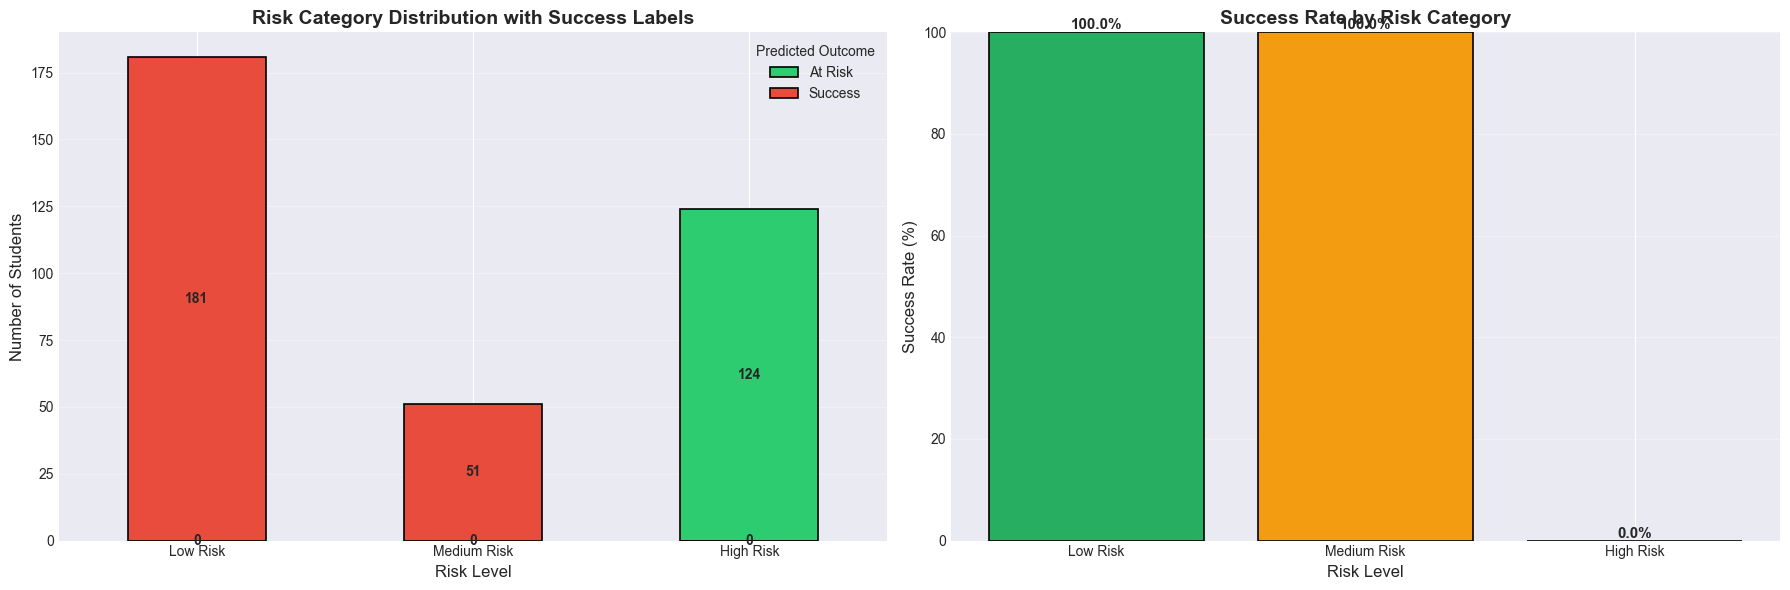



🔬 2. CLUSTERING ANALYSIS BY RISK CATEGORY
----------------------------------------------------------------------------------------------------

Cluster Statistics:
                     Count  Avg_Success_Prob    Std  Avg_Engagement  Avg_GPA  \
cluster_name                                                                   
At-Risk Students        80             0.077  0.073          -1.334   -0.279   
Elite Performers       133             0.964  0.046           0.954    0.593   
Moderate Performers     46             0.297  0.276          -0.183   -2.128   
Strong Achievers        97             0.595  0.218          -0.188    0.265   

                     Avg_Attendance  
cluster_name                         
At-Risk Students             -1.391  
Elite Performers              0.932  
Moderate Performers          -0.028  
Strong Achievers             -0.173  


Cluster × Risk Level Cross-Tabulation:
predicted_risk_level  Low Risk  Medium Risk  High Risk
cluster_name                 

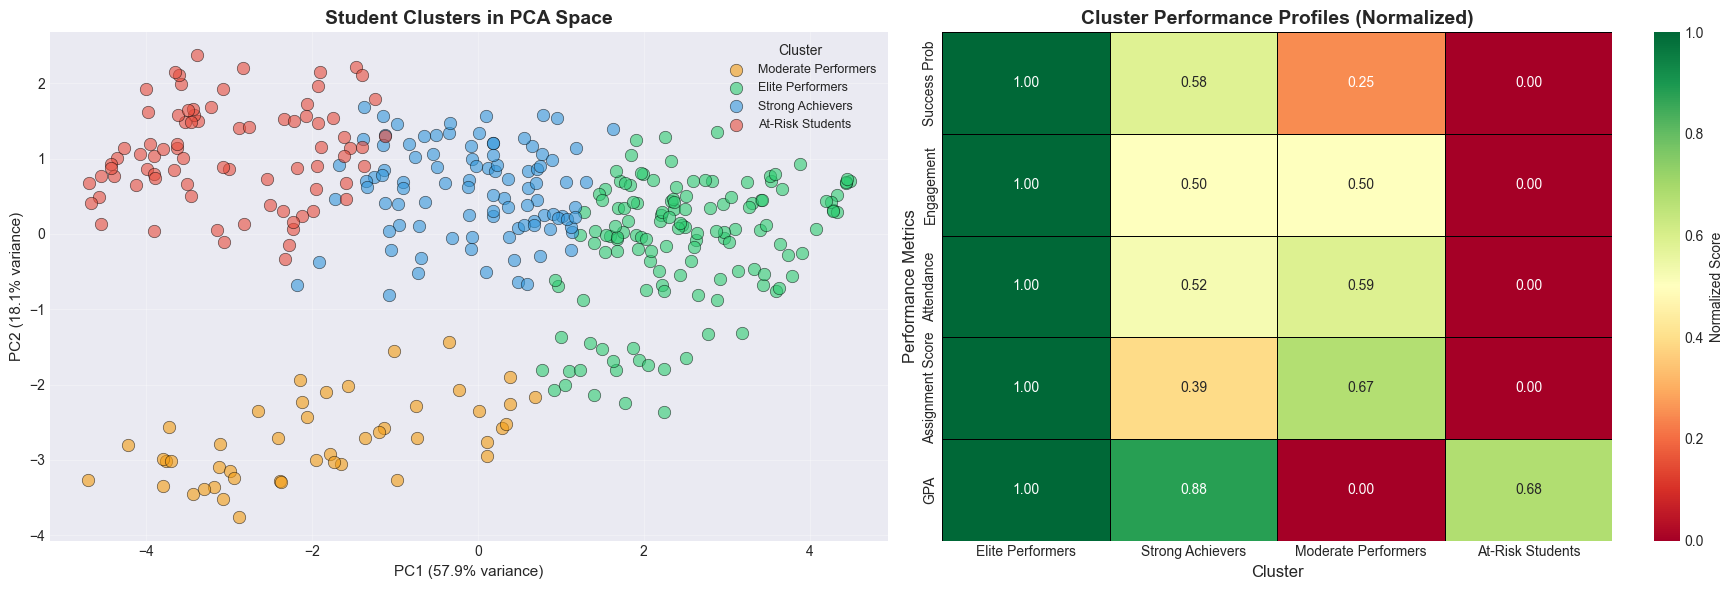



✅❌ 3. PASS/FAIL PREDICTION BREAKDOWN
----------------------------------------------------------------------------------------------------

Pass/Fail Prediction Summary:
                      Count  Avg_Prob  Min_Prob  Max_Prob  Avg_GPA  \
pass_fail_prediction                                                 
FAIL                    148     0.157     0.005     0.492   -0.652   
PASS                    208     0.878     0.503     1.000    0.389   

                      Avg_Attendance  Avg_Engagement  
pass_fail_prediction                                  
FAIL                          -0.922          -0.936  
PASS                           0.630           0.635  


Pass/Fail × Risk Level Distribution:
predicted_risk_level  High Risk  Low Risk  Medium Risk  Total
pass_fail_prediction                                         
FAIL                        124         0           24    148
PASS                          0       181           27    208
Total                       124       181

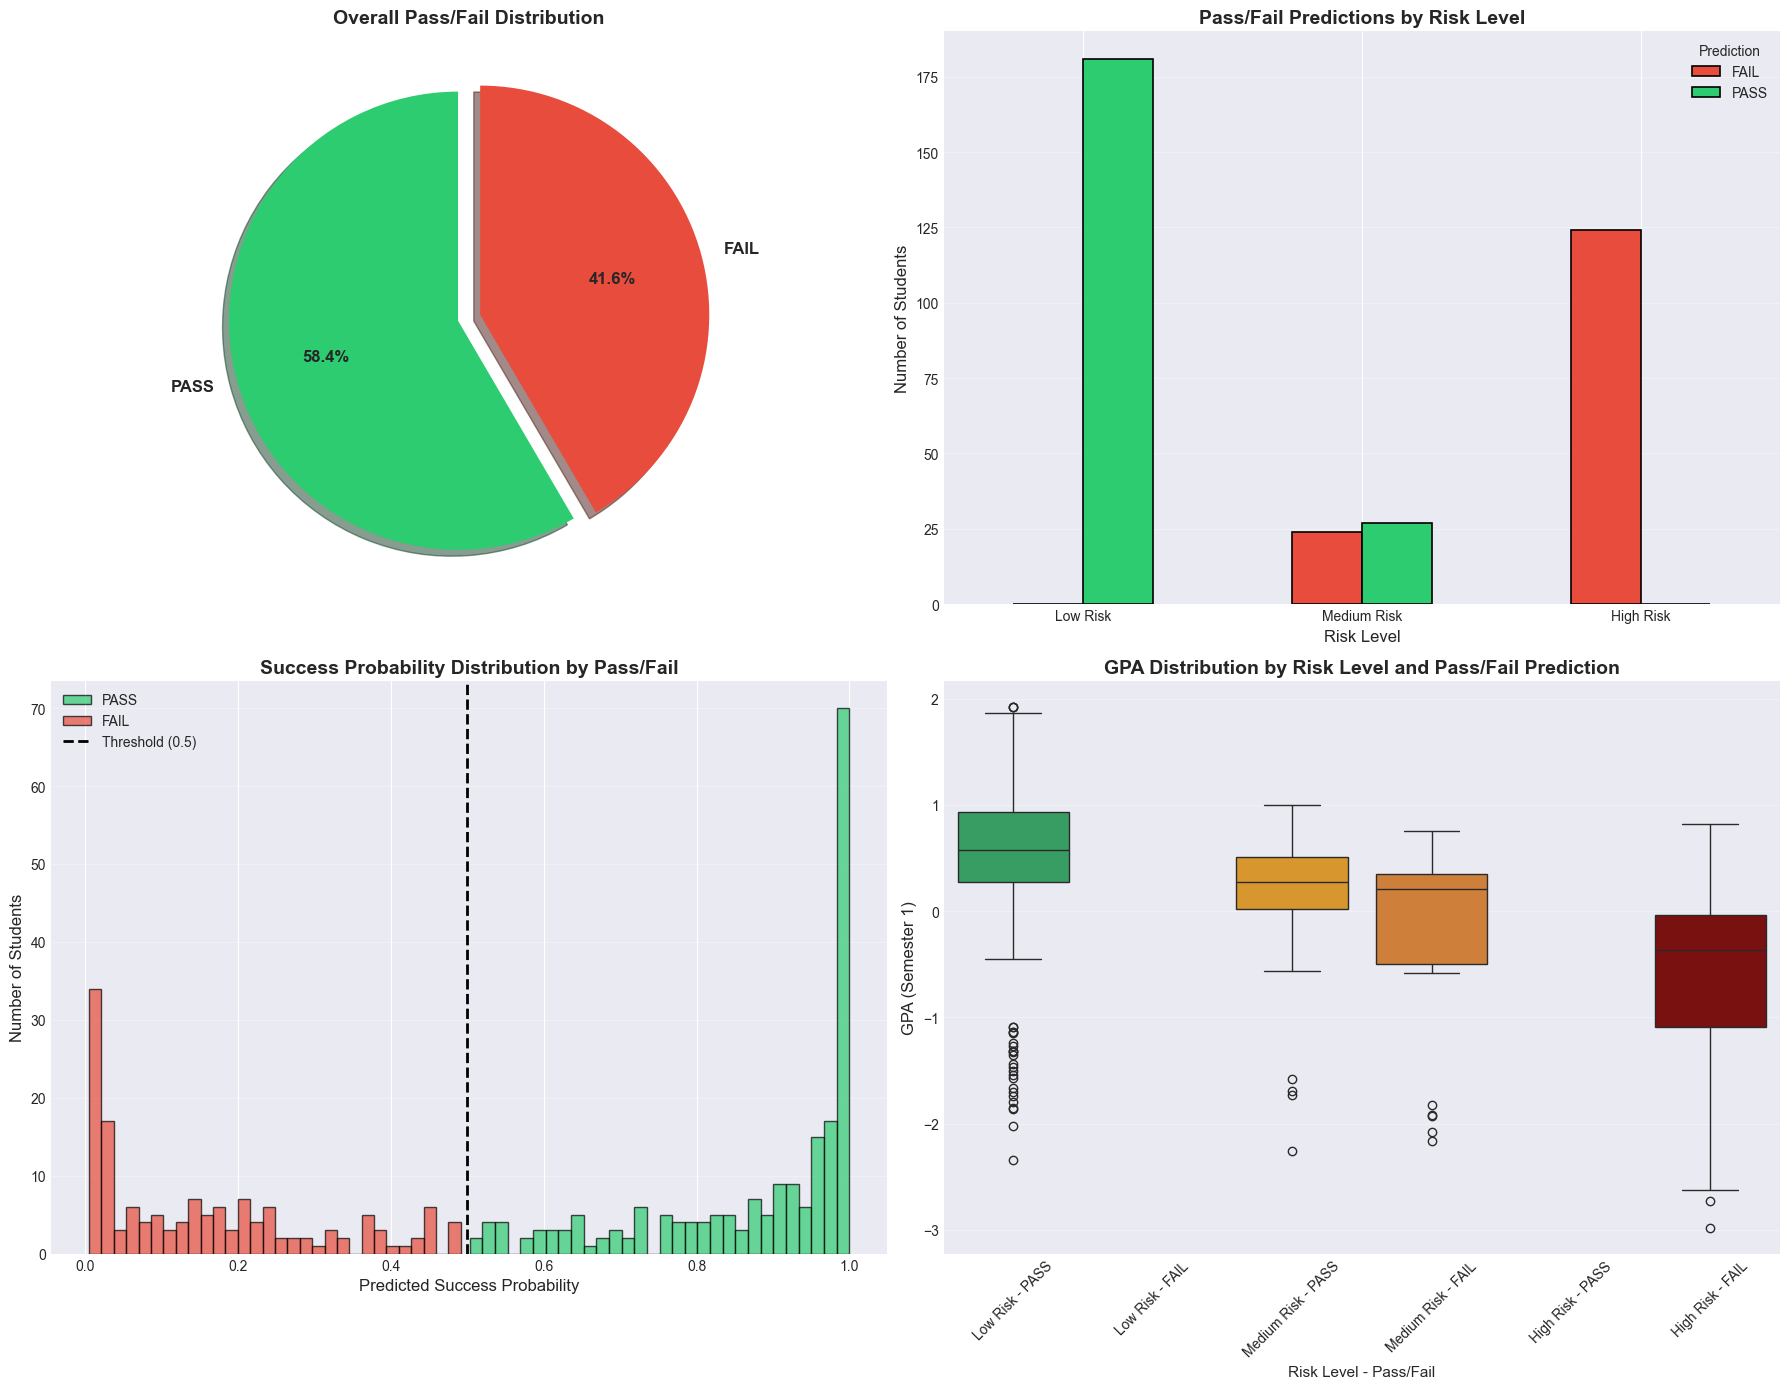



📋 4. DETAILED STUDENT LISTS BY RISK CATEGORY
----------------------------------------------------------------------------------------------------

🟢 LOW RISK STUDENTS (Top 20 by Success Probability):
   Student_ID      Country              Subject  Success_Prob Success_Label Pass/Fail           Cluster       GPA  Attendance  Engagement
0     S100535        India     Computer Science      0.999685       Success      PASS  Elite Performers  1.921124    1.617596    1.701350
1     S101461       Latvia             Medicine      0.999679       Success      PASS  Elite Performers  1.860866    1.553797    1.697188
2     S101309       Latvia      Social Sciences      0.999677       Success      PASS  Elite Performers  1.921124    1.534167    1.693027
3     S101027        India  Information Systems      0.999676       Success      PASS  Elite Performers  1.921124    1.573428    1.697188
4     S100485     Pakistan          Engineering      0.999651       Success      PASS  Elite Performers  1.8

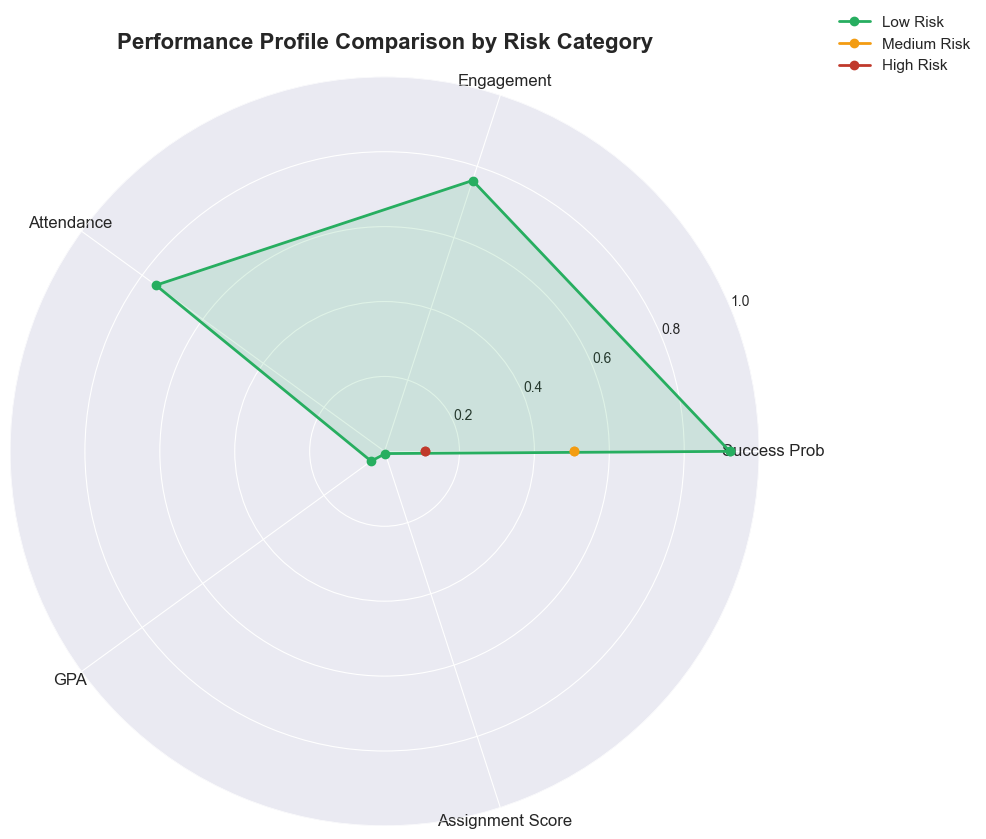



📊 6. COMPREHENSIVE SUMMARY TABLE
----------------------------------------------------------------------------------------------------

Risk Category Summary Statistics:
Risk_Category  Total_Students  Pass_Count  Fail_Count  Success_Rate_%  Avg_Success_Prob  Avg_GPA  Avg_Attendance_%  Avg_Engagement  Low_Engagement_Weeks
     Low Risk             181         181           0           100.0              0.92     0.44             75.46            0.76                 -0.70
  Medium Risk              51          27          24           100.0              0.51    -0.12            -28.05           -0.28                 -0.22
    High Risk             124           0         124             0.0              0.11    -0.73           -103.01           -1.05                  1.19


💾 7. EXPORTING STUDENT LISTS FOR INTERVENTION
----------------------------------------------------------------------------------------------------
✅ Exported Low Risk students to: ./outputs/students_low_risk.csv
✅ E

In [53]:
"""
## 17. COMPREHENSIVE RISK CATEGORY ANALYSIS & STUDENT SUCCESS PREDICTION

Advanced Visualizations for Risk Identification and Cluster Differentiation
"""

# Cell Code to Add:
cell_code = """
## 17. COMPREHENSIVE RISK CATEGORY ANALYSIS & STUDENT SUCCESS PREDICTION

This section provides advanced visualizations to identify students by risk category,
analyze cluster differences, and predict pass/fail outcomes.
"""

print("="*100)
print(" " * 25 + "📊 RISK CATEGORY & SUCCESS ANALYSIS 📊")
print("="*100)

# ============================================================================
# 1. RISK CATEGORY DISTRIBUTION WITH SUCCESS LABELS
# ============================================================================
print("\n🎯 1. OVERALL RISK DISTRIBUTION & SUCCESS RATES")
print("-" * 100)

# Create comprehensive risk analysis dataframe
risk_success_summary = df_val.groupby(['predicted_risk_level', 'success_label_from_risk']).agg({
    'student_id': 'count',
    'predicted_success_proba': ['mean', 'std']
}).round(3)

risk_success_summary.columns = ['Count', 'Avg_Success_Prob', 'Std_Success_Prob']
print("\nRisk Category × Success Label Cross-Tabulation:")
print(risk_success_summary)

# Visualization 1: Stacked Bar Chart - Risk Distribution with Success Labels
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: Stacked bar for risk levels
risk_counts = df_val.groupby(['predicted_risk_level', 'success_label_from_risk']).size().unstack(fill_value=0)
risk_counts_ordered = risk_counts.reindex(['Low Risk', 'Medium Risk', 'High Risk'])

colors_success = ['#2ecc71', '#e74c3c']  # Green for Success, Red for At Risk
risk_counts_ordered.plot(kind='bar', stacked=True, ax=axes[0], color=colors_success, 
                         edgecolor='black', linewidth=1.2)
axes[0].set_title('Risk Category Distribution with Success Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level', fontsize=12)
axes[0].set_ylabel('Number of Students', fontsize=12)
axes[0].legend(title='Predicted Outcome', fontsize=10)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='center', fontsize=10, fontweight='bold')

# Right: Success rate by risk level
success_rates = df_val.groupby('predicted_risk_level').apply(
    lambda x: (x['success_label_from_risk'] == 'Success').mean() * 100
).reindex(['Low Risk', 'Medium Risk', 'High Risk'])

bars = axes[1].bar(success_rates.index, success_rates.values, 
                   color=['#27ae60', '#f39c12', '#c0392b'], edgecolor='black', linewidth=1.2)
axes[1].set_title('Success Rate by Risk Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Risk Level', fontsize=12)
axes[1].set_ylabel('Success Rate (%)', fontsize=12)
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. CLUSTER-BASED RISK ANALYSIS
# ============================================================================
print("\n\n🔬 2. CLUSTERING ANALYSIS BY RISK CATEGORY")
print("-" * 100)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare features for clustering (numerical features only)
cluster_features = ['predicted_success_proba', 'mean_weekly_engagement', 'attendance_rate', 
                   'avg_assignment_score', 'avg_exam_score', 'gpa_sem1', 'gpa_sem2',
                   'low_engagement_weeks', 'failed_courses_sem1', 'failed_courses_sem2']

X_cluster = df_val[cluster_features].copy()
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Perform K-Means clustering (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_val['cluster_label'] = kmeans.fit_predict(X_cluster_scaled)

# Map clusters to intuitive names based on success probability
cluster_means = df_val.groupby('cluster_label')['predicted_success_proba'].mean().sort_values(ascending=False)
cluster_mapping = {
    cluster_means.index[0]: 'Elite Performers',
    cluster_means.index[1]: 'Strong Achievers',
    cluster_means.index[2]: 'Moderate Performers',
    cluster_means.index[3]: 'At-Risk Students'
}
df_val['cluster_name'] = df_val['cluster_label'].map(cluster_mapping)

print("\nCluster Statistics:")
cluster_stats = df_val.groupby('cluster_name').agg({
    'student_id': 'count',
    'predicted_success_proba': ['mean', 'std'],
    'mean_weekly_engagement': 'mean',
    'gpa_sem1': 'mean',
    'attendance_rate': 'mean'
}).round(3)
cluster_stats.columns = ['Count', 'Avg_Success_Prob', 'Std', 'Avg_Engagement', 'Avg_GPA', 'Avg_Attendance']
print(cluster_stats)

# Cross-tabulation: Cluster vs Risk Level
print("\n\nCluster × Risk Level Cross-Tabulation:")
cluster_risk_crosstab = pd.crosstab(df_val['cluster_name'], df_val['predicted_risk_level'])
cluster_risk_crosstab = cluster_risk_crosstab[['Low Risk', 'Medium Risk', 'High Risk']]
print(cluster_risk_crosstab)

# Visualization 2: Cluster Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left: PCA visualization of clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster_scaled)

cluster_colors = {'Elite Performers': '#2ecc71', 'Strong Achievers': '#3498db', 
                  'Moderate Performers': '#f39c12', 'At-Risk Students': '#e74c3c'}

for cluster_name in df_val['cluster_name'].unique():
    mask = df_val['cluster_name'] == cluster_name
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=cluster_name, alpha=0.6, s=80, 
                   color=cluster_colors[cluster_name], edgecolors='black', linewidth=0.5)

axes[0].set_title('Student Clusters in PCA Space', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
axes[0].legend(title='Cluster', fontsize=9, loc='best')
axes[0].grid(alpha=0.3)

# Right: Heatmap of cluster characteristics
cluster_profiles = df_val.groupby('cluster_name')[
    ['predicted_success_proba', 'mean_weekly_engagement', 'attendance_rate', 
     'avg_assignment_score', 'gpa_sem1']
].mean()
cluster_profiles = cluster_profiles.reindex(['Elite Performers', 'Strong Achievers', 
                                             'Moderate Performers', 'At-Risk Students'])

# Normalize for heatmap
from sklearn.preprocessing import MinMaxScaler
cluster_profiles_norm = pd.DataFrame(
    MinMaxScaler().fit_transform(cluster_profiles),
    index=cluster_profiles.index,
    columns=['Success Prob', 'Engagement', 'Attendance', 'Assignment Score', 'GPA']
)

sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Score'}, ax=axes[1], 
            linewidths=0.5, linecolor='black')
axes[1].set_title('Cluster Performance Profiles (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Performance Metrics', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. PASS/FAIL PREDICTION ANALYSIS
# ============================================================================
print("\n\n✅❌ 3. PASS/FAIL PREDICTION BREAKDOWN")
print("-" * 100)

# Create pass/fail labels based on success probability threshold
df_val['pass_fail_prediction'] = df_val['predicted_success_proba'].apply(
    lambda x: 'PASS' if x >= 0.5 else 'FAIL'
)

# Summary statistics
pass_fail_summary = df_val.groupby('pass_fail_prediction').agg({
    'student_id': 'count',
    'predicted_success_proba': ['mean', 'min', 'max'],
    'gpa_sem1': 'mean',
    'attendance_rate': 'mean',
    'mean_weekly_engagement': 'mean'
}).round(3)
pass_fail_summary.columns = ['Count', 'Avg_Prob', 'Min_Prob', 'Max_Prob', 'Avg_GPA', 'Avg_Attendance', 'Avg_Engagement']
print("\nPass/Fail Prediction Summary:")
print(pass_fail_summary)

# Risk level breakdown by pass/fail
print("\n\nPass/Fail × Risk Level Distribution:")
pass_fail_risk = pd.crosstab(df_val['pass_fail_prediction'], df_val['predicted_risk_level'], 
                              margins=True, margins_name='Total')
print(pass_fail_risk)

# Visualization 3: Pass/Fail Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top-left: Pass/Fail pie chart
pass_fail_counts = df_val['pass_fail_prediction'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)

axes[0, 0].pie(pass_fail_counts.values, labels=pass_fail_counts.index, autopct='%1.1f%%',
               colors=colors_pie, explode=explode, shadow=True, startangle=90,
               textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 0].set_title('Overall Pass/Fail Distribution', fontsize=14, fontweight='bold')

# Top-right: Pass/Fail by risk level (grouped bar)
pass_fail_risk_plot = pd.crosstab(df_val['predicted_risk_level'], df_val['pass_fail_prediction'])
pass_fail_risk_plot = pass_fail_risk_plot.reindex(['Low Risk', 'Medium Risk', 'High Risk'])
pass_fail_risk_plot.plot(kind='bar', ax=axes[0, 1], color=['#e74c3c', '#2ecc71'], 
                         edgecolor='black', linewidth=1.2)
axes[0, 1].set_title('Pass/Fail Predictions by Risk Level', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Level', fontsize=12)
axes[0, 1].set_ylabel('Number of Students', fontsize=12)
axes[0, 1].legend(title='Prediction', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=0)
axes[0, 1].grid(axis='y', alpha=0.3)

# Bottom-left: Success probability distribution by pass/fail
df_pass = df_val[df_val['pass_fail_prediction'] == 'PASS']['predicted_success_proba']
df_fail = df_val[df_val['pass_fail_prediction'] == 'FAIL']['predicted_success_proba']

axes[1, 0].hist(df_pass, bins=30, alpha=0.7, color='#2ecc71', label='PASS', edgecolor='black')
axes[1, 0].hist(df_fail, bins=30, alpha=0.7, color='#e74c3c', label='FAIL', edgecolor='black')
axes[1, 0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1, 0].set_title('Success Probability Distribution by Pass/Fail', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Success Probability', fontsize=12)
axes[1, 0].set_ylabel('Number of Students', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3)

# Bottom-right: Box plot - GPA by Pass/Fail and Risk
df_val_plot = df_val.copy()
df_val_plot['Risk_PassFail'] = df_val_plot['predicted_risk_level'] + ' - ' + df_val_plot['pass_fail_prediction']

risk_order = ['Low Risk - PASS', 'Low Risk - FAIL', 'Medium Risk - PASS', 
              'Medium Risk - FAIL', 'High Risk - PASS', 'High Risk - FAIL']
df_val_plot['Risk_PassFail'] = pd.Categorical(df_val_plot['Risk_PassFail'], 
                                               categories=risk_order, ordered=True)

sns.boxplot(data=df_val_plot, x='Risk_PassFail', y='gpa_sem1', ax=axes[1, 1],
            palette=['#27ae60', '#c0392b', '#f39c12', '#e67e22', '#e74c3c', '#8b0000'])
axes[1, 1].set_title('GPA Distribution by Risk Level and Pass/Fail Prediction', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Risk Level - Pass/Fail', fontsize=11)
axes[1, 1].set_ylabel('GPA (Semester 1)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 4. DETAILED STUDENT LISTS BY RISK CATEGORY
# ============================================================================
print("\n\n📋 4. DETAILED STUDENT LISTS BY RISK CATEGORY")
print("-" * 100)

# Function to display student details
def display_student_list(risk_level, max_students=20):
    students = df_val[df_val['predicted_risk_level'] == risk_level].sort_values(
        'predicted_success_proba', ascending=(risk_level == 'High Risk')
    ).head(max_students)
    
    student_details = students[[
        'student_id', 'country_home', 'subject_field', 'predicted_success_proba',
        'success_label_from_risk', 'pass_fail_prediction', 'cluster_name',
        'gpa_sem1', 'attendance_rate', 'mean_weekly_engagement'
    ]].copy()
    
    student_details.columns = ['Student_ID', 'Country', 'Subject', 'Success_Prob', 
                               'Success_Label', 'Pass/Fail', 'Cluster',
                               'GPA', 'Attendance', 'Engagement']
    
    return student_details.reset_index(drop=True)

# Display top students from each category
print("\n🟢 LOW RISK STUDENTS (Top 20 by Success Probability):")
low_risk_students = display_student_list('Low Risk', 20)
print(low_risk_students.to_string())

print("\n\n🟡 MEDIUM RISK STUDENTS (Top 20 by Success Probability):")
medium_risk_students = display_student_list('Medium Risk', 20)
print(medium_risk_students.to_string())

print("\n\n🔴 HIGH RISK STUDENTS (Top 20 - Most Critical):")
high_risk_students = display_student_list('High Risk', 20)
print(high_risk_students.to_string())

# ============================================================================
# 5. RISK TRANSITION ANALYSIS (Engagement Trends)
# ============================================================================
print("\n\n📈 5. ENGAGEMENT TRENDS BY RISK CATEGORY")
print("-" * 100)

# Calculate engagement metrics by risk level
engagement_trends = df_val.groupby('predicted_risk_level').agg({
    'mean_weekly_engagement': ['mean', 'std'],
    'low_engagement_weeks': ['mean', 'std'],
    'attendance_rate': ['mean', 'std'],
    'engagement_trend': ['mean', 'std']
}).round(3)

print("\nEngagement Metrics by Risk Category:")
print(engagement_trends)

# Visualization 5: Radar chart comparing risk categories
from math import pi

categories = ['Success Prob', 'Engagement', 'Attendance', 'GPA', 'Assignment Score']
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Calculate normalized metrics for each risk level
risk_metrics = {}
for risk in ['Low Risk', 'Medium Risk', 'High Risk']:
    risk_data = df_val[df_val['predicted_risk_level'] == risk]
    risk_metrics[risk] = [
        risk_data['predicted_success_proba'].mean(),
        risk_data['mean_weekly_engagement'].mean(),
        risk_data['attendance_rate'].mean(),
        risk_data['gpa_sem1'].mean() / 10,  # Normalize to 0-1
        risk_data['avg_assignment_score'].mean() / 100  # Normalize to 0-1
    ]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

colors_radar = {'Low Risk': '#27ae60', 'Medium Risk': '#f39c12', 'High Risk': '#c0392b'}

for risk, values in risk_metrics.items():
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=risk, color=colors_radar[risk])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[risk])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_title('Performance Profile Comparison by Risk Category', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.grid(True)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. INTERACTIVE SUMMARY TABLE
# ============================================================================
print("\n\n📊 6. COMPREHENSIVE SUMMARY TABLE")
print("-" * 100)

# Create comprehensive summary
summary_data = []

for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    risk_data = df_val[df_val['predicted_risk_level'] == risk_level]
    
    summary_data.append({
        'Risk_Category': risk_level,
        'Total_Students': len(risk_data),
        'Pass_Count': (risk_data['pass_fail_prediction'] == 'PASS').sum(),
        'Fail_Count': (risk_data['pass_fail_prediction'] == 'FAIL').sum(),
        'Success_Rate_%': (risk_data['success_label_from_risk'] == 'Success').mean() * 100,
        'Avg_Success_Prob': risk_data['predicted_success_proba'].mean(),
        'Avg_GPA': risk_data['gpa_sem1'].mean(),
        'Avg_Attendance_%': risk_data['attendance_rate'].mean() * 100,
        'Avg_Engagement': risk_data['mean_weekly_engagement'].mean(),
        'Low_Engagement_Weeks': risk_data['low_engagement_weeks'].mean()
    })

summary_df = pd.DataFrame(summary_data).round(2)
print("\nRisk Category Summary Statistics:")
print(summary_df.to_string(index=False))

# ============================================================================
# 7. EXPORT STUDENT LISTS
# ============================================================================
print("\n\n💾 7. EXPORTING STUDENT LISTS FOR INTERVENTION")
print("-" * 100)

# Save detailed lists to CSV
output_dir = './outputs'
os.makedirs(output_dir, exist_ok=True)

# Export by risk category
for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    filename = f"{output_dir}/students_{risk_level.replace(' ', '_').lower()}.csv"
    student_list = display_student_list(risk_level, max_students=1000)
    student_list.to_csv(filename, index=False)
    print(f"✅ Exported {risk_level} students to: {filename}")

# Export pass/fail lists
pass_students = df_val[df_val['pass_fail_prediction'] == 'PASS'][[
    'student_id', 'country_home', 'subject_field', 'predicted_success_proba',
    'predicted_risk_level', 'cluster_name', 'gpa_sem1', 'attendance_rate'
]]
pass_students.to_csv(f"{output_dir}/students_predicted_pass.csv", index=False)
print(f"✅ Exported PASS students to: {output_dir}/students_predicted_pass.csv")

fail_students = df_val[df_val['pass_fail_prediction'] == 'FAIL'][[
    'student_id', 'country_home', 'subject_field', 'predicted_success_proba',
    'predicted_risk_level', 'cluster_name', 'gpa_sem1', 'attendance_rate'
]]
fail_students.to_csv(f"{output_dir}/students_predicted_fail.csv", index=False)
print(f"✅ Exported FAIL students to: {output_dir}/students_predicted_fail.csv")

print("\n" + "="*100)
print(" " * 30 + "✅ RISK ANALYSIS COMPLETE ✅")
print("="*100)



In [54]:
## 18. BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS

                    🔍 BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS 🔍


📌 SECTION 1: BARRIER IDENTIFICATION
----------------------------------------------------------------------------------------------------
Total columns in validation dataset: 66

🚨 Detecting Barriers Based on Thresholds:
----------------------------------------------------------------------------------------------------
✓ Low Attendance                 (attendance_rate          ):  252 students ( 70.8%)
✓ Language Difficulty            (language_proficiency     ):    0 students (  0.0%)
✓ Cultural Adaptation Problem    (cultural_distance        ):   77 students ( 21.6%)
⚠ adaptability             : Column not found in dataset

🚨 Detecting Program Participation Barriers:
----------------------------------------------------------------------------------------------------
✓ No Support Program             (support_program          ):  192 students ( 53.9%)
✓ No Buddy Program               (participates_in_buddy_program):

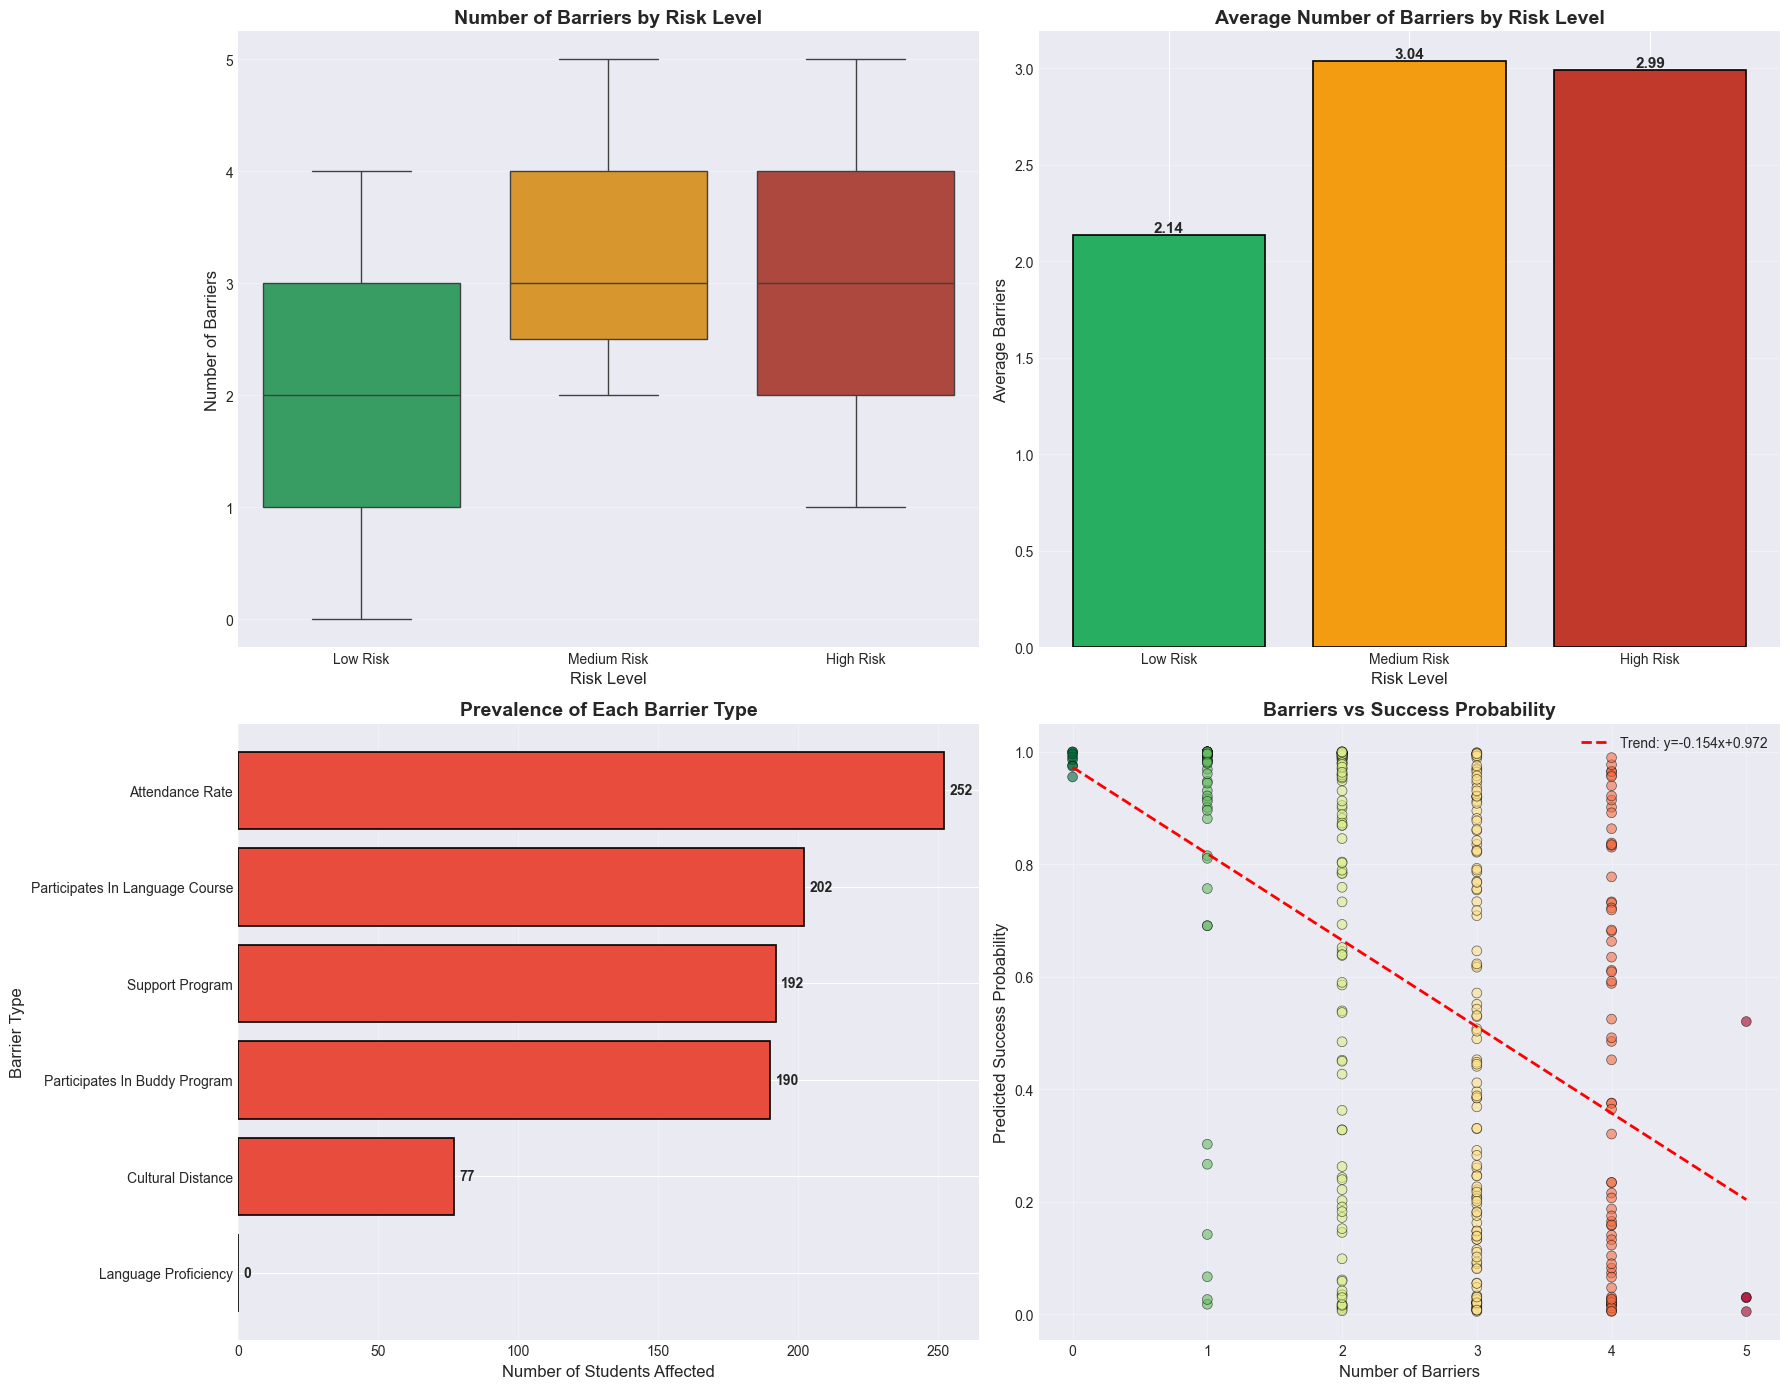



🔬 SECTION 2: ROOT CAUSE ANALYSIS FOR HIGH RISK STUDENTS
----------------------------------------------------------------------------------------------------

Total High Risk Students: 124
Analyzing 21 available features

📈 Top 15 Features Correlated with Success Probability (High Risk Students):
----------------------------------------------------------------------------------------------------
                      Feature  Correlation  Abs_Correlation
         low_engagement_weeks    -0.817644         0.817644
       mean_weekly_engagement     0.702663         0.702663
              attendance_rate     0.605112         0.605112
               avg_exam_score     0.448940         0.448940
         avg_assignment_score     0.401786         0.401786
         late_submission_rate    -0.372969         0.372969
          failed_courses_sem1    -0.191150         0.191150
          failed_courses_sem2    -0.183118         0.183118
                     gpa_sem1     0.169045         0.169045


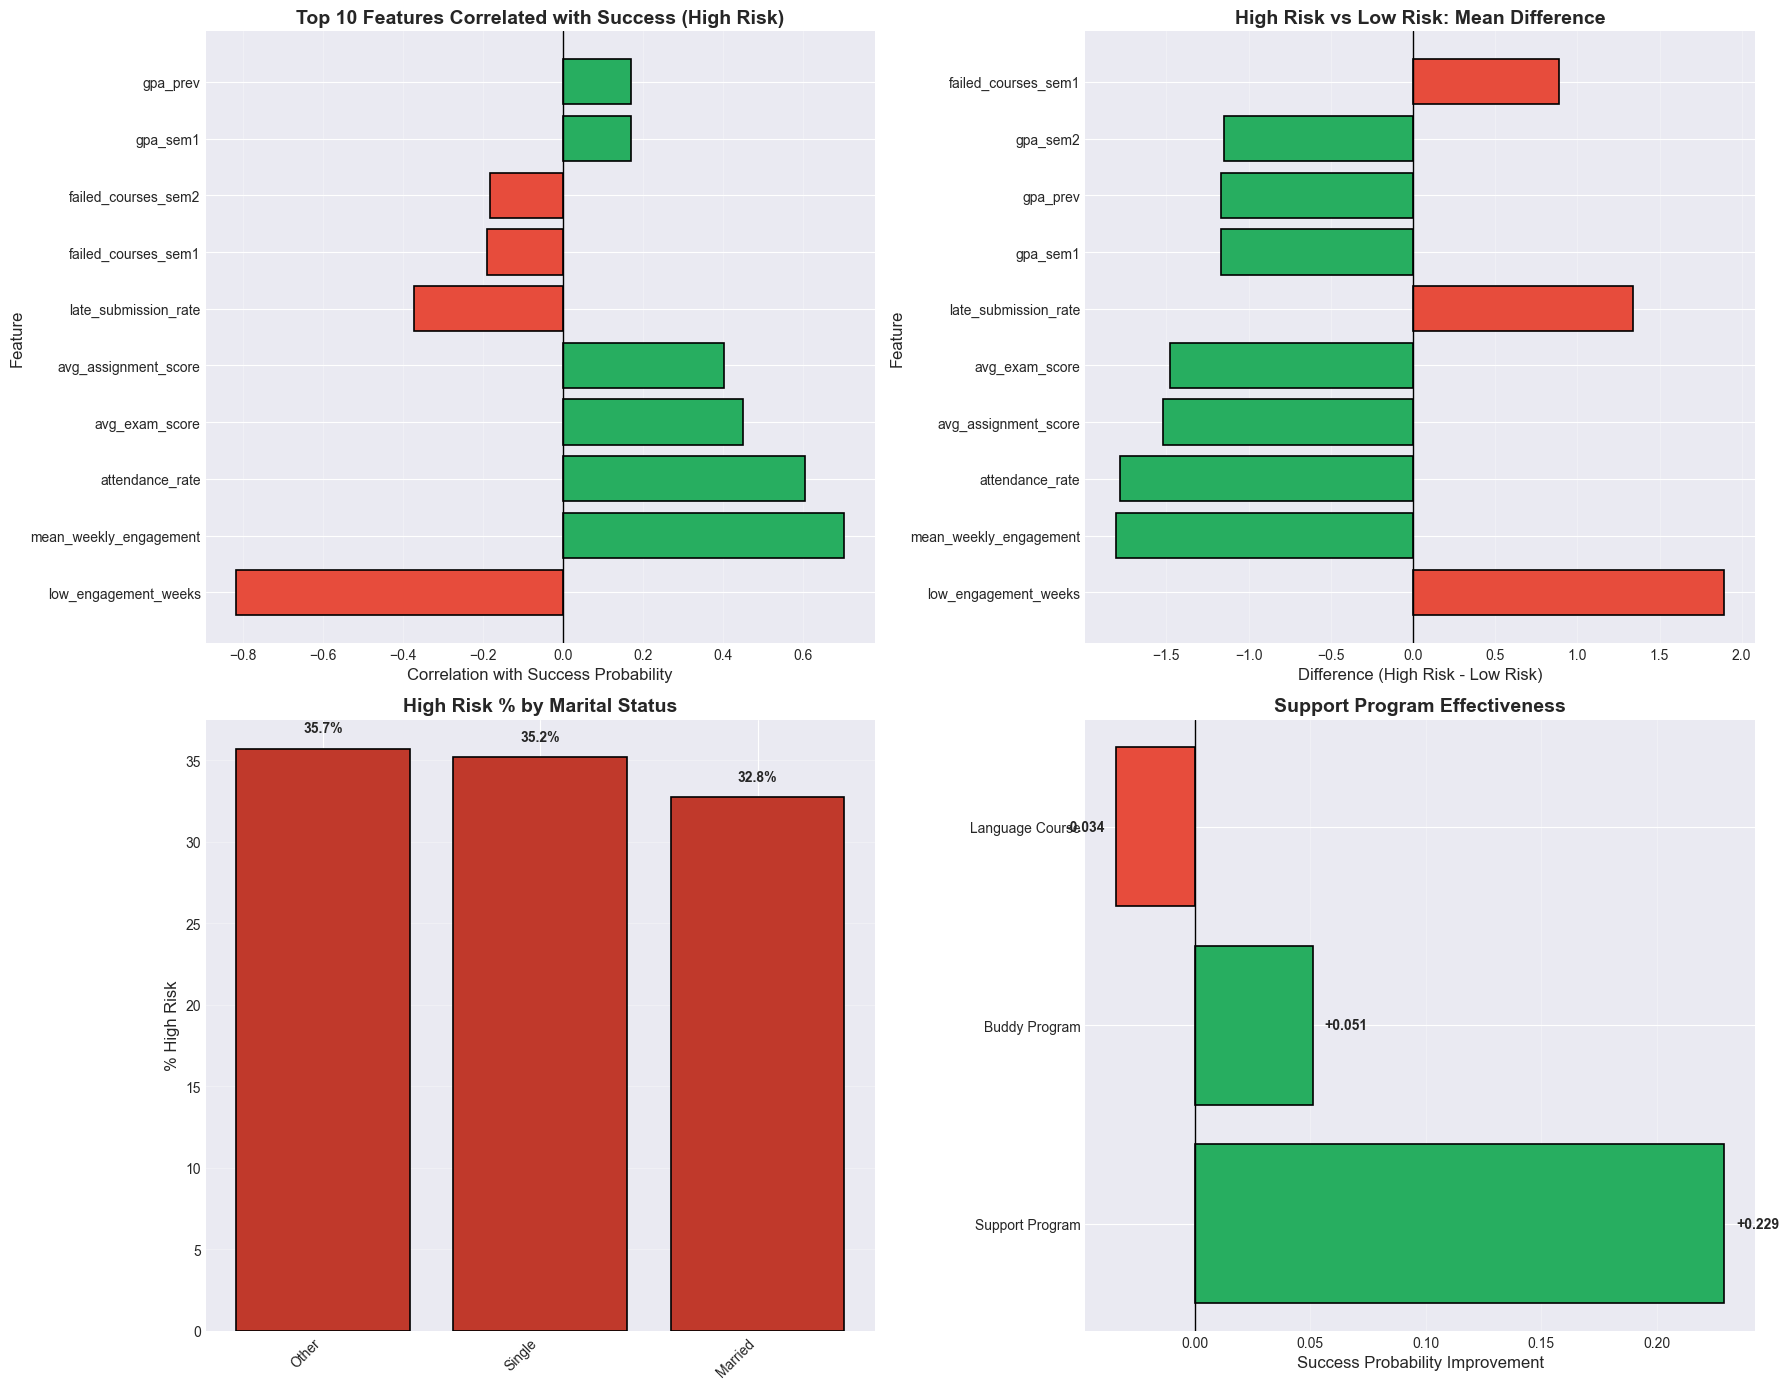



📋 SECTION 3: HIGH RISK STUDENT PROFILES WITH IDENTIFIED ROOT CAUSES
----------------------------------------------------------------------------------------------------

🚨 Top 30 Most Critical High Risk Students with Root Causes:
----------------------------------------------------------------------------------------------------
student_id country_home       subject_field  predicted_success_proba  total_barriers                                                                                                    identified_root_causes  attendance_rate  language_proficiency  cultural_distance  gpa_sem1  mean_weekly_engagement
   S101251      Nigeria Information Systems                 0.005030               5 Low Attendance, Cultural Adaptation, No Support Program, No Buddy Program, No Language Course, Multiple Failures, Low GPA        -1.901137                     3           1.236920 -1.091750               -1.773674
   S100374        Kenya    Computer Science                 0.005239 

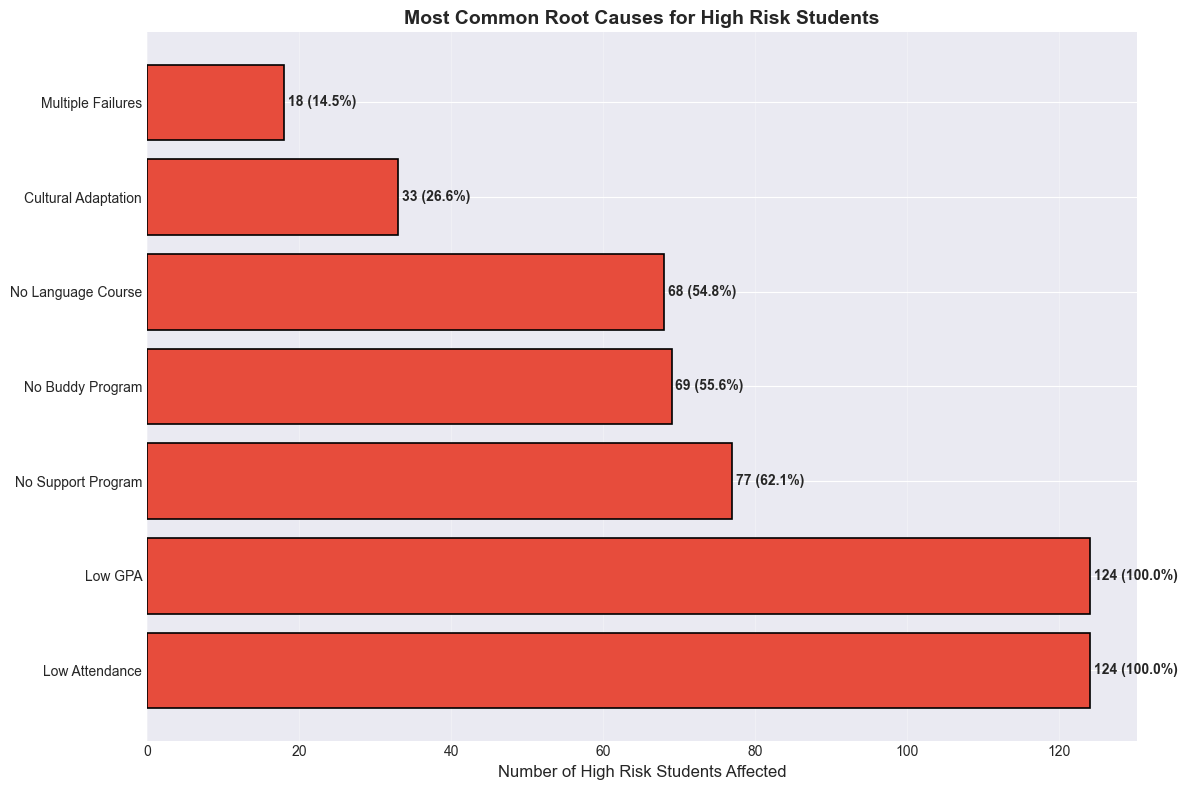



💾 SECTION 5: EXPORTING BARRIER AND ROOT CAUSE DATA
----------------------------------------------------------------------------------------------------
✅ Exported: ./outputs/high_risk_students_with_root_causes.csv
   Contains: 124 high risk students with identified barriers and root causes
✅ Exported: ./outputs/all_students_barrier_analysis.csv
   Contains: 356 students with barrier flags
✅ Exported: ./outputs/root_cause_frequency.csv
   Contains: Frequency analysis of root causes

                         ✅ BARRIER & ROOT CAUSE ANALYSIS COMPLETE ✅


In [55]:
"""
SECTION 18: BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS
Advanced analysis to identify specific barriers and root causes for student risk
"""

print("="*100)
print(" " * 20 + "🔍 BARRIER IDENTIFICATION & ROOT CAUSE ANALYSIS 🔍")
print("="*100)

# ============================================================================
# 1. BARRIER DETECTION - Identify Students with Specific Problems
# ============================================================================
print("\n\n📌 SECTION 1: BARRIER IDENTIFICATION")
print("-" * 100)

# Define barrier thresholds dynamically
barrier_columns = {
    'attendance_rate': {'threshold': 0.6, 'type': 'below', 'barrier_name': 'Low Attendance'},
    'language_proficiency': {'threshold': 0.6, 'type': 'below', 'barrier_name': 'Language Difficulty'},
    'cultural_distance': {'threshold': 0.7, 'type': 'above', 'barrier_name': 'Cultural Adaptation Problem'},
    'adaptability': {'threshold': 0.5, 'type': 'below', 'barrier_name': 'Poor Adaptability'},
}

# Check which columns exist in the dataset
available_columns = df_val.columns.tolist()
print(f"Total columns in validation dataset: {len(available_columns)}")

# Identify barriers for each student
barrier_flags = pd.DataFrame(index=df_val.index)
barrier_flags['student_id'] = df_val['student_id']
barrier_flags['predicted_risk_level'] = df_val['predicted_risk_level']
barrier_flags['predicted_success_proba'] = df_val['predicted_success_proba']

print("\n🚨 Detecting Barriers Based on Thresholds:")
print("-" * 100)

for col, config in barrier_columns.items():
    if col in available_columns:
        threshold = config['threshold']
        barrier_type = config['type']
        barrier_name = config['barrier_name']
        
        if barrier_type == 'below':
            barrier_flags[f'has_{col}_barrier'] = (df_val[col] < threshold).astype(int)
        else:  # above
            barrier_flags[f'has_{col}_barrier'] = (df_val[col] > threshold).astype(int)
        
        count = barrier_flags[f'has_{col}_barrier'].sum()
        pct = (count / len(df_val)) * 100
        print(f"✓ {barrier_name:30s} ({col:25s}): {count:4d} students ({pct:5.1f}%)")
    else:
        print(f"⚠ {col:25s}: Column not found in dataset")

# Check for additional barrier indicators
additional_checks = {
    'support_program': {'value': 0, 'barrier_name': 'No Support Program'},
    'participates_in_buddy_program': {'value': 0, 'barrier_name': 'No Buddy Program'},
    'participates_in_language_course': {'value': 0, 'barrier_name': 'No Language Course'},
}

print("\n🚨 Detecting Program Participation Barriers:")
print("-" * 100)

for col, config in additional_checks.items():
    if col in available_columns:
        barrier_name = config['barrier_name']
        target_value = config['value']
        barrier_flags[f'has_{col}_barrier'] = (df_val[col] == target_value).astype(int)
        count = barrier_flags[f'has_{col}_barrier'].sum()
        pct = (count / len(df_val)) * 100
        print(f"✓ {barrier_name:30s} ({col:25s}): {count:4d} students ({pct:5.1f}%)")
    else:
        print(f"⚠ {col:25s}: Column not found in dataset")

# Count total barriers per student
barrier_col_names = [col for col in barrier_flags.columns if col.startswith('has_')]
barrier_flags['total_barriers'] = barrier_flags[barrier_col_names].sum(axis=1)

print("\n📊 Barrier Summary Statistics:")
print("-" * 100)
print(f"Students with 0 barriers: {(barrier_flags['total_barriers'] == 0).sum()} ({(barrier_flags['total_barriers'] == 0).mean()*100:.1f}%)")
print(f"Students with 1 barrier:  {(barrier_flags['total_barriers'] == 1).sum()} ({(barrier_flags['total_barriers'] == 1).mean()*100:.1f}%)")
print(f"Students with 2 barriers: {(barrier_flags['total_barriers'] == 2).sum()} ({(barrier_flags['total_barriers'] == 2).mean()*100:.1f}%)")
print(f"Students with 3+ barriers: {(barrier_flags['total_barriers'] >= 3).sum()} ({(barrier_flags['total_barriers'] >= 3).mean()*100:.1f}%)")
print(f"Maximum barriers per student: {barrier_flags['total_barriers'].max()}")

# ============================================================================
# 2. VISUALIZATION 1: Barrier Distribution by Risk Level
# ============================================================================
print("\n\n📊 VISUALIZATION 1: BARRIER DISTRIBUTION BY RISK LEVEL")
print("-" * 100)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top-left: Total barriers by risk level (box plot)
barrier_risk_data = barrier_flags[['predicted_risk_level', 'total_barriers']].copy()
barrier_risk_data['predicted_risk_level'] = pd.Categorical(
    barrier_risk_data['predicted_risk_level'],
    categories=['Low Risk', 'Medium Risk', 'High Risk'],
    ordered=True
)

sns.boxplot(data=barrier_risk_data, x='predicted_risk_level', y='total_barriers', 
            ax=axes[0, 0], palette=['#27ae60', '#f39c12', '#c0392b'])
axes[0, 0].set_title('Number of Barriers by Risk Level', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Risk Level', fontsize=12)
axes[0, 0].set_ylabel('Number of Barriers', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)

# Top-right: Average barriers per risk level
avg_barriers = barrier_flags.groupby('predicted_risk_level')['total_barriers'].mean()
avg_barriers = avg_barriers.reindex(['Low Risk', 'Medium Risk', 'High Risk'])

bars = axes[0, 1].bar(avg_barriers.index, avg_barriers.values, 
                      color=['#27ae60', '#f39c12', '#c0392b'], edgecolor='black', linewidth=1.2)
axes[0, 1].set_title('Average Number of Barriers by Risk Level', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Risk Level', fontsize=12)
axes[0, 1].set_ylabel('Average Barriers', fontsize=12)
axes[0, 1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bottom-left: Barrier prevalence (horizontal bar chart)
barrier_prevalence = {}
for col in barrier_col_names:
    barrier_name = col.replace('has_', '').replace('_barrier', '').replace('_', ' ').title()
    count = barrier_flags[col].sum()
    barrier_prevalence[barrier_name] = count

barrier_prev_df = pd.DataFrame(list(barrier_prevalence.items()), 
                               columns=['Barrier', 'Count']).sort_values('Count', ascending=True)

axes[1, 0].barh(barrier_prev_df['Barrier'], barrier_prev_df['Count'], 
                color='#e74c3c', edgecolor='black', linewidth=1.2)
axes[1, 0].set_title('Prevalence of Each Barrier Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Students Affected', fontsize=12)
axes[1, 0].set_ylabel('Barrier Type', fontsize=12)
axes[1, 0].grid(axis='x', alpha=0.3)

for i, (barrier, count) in enumerate(zip(barrier_prev_df['Barrier'], barrier_prev_df['Count'])):
    axes[1, 0].text(count + 2, i, str(count), va='center', fontsize=10, fontweight='bold')

# Bottom-right: Correlation between barriers and success probability
axes[1, 1].scatter(barrier_flags['total_barriers'], barrier_flags['predicted_success_proba'],
                  alpha=0.6, c=barrier_flags['total_barriers'], cmap='RdYlGn_r', 
                  s=50, edgecolors='black', linewidth=0.5)
axes[1, 1].set_title('Barriers vs Success Probability', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Barriers', fontsize=12)
axes[1, 1].set_ylabel('Predicted Success Probability', fontsize=12)
axes[1, 1].grid(alpha=0.3)

# Add trend line
z = np.polyfit(barrier_flags['total_barriers'], barrier_flags['predicted_success_proba'], 1)
p = np.poly1d(z)
x_trend = np.linspace(barrier_flags['total_barriers'].min(), barrier_flags['total_barriers'].max(), 100)
axes[1, 1].plot(x_trend, p(x_trend), "r--", linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.3f}')
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. ROOT CAUSE ANALYSIS - Identify Main Reasons for High Risk
# ============================================================================
print("\n\n🔬 SECTION 2: ROOT CAUSE ANALYSIS FOR HIGH RISK STUDENTS")
print("-" * 100)

# Focus on High Risk students
high_risk_students = df_val[df_val['predicted_risk_level'] == 'High Risk'].copy()
print(f"\nTotal High Risk Students: {len(high_risk_students)}")

# Define all potential root cause features
root_cause_features = [
    # Academic performance
    'gpa_sem1', 'gpa_sem2', 'gpa_prev', 'avg_exam_score', 'avg_assignment_score',
    
    # Engagement
    'attendance_rate', 'mean_weekly_engagement', 'low_engagement_weeks', 
    'engagement_trend', 'missing_assignments_count',
    
    # Academic outcomes
    'failed_courses_sem1', 'failed_courses_sem2', 'late_submission_rate',
    
    # Barriers
    'language_proficiency', 'cultural_distance', 'teaching_style_difference', 'adaptability',
    
    # Support systems
    'support_program', 'participates_in_buddy_program', 'participates_in_language_course',
    
    # Personal factors
    'age', 'marital_status'
]

# Filter to only columns that exist
available_features = [col for col in root_cause_features if col in high_risk_students.columns]
print(f"Analyzing {len(available_features)} available features")

# Calculate correlations with success probability for High Risk students
correlations = {}
for feature in available_features:
    if high_risk_students[feature].dtype in ['int64', 'float64']:
        corr = high_risk_students[feature].corr(high_risk_students['predicted_success_proba'])
        correlations[feature] = corr

# Sort by absolute correlation
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

print("\n📈 Top 15 Features Correlated with Success Probability (High Risk Students):")
print("-" * 100)
print(corr_df.head(15).to_string(index=False))

# ============================================================================
# 4. VISUALIZATION 2: Root Cause Analysis
# ============================================================================
print("\n\n📊 VISUALIZATION 2: ROOT CAUSE CORRELATION ANALYSIS")
print("-" * 100)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top-left: Top 10 correlated features (bar chart)
top_features = corr_df.head(10)
colors_corr = ['#27ae60' if x > 0 else '#e74c3c' for x in top_features['Correlation']]

axes[0, 0].barh(top_features['Feature'], top_features['Correlation'], 
                color=colors_corr, edgecolor='black', linewidth=1.2)
axes[0, 0].set_title('Top 10 Features Correlated with Success (High Risk)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Correlation with Success Probability', fontsize=12)
axes[0, 0].set_ylabel('Feature', fontsize=12)
axes[0, 0].axvline(0, color='black', linewidth=1)
axes[0, 0].grid(axis='x', alpha=0.3)

# Top-right: Feature importance from comparison (High Risk vs Low Risk)
if len(df_val[df_val['predicted_risk_level'] == 'Low Risk']) > 0:
    low_risk_students = df_val[df_val['predicted_risk_level'] == 'Low Risk'].copy()
    
    # Calculate mean differences
    feature_differences = {}
    for feature in available_features:
        if high_risk_students[feature].dtype in ['int64', 'float64']:
            high_mean = high_risk_students[feature].mean()
            low_mean = low_risk_students[feature].mean()
            diff = high_mean - low_mean
            feature_differences[feature] = diff
    
    diff_df = pd.DataFrame(list(feature_differences.items()), columns=['Feature', 'Difference'])
    diff_df['Abs_Difference'] = diff_df['Difference'].abs()
    diff_df = diff_df.sort_values('Abs_Difference', ascending=False).head(10)
    
    colors_diff = ['#e74c3c' if x > 0 else '#27ae60' for x in diff_df['Difference']]
    
    axes[0, 1].barh(diff_df['Feature'], diff_df['Difference'], 
                    color=colors_diff, edgecolor='black', linewidth=1.2)
    axes[0, 1].set_title('High Risk vs Low Risk: Mean Difference', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Difference (High Risk - Low Risk)', fontsize=12)
    axes[0, 1].set_ylabel('Feature', fontsize=12)
    axes[0, 1].axvline(0, color='black', linewidth=1)
    axes[0, 1].grid(axis='x', alpha=0.3)

# Bottom-left: Categorical root causes (if marital_status exists)
if 'marital_status' in available_columns:
    marital_risk = df_val.groupby(['marital_status', 'predicted_risk_level']).size().unstack(fill_value=0)
    if 'High Risk' in marital_risk.columns:
        marital_risk_pct = (marital_risk['High Risk'] / marital_risk.sum(axis=1)) * 100
        marital_risk_pct = marital_risk_pct.sort_values(ascending=False)
        
        axes[1, 0].bar(range(len(marital_risk_pct)), marital_risk_pct.values,
                      color='#c0392b', edgecolor='black', linewidth=1.2)
        axes[1, 0].set_xticks(range(len(marital_risk_pct)))
        axes[1, 0].set_xticklabels(marital_risk_pct.index, rotation=45, ha='right')
        axes[1, 0].set_title('High Risk % by Marital Status', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('% High Risk', fontsize=12)
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        for i, v in enumerate(marital_risk_pct.values):
            axes[1, 0].text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'Marital Status\nNot Available', 
                   ha='center', va='center', fontsize=14, transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('High Risk % by Marital Status', fontsize=14, fontweight='bold')

# Bottom-right: Support program effectiveness
support_cols = [col for col in ['support_program', 'participates_in_buddy_program', 
                                 'participates_in_language_course'] if col in available_columns]

if len(support_cols) > 0:
    support_effectiveness = {}
    for col in support_cols:
        with_support = df_val[df_val[col] == 1]['predicted_success_proba'].mean()
        without_support = df_val[df_val[col] == 0]['predicted_success_proba'].mean()
        improvement = with_support - without_support
        support_effectiveness[col.replace('participates_in_', '').replace('_', ' ').title()] = improvement
    
    support_df = pd.DataFrame(list(support_effectiveness.items()), 
                             columns=['Program', 'Success_Improvement'])
    support_df = support_df.sort_values('Success_Improvement', ascending=False)
    
    colors_support = ['#27ae60' if x > 0 else '#e74c3c' for x in support_df['Success_Improvement']]
    
    axes[1, 1].barh(support_df['Program'], support_df['Success_Improvement'],
                   color=colors_support, edgecolor='black', linewidth=1.2)
    axes[1, 1].set_title('Support Program Effectiveness', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Success Probability Improvement', fontsize=12)
    axes[1, 1].axvline(0, color='black', linewidth=1)
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    for i, (prog, imp) in enumerate(zip(support_df['Program'], support_df['Success_Improvement'])):
        axes[1, 1].text(imp + 0.005 if imp > 0 else imp - 0.005, i, 
                       f'{imp:+.3f}', va='center', ha='left' if imp > 0 else 'right',
                       fontsize=10, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'Support Programs\nNot Available', 
                   ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Support Program Effectiveness', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 5. HIGH RISK STUDENT PROFILES WITH ROOT CAUSES
# ============================================================================
print("\n\n📋 SECTION 3: HIGH RISK STUDENT PROFILES WITH IDENTIFIED ROOT CAUSES")
print("-" * 100)

# Merge barrier flags with high risk students
high_risk_with_barriers = high_risk_students.merge(
    barrier_flags[['student_id', 'total_barriers'] + barrier_col_names],
    on='student_id'
)

# Identify primary root causes for each student
def identify_root_causes(row):
    causes = []
    
    # Check each barrier
    if 'has_attendance_rate_barrier' in row.index and row['has_attendance_rate_barrier'] == 1:
        causes.append('Low Attendance')
    if 'has_language_proficiency_barrier' in row.index and row['has_language_proficiency_barrier'] == 1:
        causes.append('Language Difficulty')
    if 'has_cultural_distance_barrier' in row.index and row['has_cultural_distance_barrier'] == 1:
        causes.append('Cultural Adaptation')
    if 'has_adaptability_barrier' in row.index and row['has_adaptability_barrier'] == 1:
        causes.append('Poor Adaptability')
    if 'has_support_program_barrier' in row.index and row['has_support_program_barrier'] == 1:
        causes.append('No Support Program')
    if 'has_participates_in_buddy_program_barrier' in row.index and row['has_participates_in_buddy_program_barrier'] == 1:
        causes.append('No Buddy Program')
    if 'has_participates_in_language_course_barrier' in row.index and row['has_participates_in_language_course_barrier'] == 1:
        causes.append('No Language Course')
    
    # Check academic issues
    if 'low_engagement_weeks' in row.index and row['low_engagement_weeks'] >= 3:
        causes.append('High Disengagement')
    if 'failed_courses_sem1' in row.index and row['failed_courses_sem1'] >= 2:
        causes.append('Multiple Failures')
    if 'gpa_sem1' in row.index and row['gpa_sem1'] < 5.0:
        causes.append('Low GPA')
    
    return ', '.join(causes) if causes else 'No Clear Barriers Identified'

high_risk_with_barriers['identified_root_causes'] = high_risk_with_barriers.apply(identify_root_causes, axis=1)

# Select relevant columns for display
display_cols = ['student_id', 'country_home', 'subject_field', 'predicted_success_proba', 
                'total_barriers', 'identified_root_causes']

# Add available barrier-related columns
for col in ['attendance_rate', 'language_proficiency', 'cultural_distance', 'adaptability',
            'gpa_sem1', 'mean_weekly_engagement']:
    if col in high_risk_with_barriers.columns:
        display_cols.append(col)

high_risk_profile = high_risk_with_barriers[display_cols].copy()
high_risk_profile = high_risk_profile.sort_values('predicted_success_proba').head(30)

print("\n🚨 Top 30 Most Critical High Risk Students with Root Causes:")
print("-" * 100)
pd.set_option('display.max_colwidth', 50)
print(high_risk_profile.to_string(index=False))
pd.set_option('display.max_colwidth', None)

# ============================================================================
# 6. ROOT CAUSE FREQUENCY ANALYSIS
# ============================================================================
print("\n\n📊 SECTION 4: ROOT CAUSE FREQUENCY ANALYSIS")
print("-" * 100)

# Count frequency of each root cause
all_causes = []
for causes_str in high_risk_with_barriers['identified_root_causes']:
    if causes_str != 'No Clear Barriers Identified':
        all_causes.extend([c.strip() for c in causes_str.split(',')])

cause_counts = pd.Series(all_causes).value_counts()

print("\n🔥 Most Common Root Causes Among High Risk Students:")
print("-" * 100)
for i, (cause, count) in enumerate(cause_counts.items(), 1):
    pct = (count / len(high_risk_students)) * 100
    print(f"{i:2d}. {cause:35s}: {count:4d} students ({pct:5.1f}% of high risk)")

# Visualization: Root cause frequency
fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(range(len(cause_counts)), cause_counts.values, color='#e74c3c', edgecolor='black', linewidth=1.2)
ax.set_yticks(range(len(cause_counts)))
ax.set_yticklabels(cause_counts.index)
ax.set_xlabel('Number of High Risk Students Affected', fontsize=12)
ax.set_title('Most Common Root Causes for High Risk Students', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (cause, count) in enumerate(cause_counts.items()):
    pct = (count / len(high_risk_students)) * 100
    ax.text(count + 0.5, i, f'{count} ({pct:.1f}%)', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 7. EXPORT BARRIER AND ROOT CAUSE DATA
# ============================================================================
print("\n\n💾 SECTION 5: EXPORTING BARRIER AND ROOT CAUSE DATA")
print("-" * 100)

# Export high risk students with root causes
output_file = './outputs/high_risk_students_with_root_causes.csv'
high_risk_with_barriers[display_cols].to_csv(output_file, index=False)
print(f"✅ Exported: {output_file}")
print(f"   Contains: {len(high_risk_with_barriers)} high risk students with identified barriers and root causes")

# Export barrier summary for all students
barrier_summary = df_val[['student_id', 'predicted_risk_level', 'predicted_success_proba']].copy()
barrier_summary = barrier_summary.merge(barrier_flags[['student_id', 'total_barriers'] + barrier_col_names], 
                                       on='student_id')

output_file2 = './outputs/all_students_barrier_analysis.csv'
barrier_summary.to_csv(output_file2, index=False)
print(f"✅ Exported: {output_file2}")
print(f"   Contains: {len(barrier_summary)} students with barrier flags")

# Export root cause summary
root_cause_summary = pd.DataFrame({
    'Root_Cause': cause_counts.index,
    'Count': cause_counts.values,
    'Percentage_of_High_Risk': (cause_counts.values / len(high_risk_students) * 100).round(1)
})

output_file3 = './outputs/root_cause_frequency.csv'
root_cause_summary.to_csv(output_file3, index=False)
print(f"✅ Exported: {output_file3}")
print(f"   Contains: Frequency analysis of root causes")

print("\n" + "="*100)
print(" " * 25 + "✅ BARRIER & ROOT CAUSE ANALYSIS COMPLETE ✅")
print("="*100)


                         🔬 K-MEANS CLUSTERING EXPLAINED 🔬


📚 PART 1: UNDERSTANDING K-MEANS CLUSTERING
----------------------------------------------------------------------------------------------------

K-Means Clustering is an UNSUPERVISED learning algorithm that:
  1. Groups similar students together based on their features
  2. Creates K groups (we use K=4) without being told what "good" or "bad" is
  3. Finds natural patterns in the data

Think of it like organizing a party:
  • You have 356 guests (students)
  • You want to seat them at 4 tables
  • You want similar people at each table
  • K-Means figures out the best seating arrangement!

Our 4 clusters represent:
  🌟 Cluster 1: Elite Performers       (Best students, high success)
  💪 Cluster 2: Strong Achievers       (Good students, solid performance)
  ⚠️  Cluster 3: Moderate Performers   (Average students, could go either way)
  🚨 Cluster 4: At-Risk Students       (Struggling students, need help)



📊 PART 2: WHICH FEATURES

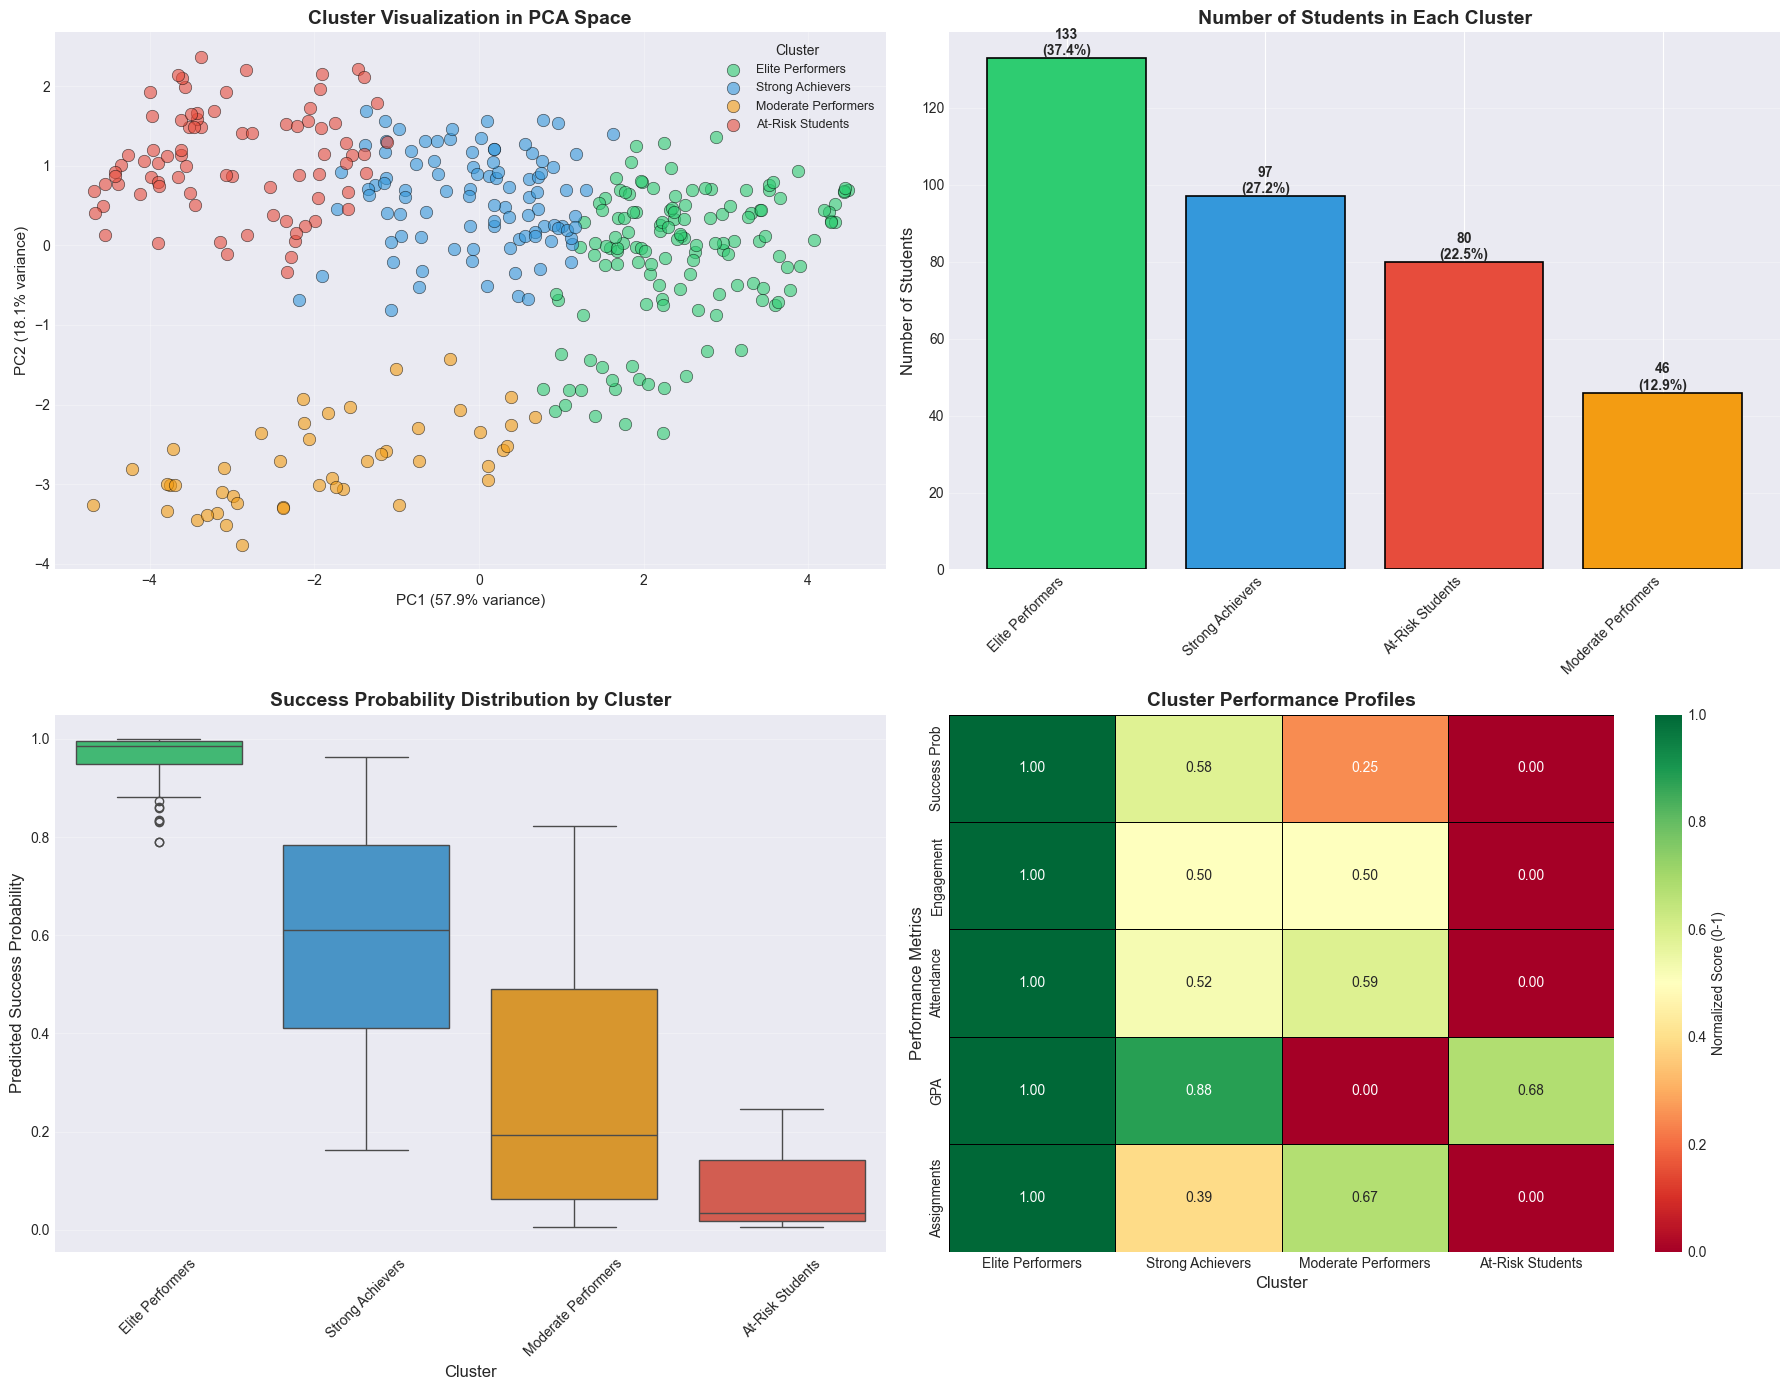


✅ Visualizations complete!


🔗 PART 8: HOW CLUSTERS RELATE TO RISK LEVELS
----------------------------------------------------------------------------------------------------

Cluster × Risk Level Cross-Tabulation:
predicted_risk_level  High Risk  Low Risk  Medium Risk  All
cluster_name                                               
At-Risk Students             80         0            0   80
Elite Performers              0       133            0  133
Moderate Performers          30         7            9   46
Strong Achievers             14        41           42   97
All                         124       181           51  356


Percentage Breakdown (% within each cluster):
predicted_risk_level  High Risk  Low Risk  Medium Risk
cluster_name                                          
At-Risk Students          100.0       0.0          0.0
Elite Performers            0.0     100.0          0.0
Moderate Performers        65.2      15.2         19.6
Strong Achievers           14.4      42.3

In [56]:
"""
SECTION 19: UNDERSTANDING K-MEANS CLUSTERING - EDUCATIONAL WALKTHROUGH

This section explains HOW the 4 student clusters were created and 
provides tools to explore and understand cluster membership.
"""

print("="*100)
print(" " * 25 + "🔬 K-MEANS CLUSTERING EXPLAINED 🔬")
print("="*100)

# ============================================================================
# PART 1: WHAT IS K-MEANS CLUSTERING?
# ============================================================================
print("\n\n📚 PART 1: UNDERSTANDING K-MEANS CLUSTERING")
print("-" * 100)

print("""
K-Means Clustering is an UNSUPERVISED learning algorithm that:
  1. Groups similar students together based on their features
  2. Creates K groups (we use K=4) without being told what "good" or "bad" is
  3. Finds natural patterns in the data

Think of it like organizing a party:
  • You have 356 guests (students)
  • You want to seat them at 4 tables
  • You want similar people at each table
  • K-Means figures out the best seating arrangement!

Our 4 clusters represent:
  🌟 Cluster 1: Elite Performers       (Best students, high success)
  💪 Cluster 2: Strong Achievers       (Good students, solid performance)
  ⚠️  Cluster 3: Moderate Performers   (Average students, could go either way)
  🚨 Cluster 4: At-Risk Students       (Struggling students, need help)
""")

# ============================================================================
# PART 2: THE FEATURES USED FOR CLUSTERING
# ============================================================================
print("\n\n📊 PART 2: WHICH FEATURES ARE USED TO CREATE CLUSTERS?")
print("-" * 100)

# Define the features we use for clustering
cluster_features = [
    'predicted_success_proba',      # Overall success likelihood (0-1)
    'mean_weekly_engagement',       # Weekly engagement score (0-1)
    'attendance_rate',              # Class attendance percentage (0-1)
    'avg_assignment_score',         # Average assignment score (0-100)
    'avg_exam_score',               # Average exam score (0-100)
    'gpa_sem1',                     # Semester 1 GPA (0-10)
    'gpa_sem2',                     # Semester 2 GPA (0-10)
    'low_engagement_weeks',         # Number of weeks with low engagement
    'failed_courses_sem1',          # Failed courses in semester 1
    'failed_courses_sem2'           # Failed courses in semester 2
]

print("We use 10 features to group students:")
print()
for i, feature in enumerate(cluster_features, 1):
    if feature in df_val.columns:
        mean_val = df_val[feature].mean()
        std_val = df_val[feature].std()
        print(f"{i:2d}. {feature:30s} → Mean: {mean_val:7.3f}, Std: {std_val:7.3f}")
    else:
        print(f"{i:2d}. {feature:30s} → NOT AVAILABLE in dataset")

print("\n📌 Why these features?")
print("   • Academic performance: GPA, exam scores, assignment scores")
print("   • Behavioral patterns: Engagement, attendance")
print("   • Outcomes: Failed courses, success probability")

# ============================================================================
# PART 3: STEP-BY-STEP CLUSTERING PROCESS
# ============================================================================
print("\n\n🔧 PART 3: HOW K-MEANS CREATES THE 4 CLUSTERS (STEP-BY-STEP)")
print("-" * 100)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Check if clustering was already done in Section 17
if 'cluster_label' not in df_val.columns or 'cluster_name' not in df_val.columns:
    print("\n⚠️  Clustering not found in df_val. Running K-Means now...\n")
    
    # STEP 1: Extract features
    print("STEP 1: Extracting features from validation dataset...")
    available_features = [f for f in cluster_features if f in df_val.columns]
    X_cluster = df_val[available_features].copy()
    print(f"   ✓ Using {len(available_features)} features")
    print(f"   ✓ Dataset size: {X_cluster.shape[0]} students × {X_cluster.shape[1]} features")
    
    # STEP 2: Standardize features
    print("\nSTEP 2: Standardizing features (making them comparable)...")
    print("   Why? GPA is 0-10, but engagement is 0-1. Need same scale!")
    scaler = StandardScaler()
    X_cluster_scaled = scaler.fit_transform(X_cluster)
    print(f"   ✓ All features now have mean=0, std=1")
    
    # STEP 3: Run K-Means
    print("\nSTEP 3: Running K-Means algorithm with k=4 clusters...")
    print("   The algorithm:")
    print("   1. Randomly places 4 'center points' in the data")
    print("   2. Assigns each student to nearest center")
    print("   3. Moves centers to middle of their students")
    print("   4. Repeats until centers stop moving")
    
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df_val['cluster_label'] = kmeans.fit_predict(X_cluster_scaled)
    print(f"   ✓ Clustering complete! Each student assigned to a cluster (0-3)")
    
    # STEP 4: Name the clusters
    print("\nSTEP 4: Naming clusters based on success probability...")
    cluster_means = df_val.groupby('cluster_label')['predicted_success_proba'].mean()
    cluster_means = cluster_means.sort_values(ascending=False)
    
    cluster_mapping = {
        cluster_means.index[0]: 'Elite Performers',
        cluster_means.index[1]: 'Strong Achievers',
        cluster_means.index[2]: 'Moderate Performers',
        cluster_means.index[3]: 'At-Risk Students'
    }
    
    df_val['cluster_name'] = df_val['cluster_label'].map(cluster_mapping)
    print(f"   ✓ Clusters named meaningfully:")
    for label, name in cluster_mapping.items():
        count = (df_val['cluster_label'] == label).sum()
        avg_prob = df_val[df_val['cluster_label'] == label]['predicted_success_proba'].mean()
        print(f"      Cluster {label} → {name:25s} (n={count:3d}, avg_success={avg_prob:.3f})")

else:
    print("✓ Clustering already exists in df_val (created in Section 17)")
    print("  Using existing cluster_label and cluster_name columns")

# ============================================================================
# PART 4: CLUSTER STATISTICS - UNDERSTANDING EACH CLUSTER
# ============================================================================
print("\n\n📈 PART 4: DETAILED STATISTICS FOR EACH CLUSTER")
print("-" * 100)

# Calculate comprehensive statistics for each cluster
print("\n🎯 Cluster Profiles:")
print()

for cluster_name in ['Elite Performers', 'Strong Achievers', 'Moderate Performers', 'At-Risk Students']:
    cluster_data = df_val[df_val['cluster_name'] == cluster_name]
    
    if len(cluster_data) == 0:
        continue
    
    print(f"{'='*100}")
    print(f"🏷️  {cluster_name.upper()}")
    print(f"{'='*100}")
    print(f"   Count: {len(cluster_data)} students ({len(cluster_data)/len(df_val)*100:.1f}% of total)")
    print()
    print("   Key Metrics:")
    
    # Calculate key metrics
    metrics = {
        'Success Probability': 'predicted_success_proba',
        'Weekly Engagement': 'mean_weekly_engagement',
        'Attendance Rate': 'attendance_rate',
        'GPA (Sem 1)': 'gpa_sem1',
        'Avg Assignment Score': 'avg_assignment_score',
        'Avg Exam Score': 'avg_exam_score',
        'Low Engagement Weeks': 'low_engagement_weeks',
        'Failed Courses (Sem 1)': 'failed_courses_sem1'
    }
    
    for metric_name, column in metrics.items():
        if column in cluster_data.columns:
            mean_val = cluster_data[column].mean()
            std_val = cluster_data[column].std()
            min_val = cluster_data[column].min()
            max_val = cluster_data[column].max()
            print(f"   • {metric_name:25s}: Mean={mean_val:6.3f}, Std={std_val:6.3f}, Range=[{min_val:6.3f}, {max_val:6.3f}]")
    print()

# ============================================================================
# PART 5: HOW TO FIND A SPECIFIC STUDENT'S CLUSTER
# ============================================================================
print("\n\n🔍 PART 5: HOW TO FIND WHICH CLUSTER A STUDENT BELONGS TO")
print("-" * 100)

print("\nMethod 1: Look up by Student ID")
print("-" * 50)

# Example: Find first 5 students' clusters
sample_students = df_val[['student_id', 'cluster_name', 'predicted_success_proba', 
                          'mean_weekly_engagement', 'gpa_sem1']].head(5)

print("\nExample - First 5 students:")
print(sample_students.to_string(index=False))

print("\n\nMethod 2: Find all students in a specific cluster")
print("-" * 50)

elite_students = df_val[df_val['cluster_name'] == 'Elite Performers'][
    ['student_id', 'predicted_success_proba', 'gpa_sem1', 'attendance_rate']
].head(10)

print("\nExample - First 10 Elite Performers:")
print(elite_students.to_string(index=False))

print("\n\nMethod 3: Count students in each cluster")
print("-" * 50)

cluster_counts = df_val['cluster_name'].value_counts().sort_index()
print("\nStudent distribution across clusters:")
for cluster, count in cluster_counts.items():
    pct = count / len(df_val) * 100
    print(f"   {cluster:25s}: {count:4d} students ({pct:5.1f}%)")

# ============================================================================
# PART 6: INTERACTIVE CLUSTER LOOKUP FUNCTION
# ============================================================================
print("\n\n💻 PART 6: INTERACTIVE FUNCTIONS TO EXPLORE CLUSTERS")
print("-" * 100)

def get_student_cluster(student_id):
    """
    Look up which cluster a student belongs to
    
    Args:
        student_id: The student ID to look up
    
    Returns:
        Dictionary with cluster information
    """
    student_data = df_val[df_val['student_id'] == student_id]
    
    if len(student_data) == 0:
        return f"Student {student_id} not found in validation dataset"
    
    student = student_data.iloc[0]
    
    info = {
        'Student ID': student_id,
        'Cluster': student['cluster_name'],
        'Cluster Number': student['cluster_label'],
        'Success Probability': student['predicted_success_proba'],
        'Risk Level': student['predicted_risk_level'],
        'GPA': student['gpa_sem1'] if 'gpa_sem1' in student.index else 'N/A',
        'Attendance': student['attendance_rate'] if 'attendance_rate' in student.index else 'N/A',
        'Engagement': student['mean_weekly_engagement'] if 'mean_weekly_engagement' in student.index else 'N/A'
    }
    
    return info

def get_cluster_summary(cluster_name):
    """
    Get summary statistics for a specific cluster
    
    Args:
        cluster_name: Name of cluster ('Elite Performers', 'Strong Achievers', etc.)
    
    Returns:
        DataFrame with summary statistics
    """
    cluster_data = df_val[df_val['cluster_name'] == cluster_name]
    
    if len(cluster_data) == 0:
        return f"Cluster '{cluster_name}' not found"
    
    summary = cluster_data.describe().T
    return summary

def compare_clusters():
    """
    Compare all clusters side-by-side
    
    Returns:
        DataFrame comparing key metrics across clusters
    """
    comparison = df_val.groupby('cluster_name').agg({
        'student_id': 'count',
        'predicted_success_proba': ['mean', 'std'],
        'mean_weekly_engagement': 'mean',
        'attendance_rate': 'mean',
        'gpa_sem1': 'mean',
        'failed_courses_sem1': 'mean'
    }).round(3)
    
    comparison.columns = ['Count', 'Success_Mean', 'Success_Std', 
                          'Engagement', 'Attendance', 'GPA', 'Failed_Courses']
    
    return comparison

# Demonstrate the functions
print("\n✅ Functions created! Here's how to use them:")
print()
print("1. get_student_cluster('S12345')")
print("   → Returns cluster info for student S12345")
print()
print("2. get_cluster_summary('Elite Performers')")
print("   → Returns detailed statistics for Elite Performers")
print()
print("3. compare_clusters()")
print("   → Returns side-by-side comparison of all clusters")

# Example usage
print("\n\n📋 Example: Looking up a specific student")
print("-" * 100)
sample_student_id = df_val['student_id'].iloc[0]
student_info = get_student_cluster(sample_student_id)

print(f"\nStudent Lookup Example:")
for key, value in student_info.items():
    print(f"   {key:25s}: {value}")

print("\n\n📋 Example: Comparing all clusters")
print("-" * 100)
comparison_table = compare_clusters()
print("\nCluster Comparison:")
print(comparison_table)

# ============================================================================
# PART 7: VISUALIZING THE CLUSTERS
# ============================================================================
print("\n\n🎨 PART 7: VISUALIZING THE 4 CLUSTERS")
print("-" * 100)

# Check if we have the necessary features
available_features = [f for f in cluster_features if f in df_val.columns]

if len(available_features) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: PCA Scatter Plot (2D visualization of 10D data)
    print("\nCreating visualizations...")
    print("   1. PCA Scatter Plot (reducing 10 dimensions to 2D)")
    
    X_cluster = df_val[available_features].copy()
    X_cluster_scaled = StandardScaler().fit_transform(X_cluster)
    
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_cluster_scaled)
    
    cluster_colors = {
        'Elite Performers': '#2ecc71',
        'Strong Achievers': '#3498db',
        'Moderate Performers': '#f39c12',
        'At-Risk Students': '#e74c3c'
    }
    
    for cluster_name in cluster_colors.keys():
        mask = df_val['cluster_name'] == cluster_name
        axes[0, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                          label=cluster_name, alpha=0.6, s=80,
                          color=cluster_colors[cluster_name],
                          edgecolors='black', linewidth=0.5)
    
    axes[0, 0].set_title('Cluster Visualization in PCA Space', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
    axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
    axes[0, 0].legend(title='Cluster', fontsize=9, loc='best')
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Cluster Size Distribution
    print("   2. Cluster Size Distribution")
    cluster_counts = df_val['cluster_name'].value_counts()
    
    bars = axes[0, 1].bar(range(len(cluster_counts)), cluster_counts.values,
                          color=[cluster_colors[name] for name in cluster_counts.index],
                          edgecolor='black', linewidth=1.2)
    axes[0, 1].set_xticks(range(len(cluster_counts)))
    axes[0, 1].set_xticklabels(cluster_counts.index, rotation=45, ha='right')
    axes[0, 1].set_title('Number of Students in Each Cluster', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Students', fontsize=12)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, cluster_counts.values):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}\n({count/len(df_val)*100:.1f}%)',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Success Probability by Cluster
    print("   3. Success Probability Distribution")
    
    cluster_order = ['Elite Performers', 'Strong Achievers', 'Moderate Performers', 'At-Risk Students']
    df_val['cluster_name_ordered'] = pd.Categorical(df_val['cluster_name'], 
                                                     categories=cluster_order, 
                                                     ordered=True)
    
    sns.boxplot(data=df_val, x='cluster_name_ordered', y='predicted_success_proba',
                ax=axes[1, 0], palette=[cluster_colors[c] for c in cluster_order])
    axes[1, 0].set_title('Success Probability Distribution by Cluster', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Cluster', fontsize=12)
    axes[1, 0].set_ylabel('Predicted Success Probability', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot 4: Feature Comparison Across Clusters
    print("   4. Feature Comparison Heatmap")
    
    feature_comparison = df_val.groupby('cluster_name')[
        ['predicted_success_proba', 'mean_weekly_engagement', 'attendance_rate', 
         'gpa_sem1', 'avg_assignment_score']
    ].mean()
    
    feature_comparison = feature_comparison.reindex(cluster_order)
    
    # Normalize for heatmap
    from sklearn.preprocessing import MinMaxScaler
    feature_comparison_norm = pd.DataFrame(
        MinMaxScaler().fit_transform(feature_comparison),
        index=feature_comparison.index,
        columns=['Success Prob', 'Engagement', 'Attendance', 'GPA', 'Assignments']
    )
    
    sns.heatmap(feature_comparison_norm.T, annot=True, fmt='.2f', cmap='RdYlGn',
                cbar_kws={'label': 'Normalized Score (0-1)'}, ax=axes[1, 1],
                linewidths=0.5, linecolor='black')
    axes[1, 1].set_title('Cluster Performance Profiles', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Cluster', fontsize=12)
    axes[1, 1].set_ylabel('Performance Metrics', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualizations complete!")
    
else:
    print("⚠️  Not enough features available for visualization")

# ============================================================================
# PART 8: HOW CLUSTERS RELATE TO RISK LEVELS
# ============================================================================
print("\n\n🔗 PART 8: HOW CLUSTERS RELATE TO RISK LEVELS")
print("-" * 100)

if 'predicted_risk_level' in df_val.columns:
    # Cross-tabulation
    cluster_risk_crosstab = pd.crosstab(df_val['cluster_name'], 
                                        df_val['predicted_risk_level'],
                                        margins=True)
    
    print("\nCluster × Risk Level Cross-Tabulation:")
    print(cluster_risk_crosstab)
    
    # Percentage breakdown
    print("\n\nPercentage Breakdown (% within each cluster):")
    cluster_risk_pct = pd.crosstab(df_val['cluster_name'], 
                                   df_val['predicted_risk_level'],
                                   normalize='index') * 100
    print(cluster_risk_pct.round(1))
    
    print("\n📊 Key Insights:")
    print("   • Elite Performers should be mostly Low Risk")
    print("   • At-Risk Students should be mostly High Risk")
    print("   • Strong/Moderate Achievers spread across Medium/Low Risk")

# ============================================================================
# PART 9: EXPORTING CLUSTER INFORMATION
# ============================================================================
print("\n\n💾 PART 9: EXPORTING CLUSTER DATA")
print("-" * 100)

# Export each cluster to separate CSV
output_dir = './outputs'
os.makedirs(output_dir, exist_ok=True)

for cluster_name in df_val['cluster_name'].unique():
    cluster_data = df_val[df_val['cluster_name'] == cluster_name]
    
    # Select relevant columns
    export_cols = ['student_id', 'cluster_name', 'predicted_risk_level',
                   'predicted_success_proba', 'mean_weekly_engagement',
                   'attendance_rate', 'gpa_sem1', 'country_home', 'subject_field']
    
    export_cols = [col for col in export_cols if col in cluster_data.columns]
    
    filename = f"{output_dir}/cluster_{cluster_name.replace(' ', '_').lower()}.csv"
    cluster_data[export_cols].to_csv(filename, index=False)
    
    print(f"✅ Exported {cluster_name:25s}: {len(cluster_data):4d} students → {filename}")

# Export cluster comparison summary
comparison_summary = compare_clusters()
comparison_summary.to_csv(f"{output_dir}/cluster_comparison_summary.csv")
print(f"✅ Exported cluster comparison summary → {output_dir}/cluster_comparison_summary.csv")

print("\n" + "="*100)
print(" " * 25 + "✅ K-MEANS CLUSTERING TUTORIAL COMPLETE ✅")
print("="*100)

print("\n📚 SUMMARY:")
print("   • K-Means creates 4 natural groups of similar students")
print("   • Uses 10 performance/engagement features")
print("   • Elite Performers: Top students (high success)")
print("   • Strong Achievers: Solid performers")
print("   • Moderate Performers: Average students")
print("   • At-Risk Students: Need urgent intervention")
print("\n   Use the lookup functions above to explore your clusters!")